In [1]:
#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Conv1D
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import numpy as np
import os
import random
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR # Import VAR class
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
import math
from copy import deepcopy
import shap
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
# Surpressing Warnings
import warnings
import tensorflow as tf

from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
# Suppress Keras UserWarning about input shape in RNN layers
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Suppress statsmodels ValueWarning about no frequency information
warnings.filterwarnings("ignore", category=ValueWarning, module='statsmodels')

# Suppress statsmodels ConvergenceWarning about optimization failure
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')

# Suppress statsmodels FutureWarning about optimization failure
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

# To suppress all TensorFlow warnings
# warnings.filterwarnings('ignore', category=tf.errors.UserWarning)
warnings.filterwarnings('ignore', message="6 out of the last .* calls to .* triggered tf.function retracing.*", category=UserWarning)



# Loading Transformed Data

In [2]:
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")

t_Data_Dir = 'TData/'
r_State_Dir = "RState/"
all_Series_CPI_target_dir = "AllSamplesCPItarget/"
target = "CPI_t+1"

df = pd.read_csv(filepath_or_buffer = t_Data_Dir + 'full_cpi_target_data_norm.csv', index_col = 0)
df.index.name = 'DATE' # Set the name of the index

Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


In [3]:
# main variables columns
main_vars_cols = pd.read_csv('combined2' + '.csv', header=1, skiprows=[0], index_col = 0).columns.tolist()
# CPI VAE columns
vae_cpi_cols = ['z1', 'z2', 'z3', 'z4', 'z5', 'CPI_t+1']

# Utility Functions

In [4]:

sns.set_theme(style="whitegrid") # Apply seaborn visual theme

def plot_forecast(forecasted_series, actual_series, title_name='Forecasted vs Actual CPIAUCSL'):

    fig = plt.figure(figsize=(12, 6)) # Store figure object

    actual_series.index = pd.to_datetime(actual_series.index) # Try converting to DateTimeIndex

    plt.plot(actual_series.index, forecasted_series, label='Forecasted', color='#e41a1c', linestyle='dashed', linewidth=2) # Red for forecast
    plt.plot(actual_series.index, actual_series, label='Actual', color='#377eb8', linestyle='solid', linewidth=2) # Blue for actual

    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Value', fontsize=10)
    plt.title(title_name, fontsize=12)

    # Date formatting for x-axis (using logic from your improved plot_series)
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate x-axis labels, adjust font size
    plt.gcf().autofmt_xdate() # Auto-format dates

    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout() # Adjust layout

    return fig # Return the figure object (do NOT use plt.show() here if you want to control display later)

def plot_observed_vs_fitted_var(var_model_fit, train_df, target_column='CPIAUCSL', title='VAR Model - Observed vs Fitted (Training)'):

    fitted_values = var_model_fit.fittedvalues # Get fitted values from the VAR model
    observed_train = train_df[target_column]   # Observed values from the training data

    # Extract fitted values for the target column
    fitted_cpiauscl = fitted_values[target_column]

    # Ensure index is DateTimeIndex if possible (align with actual_series index if needed)
    try:
        fitted_cpiauscl.index = pd.to_datetime(fitted_cpiauscl.index)
        observed_train.index = pd.to_datetime(observed_train.index) # Align observed index too for plotting
        if not fitted_cpiauscl.index.equals(observed_train.index): # If indexes still not the same, try to align based on actual index
            fitted_cpiauscl.index = observed_train.index # Force index alignment for plotting if possible
    except ValueError:
        print("Warning: Could not convert index to DateTime for Observed vs Fitted plot.")
        pass # Plot without DateTimeIndex if conversion fails

    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_cpiauscl.index, fitted_cpiauscl, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Value", fontsize=10)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator() # Use observed_train index for locator
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    plt.show()
    return fig

def plot_predictions(y_actual, y_pred, train_index, title='CNN-LSTM: Actual vs Forecasted Values'):
    """Plots actual vs forecasted values."""
    train_index = pd.to_datetime(train_index)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(train_index, y_actual, label='Actual', color='blue', linestyle='solid')
    plt.plot(train_index, y_pred, label='Forecasted', color='red', linestyle='dashed')

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title, fontsize=10)
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_loss(history):
    # Plots loss function
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM - Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

def plot_observed_vs_fitted(y_train, predictions_train, train_index):
    fig = plt.figure(figsize=(12, 6))
    train_index = pd.to_datetime(train_index)
    plt.plot(train_index, y_train, label="Observed (Train)", linestyle="solid")
    plt.plot(train_index, predictions_train, label="Fitted (Train)", linestyle="solid")
    plt.title("CNN-LSTM - Observed vs. Fitted Values")

    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

def plot_arima_observed_vs_fitted(arima_model_fit, train_data, target_column, title='ARIMA Model - Observed vs Fitted (Training)'):
    """
    Plots observed vs fitted values for an ARIMA model on the training data,
    handling cases where fittedvalues might not have an index and ensuring index alignment.
    Includes enhanced index debugging.
    """

    observed_train = train_data[target_column] if isinstance(train_data, pd.DataFrame) else train_data # Handle DataFrame or Series input for train_data
    fitted_series = arima_model_fit.fittedvalues    # Ensure only train data is plotted (if fittedvalues has more values)

    num_values_to_keep = observed_train.index.shape[0]
    fitted_series_train = fitted_series[:num_values_to_keep]

    fitted_series_reduced = pd.Series(fitted_series_train, index=observed_train.index)

    # Extract fitted values for the target column
    fig = plt.figure(figsize=(12, 6))

    plt.plot(observed_train.index, observed_train, label="Observed (Train)", linestyle="solid", linewidth=2) # Blue for observed
    plt.plot(fitted_series_reduced.index, fitted_series_train, label="Fitted (Train)", linestyle="solid", linewidth=2) # Green for fitted

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10, frameon=True, shadow=False, edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7, color='gray')

    # Date formatting for x-axis
    ax = plt.gca()
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.gcf().autofmt_xdate()

    # Customize Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    plt.tight_layout()
    return fig


# Creating Train and Test Data

In [11]:
test_size = int(len(df) * 0.2)  # Convert percentage to absolute count

# VAR Model Training & Testing
Given that we need more observations than parameters. A rough formula:

Required observations > lag_order × num_variables²

We need to reduce the maxlags or number of variables.


In [12]:
# Most significant explanatory variables from granger test plus CPI
granger_sig_exp_vars = ['AGRPROD', 'EPI', 'EW', 'GOODFBT', 'HICP', 'IPI', 'LTIR', 'PPIIP', 'RETAILGF', 'RETAILGSR', 'RETAILMV', 'RETAILXMV', 'STOXX50E', 'WPI', 'CPI_t+1']

var_df = df[granger_sig_exp_vars]
var_train = var_df.iloc[:-test_size]
var_test = var_df.iloc[-test_size:]
print(var_df.columns)

Index(['AGRPROD', 'EPI', 'EW', 'GOODFBT', 'HICP', 'IPI', 'LTIR', 'PPIIP',
       'RETAILGF', 'RETAILGSR', 'RETAILMV', 'RETAILXMV', 'STOXX50E', 'WPI',
       'CPI_t+1'],
      dtype='object')


In [13]:
model = VAR(var_train)
# AIC based lag order (your original code)
lag_order_aic = model.select_order(maxlags=5).aic
print(f"AIC-based Lag Order: {lag_order_aic}")

# BIC based lag order
lag_order_bic = model.select_order(maxlags=5).bic
print(f"BIC-based Lag Order: {lag_order_bic}")

# HQIC based lag order
lag_order_hqic = model.select_order(maxlags=5).hqic
print(f"HQIC-based Lag Order: {lag_order_hqic}")

# Choose the lag order based on the criteria you prefer or by comparing performance with different lag orders.
lag_order = lag_order_aic # or lag_order_bic, or lag_order_hqic
var_model = model.fit(lag_order)
print(lag_order)

# var_model.summary()

AIC-based Lag Order: 5
BIC-based Lag Order: 1
HQIC-based Lag Order: 2
5


In [33]:

# def var_forecast(model, train_df, test_df, lag_order, forecast_horizon):
#     var_model = model
#     # Perform rolling forecasts
#     predictions = []
#     history = train_df.values.tolist()
#
#     for i in range(len(test_df)):  # Ensure valid range
#         input_data = np.array(history[-lag_order:])  # Use latest observed data
#         forecast = var_model.forecast(input_data, steps=1)  # Forecast for `steps` ahead
#         predictions.append(forecast[0])  # Store last step prediction
#         history.append(test_df.iloc[i].values.tolist())  # Update with actual value
#
#     # Convert predictions to DataFrame
#     forecast_df = pd.DataFrame(predictions, columns=train_df.columns, index=test_df.index[:len(predictions)])
#     # Extract actual and forecasted values for CPI
#     actual_cpi = test_df[target]
#     forecasted_cpi = forecast_df[target]
#     mae = mean_absolute_error(actual_cpi, forecasted_cpi)
#     rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))
#     print(f"Mean Absolute Error (MAE): {mae}")
#     print(f"Root Mean Squared Error (RMSE): {rmse}")
#
#     return var_model, forecasted_cpi, actual_cpi, train_df, mae, rmse

def var_fixed_horizon_forecast(model, train_df, test_df, lag_order, forecast_horizon, target=target):
    """
    At each time t, forecast t+h (e.g. t+6) using real data up to time t.
    Only the final target step (t+h) is stored and evaluated.
    """
    predictions = []
    forecast_dates = []
    history = train_df.copy()  # Initial observed data

    for i in range(len(test_df) - forecast_horizon + 1):
        # Fit or reuse model
        input_data = history.values[-lag_order:]
        forecast = model.forecast(input_data, steps=forecast_horizon)
        # Save only the h-th step (forecast_horizon)
        forecasted_point = forecast[forecast_horizon - 1]
        predictions.append(forecasted_point)
        forecast_dates.append(test_df.index[i + forecast_horizon - 1])

        # Append true t+1 to history
        history = pd.concat([history, test_df.iloc[[i]]])

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(predictions, columns=train_df.columns, index=forecast_dates)
    # Extract actual and forecasted target values
    # finds the values of the target column for the exact same dates that are in my forecast_df.
    actual_cpi = test_df.loc[forecast_df.index, target]
    forecasted_cpi = forecast_df[target]

    mae = mean_absolute_error(actual_cpi, forecasted_cpi)
    rmse = np.sqrt(mean_squared_error(actual_cpi, forecasted_cpi))
    print(f"Forecast Horizon (fixed): {forecast_horizon}")
    print(f"MAE: {mae:.5f}, RMSE: {rmse:.5f}")

    return model, forecasted_cpi, actual_cpi, train_df, mae, rmse



# ***Results***


Forecast Horizon (fixed): 12
MAE: 0.79600, RMSE: 1.05910


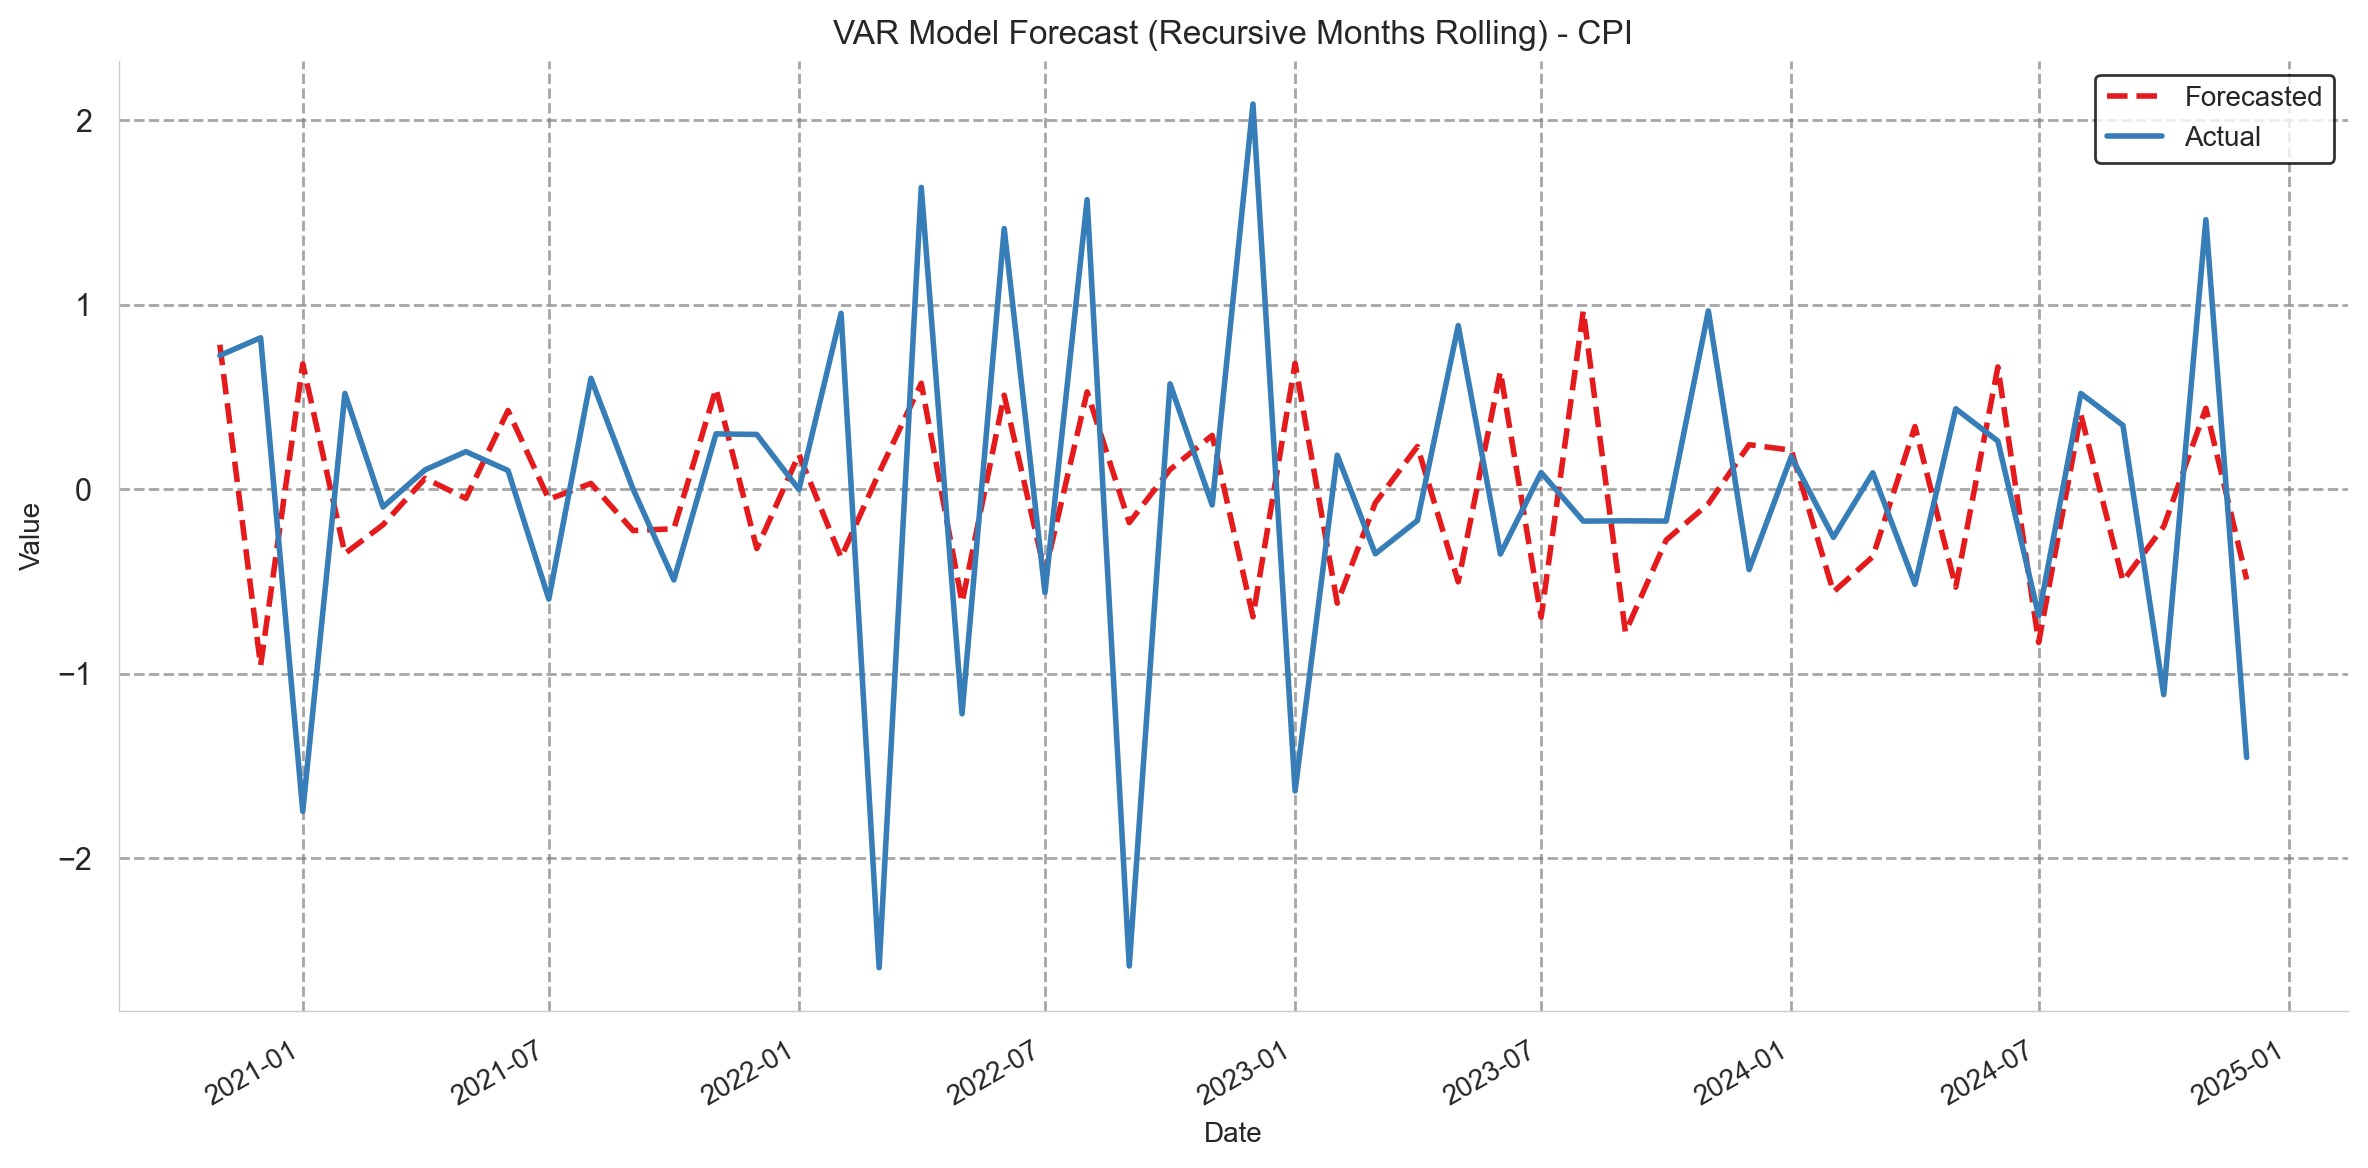

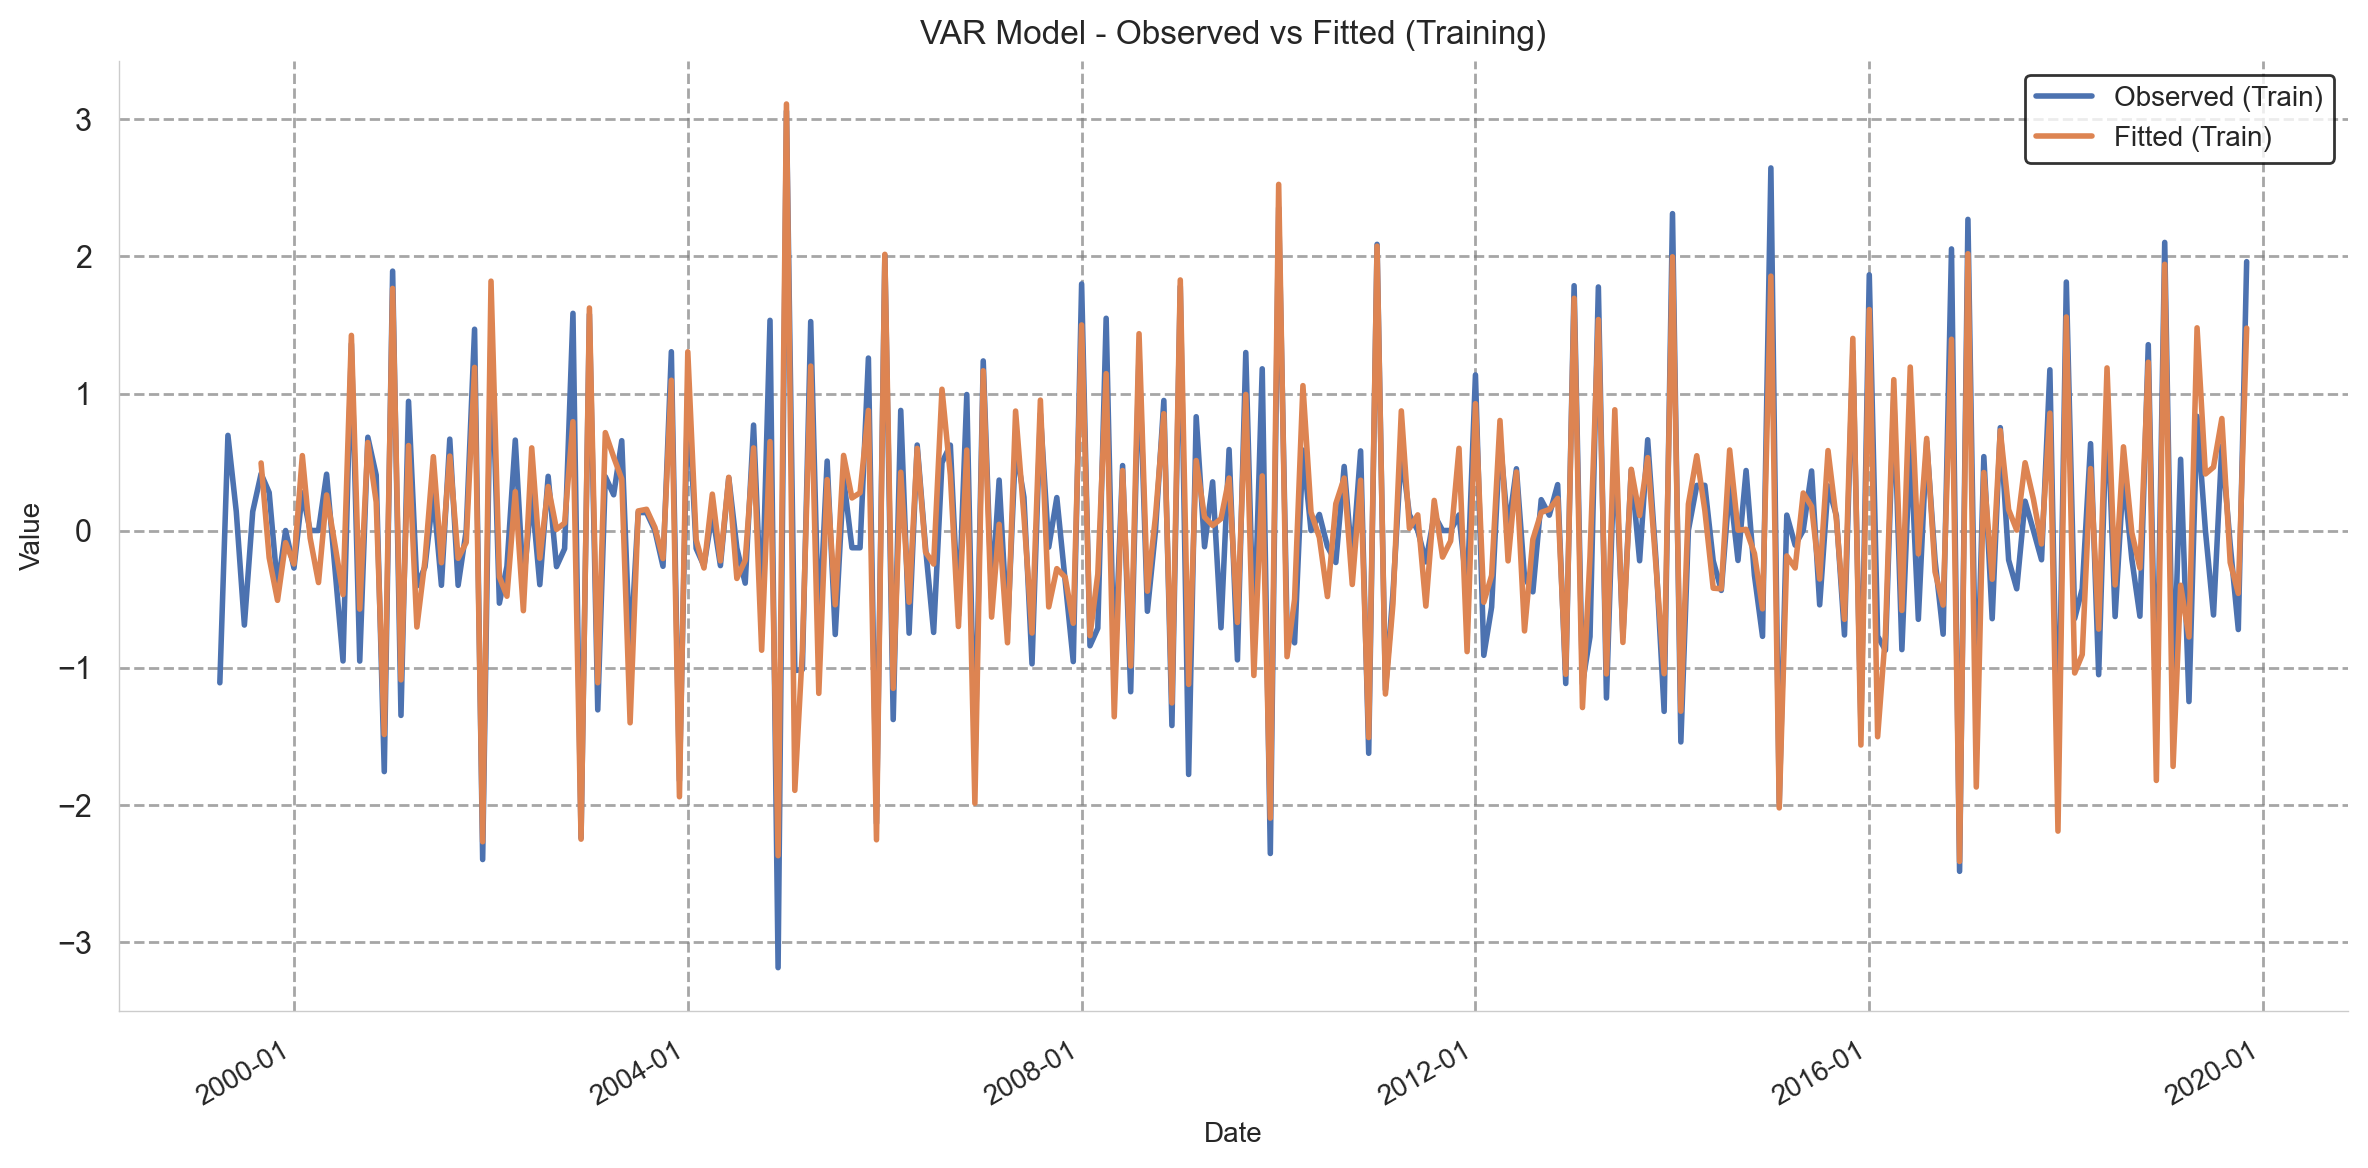

In [65]:
# # Forecast the next
# model, forecasted_cpi, actual_cpi, var_train_df, var_mae, var_rmse = var_forecast(var_model, var_train.copy(), var_test.copy(), lag_order, test_size)
model, forecasted_cpi, actual_cpi, var_train_df, var_mae, var_rmse = var_fixed_horizon_forecast(var_model, var_train.copy(), var_test.copy(), lag_order, 12)
var_model_forecast_plot = plot_forecast(forecasted_cpi, actual_cpi, title_name='VAR Model Forecast (Recursive Months Rolling) - CPI')
var_observed_vs_fitted_plot = plot_observed_vs_fitted_var(model, var_train_df, target, 'VAR Model - Observed vs Fitted (Training)')


# ***ARIMA Training and Test***

In [37]:

arima_train_df = df.iloc[:-test_size]
arima_test_df = df.iloc[-test_size:]
# Extract CPI series for ARIMA
train_cpi_arima = arima_train_df.copy()[target]
test_cpi_arima = arima_test_df.copy()[target]

In [41]:
# For ARIMA order selection (non-seasonal):
auto_arima_model_arima = auto_arima(train_cpi_arima, seasonal=False, stepwise=True,
                                    suppress_warnings=True, error_action="ignore", max_order=10, trace=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=242.671, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=710.618, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=500.391, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=432.018, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=247.071, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=282.394, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=307.618, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=246.683, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=281.558, Time=0.03 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=270.901, Time=0.11 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 0.702 seconds


In [58]:

# def arima_rm_forecast(train_df, test_df, auto_arima_model, forecast_horizon, title='ARIMA: Observed vs Fitted (24 Months Rolling)', target_column=target):
#     # Extract target series
#     train_series = train_df
#     test_series = test_df
#     # Perform rolling forecasts
#     history = train_series.tolist()
#     predictions = []
#     for i in range(len(test_series)):
#         arima_model = ARIMA(history, order=auto_arima_model.order)  # Refit model each step
#         arima_model_fit = arima_model.fit()
#         forecast = arima_model_fit.forecast(steps=1)  # Forecast 'steps' ahead
#         predictions.append(forecast[-1])  # Store last predicted step
#         history.append(test_series.iloc[i])  # Append actual value
#     # Convert predictions to DataFrame
#     forecast_df = pd.DataFrame(predictions, index=test_series.index, columns=[target_column])
#     # Compute evaluation metrics
#     mae = mean_absolute_error(test_series, forecast_df[target_column])
#     rmse = np.sqrt(mean_squared_error(test_series, forecast_df[target_column]))
#     print(f"ARIMA Model - Mean Absolute Error (MAE): {mae:.4f}")
#     print(f"ARIMA Model - Root Mean Squared Error (RMSE): {rmse:.4f}")
#     plot_forecast(forecast_df[target_column], test_series, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
#     plot_arima_observed_vs_fitted(arima_model_fit, train_df, target_column=target_column, title=title) # Pass target_column
#
#     plt.show()  # Display plots
#     return forecast_df, mae, rmse

def arima_rm_forecast(train_df, test_df, auto_arima_model, forecast_horizon, title='ARIMA: Observed vs Fitted (24 Months Rolling)', target_column=target):

    # Extract target series
    train_series = train_df
    test_series = test_df
    # Perform rolling forecasts
    history = train_series.tolist()
    predictions = []
    forecast_dates = []

    for i in range(len(test_series) - forecast_horizon + 1):
        arima_model = ARIMA(history, order=auto_arima_model.order)  # Refit model each step
        arima_model_fit = arima_model.fit()
        forecast = arima_model_fit.forecast(steps=forecast_horizon)  # Forecast 'steps' ahead
        # forecasted_point = forecast.iloc[forecast_horizon - 1]
        # Correct line using standard NumPy indexing
        forecasted_point = forecast[forecast_horizon - 1]
        predictions.append(forecasted_point)
        forecast_dates.append(test_series.index[i + forecast_horizon - 1])
        # 5. Update history with the true observation from the current time step
        history.append(test_series.iloc[i])
    # Convert predictions to DataFrame
    # forecast_df = pd.DataFrame(predictions, index=test_series.index, columns=[target_column])
    forecast_df = pd.DataFrame({target_column: predictions}, index=forecast_dates)
    actuals = test_series.loc[forecast_df.index]
    forecasts = forecast_df[target_column]
    # Compute evaluation metrics
    mae = mean_absolute_error(actuals, forecasts)
    rmse = np.sqrt(mean_squared_error(actuals, forecasts))

    print(f"ARIMA Model - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"ARIMA Model - Root Mean Squared Error (RMSE): {rmse:.4f}")

    # plot_forecast(forecast_df[target_column], test_series, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
    plot_forecast(forecasts, actuals, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
    plot_arima_observed_vs_fitted(arima_model_fit, train_df, target_column=target_column, title=title) # Pass target_column

    plt.show()  # Display plots
    return forecast_df, mae, rmse



# Results

ARIMA Model - Mean Absolute Error (MAE): 0.7344
ARIMA Model - Root Mean Squared Error (RMSE): 1.0032


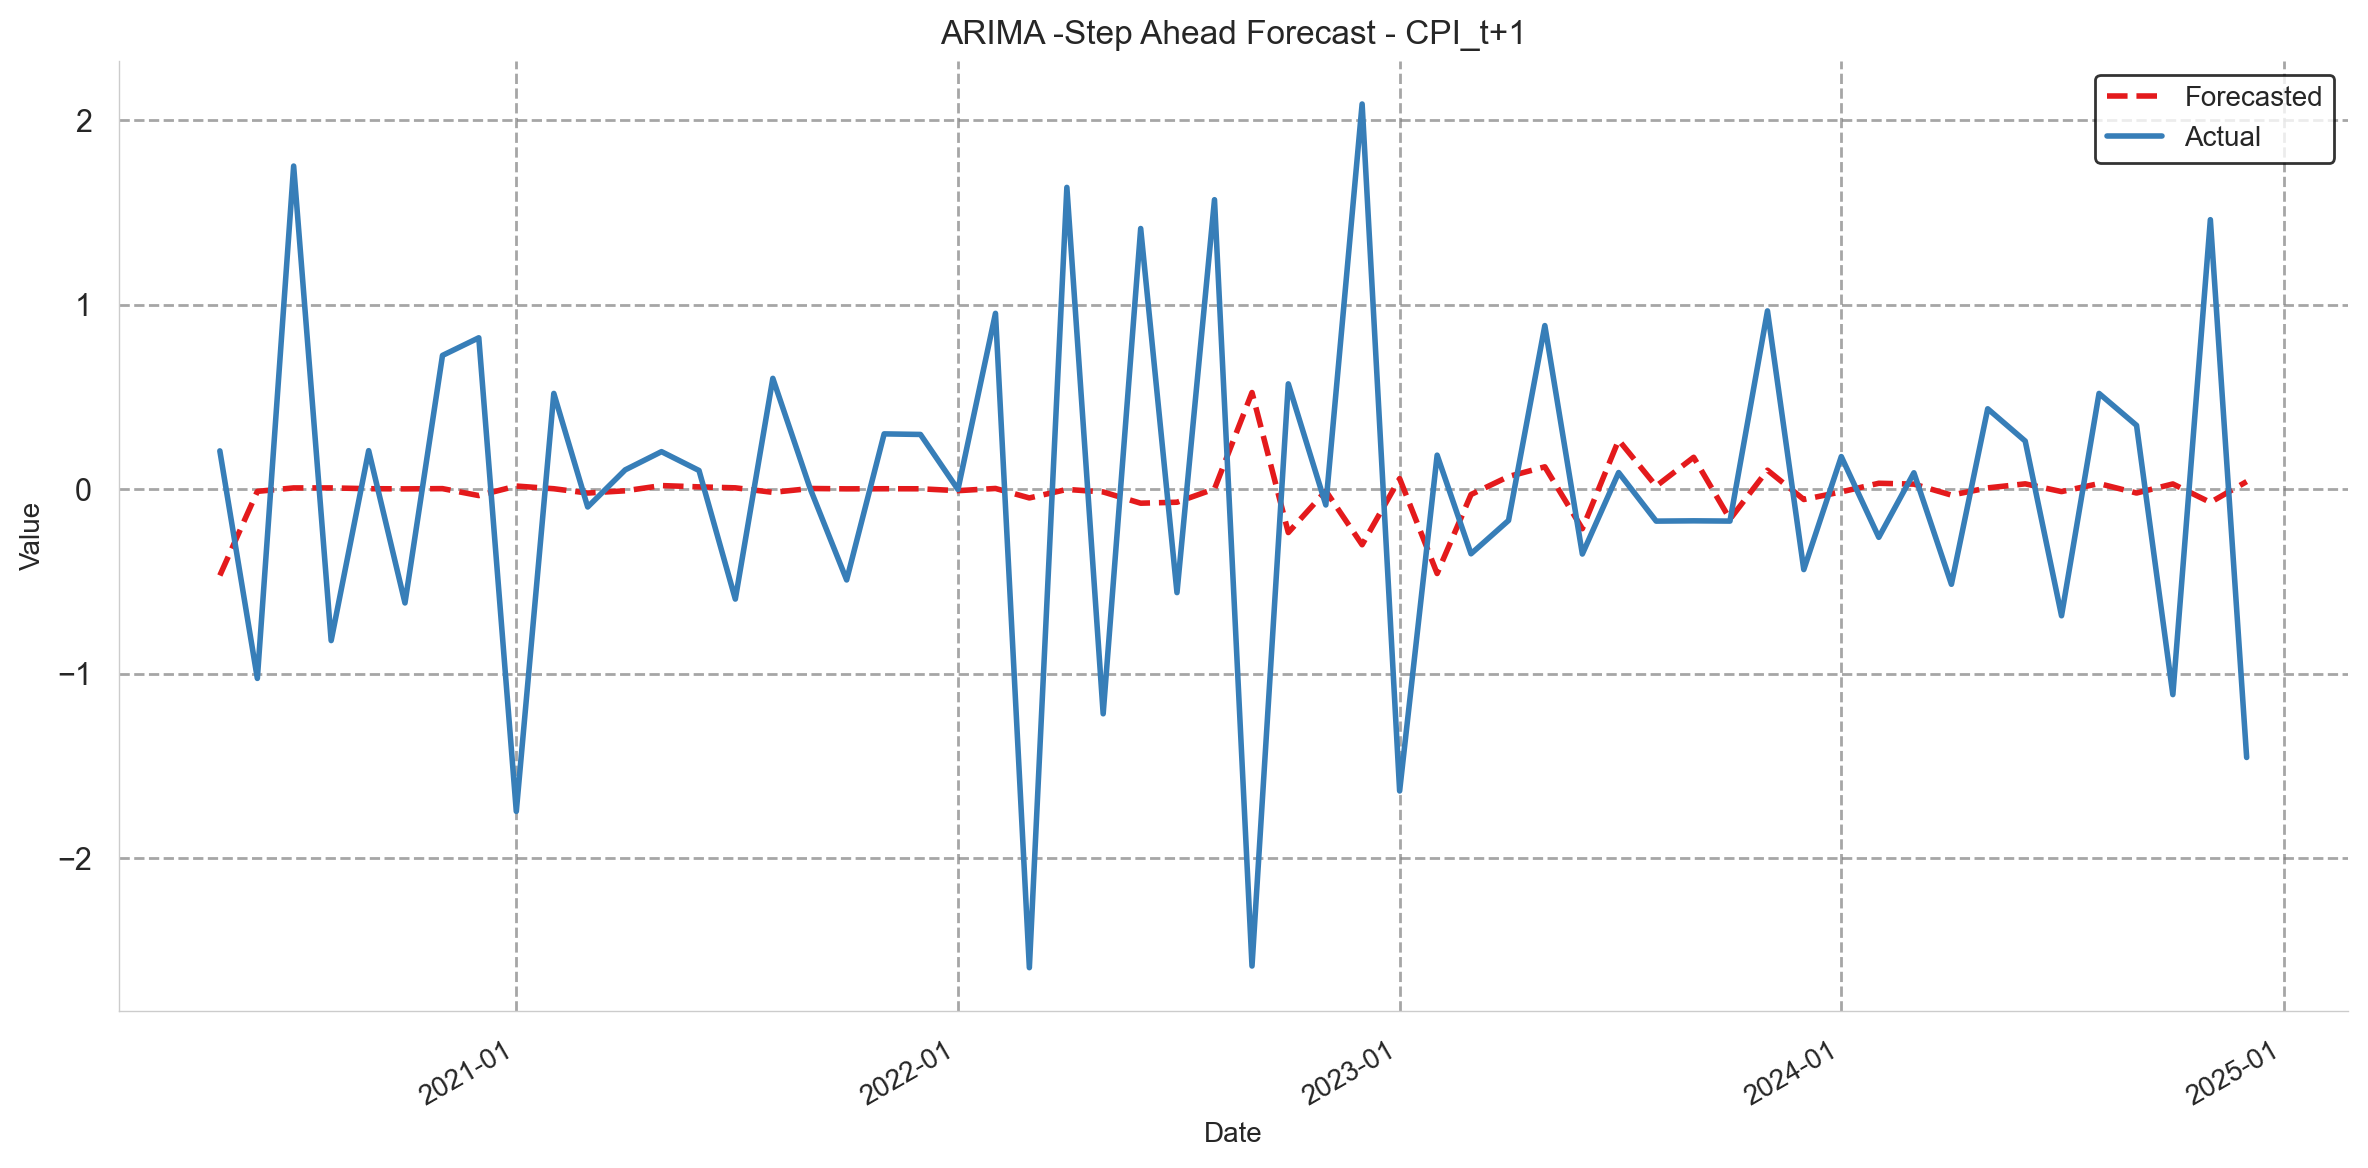

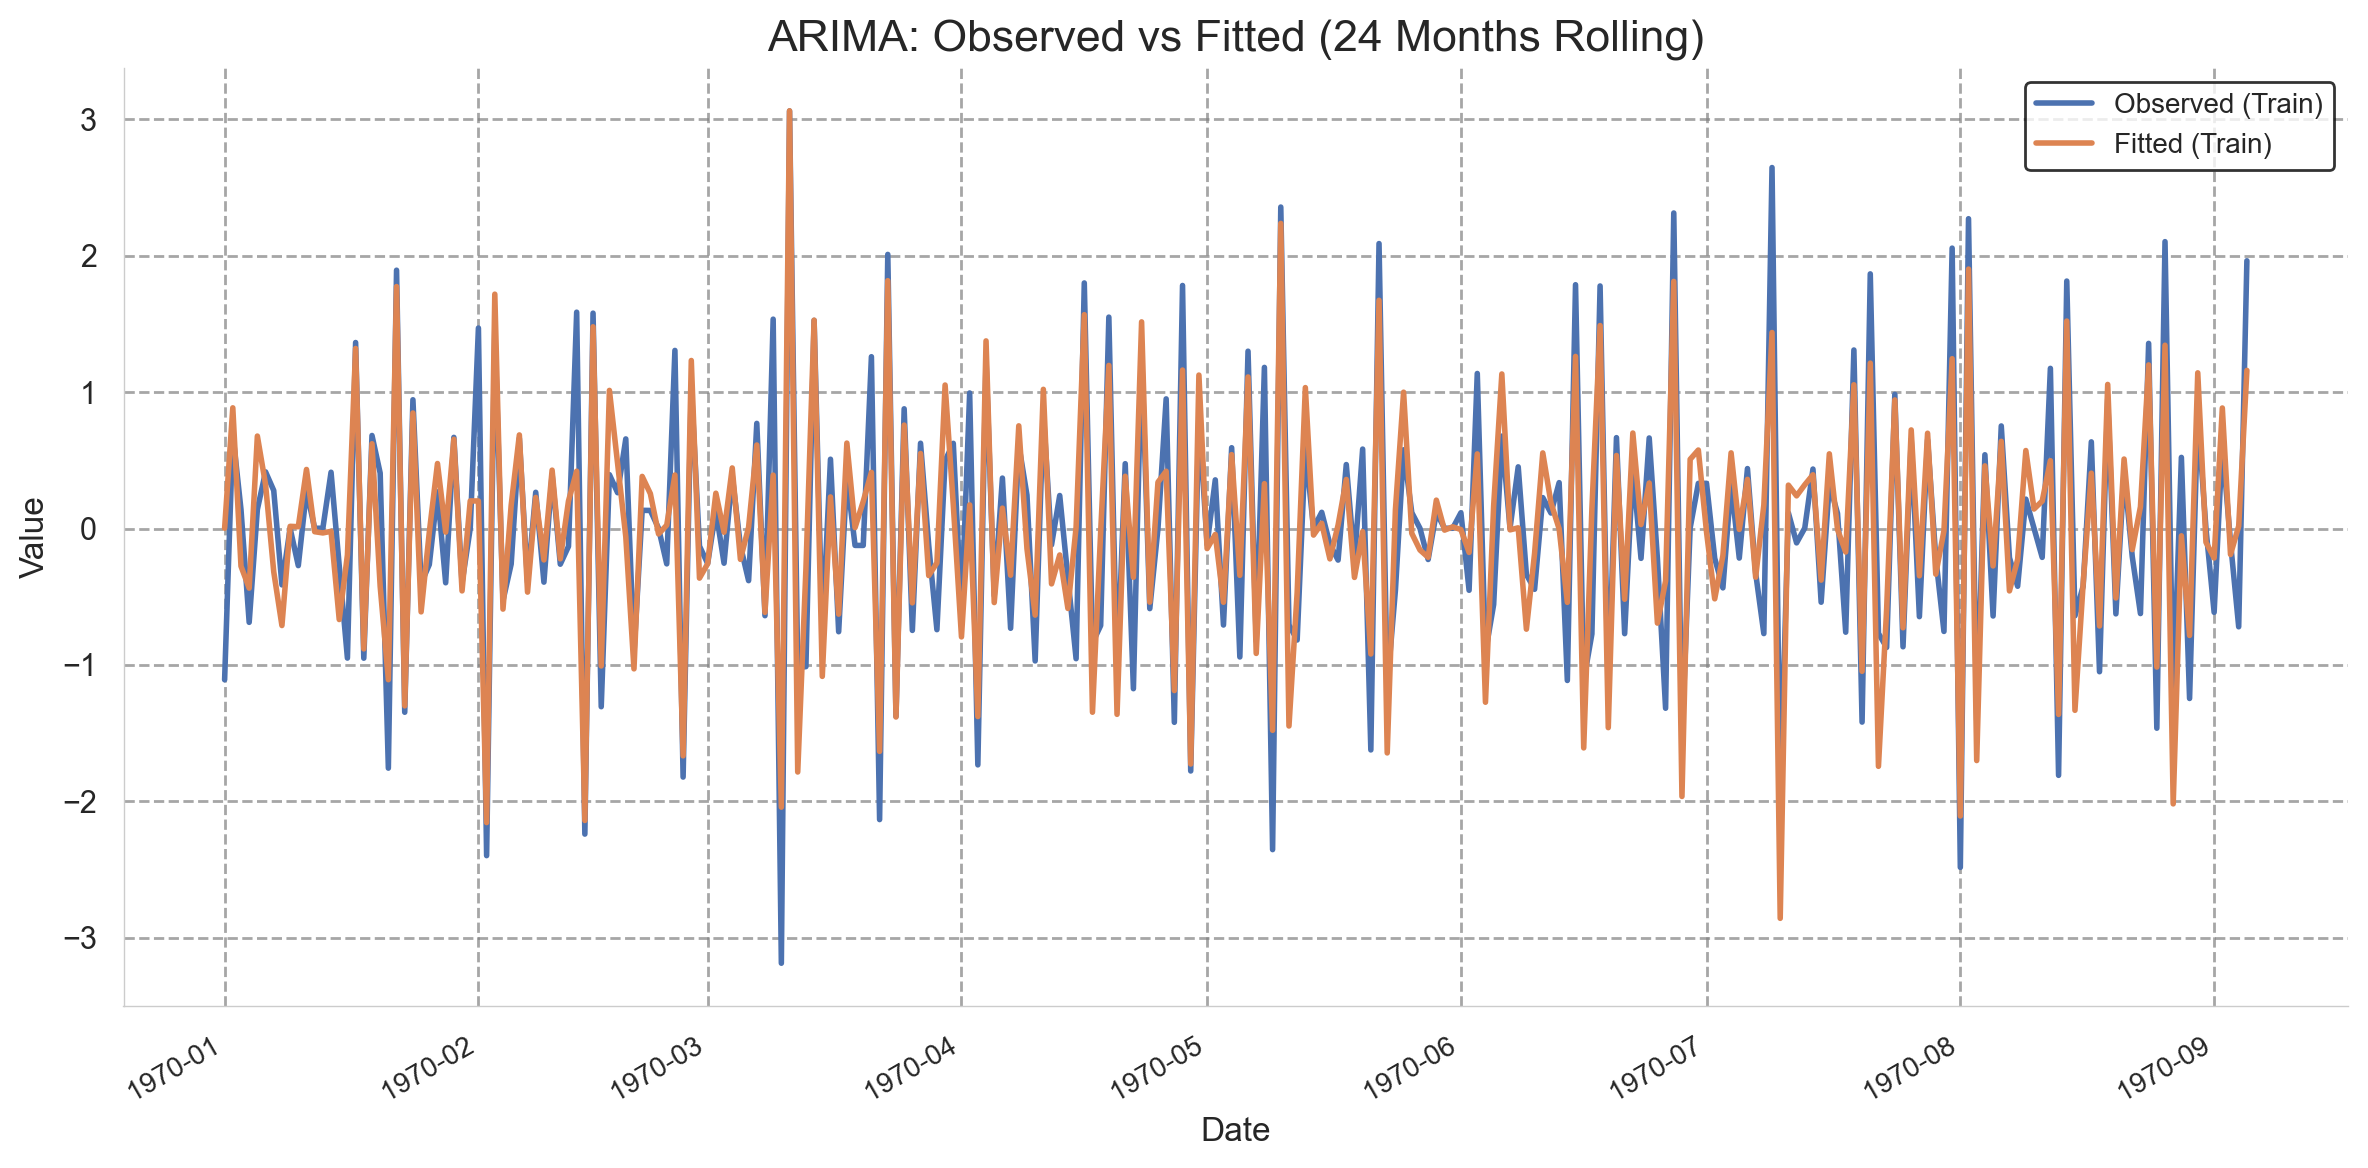

In [67]:
forecast_df, arima_mae, arima_rmse = arima_rm_forecast(train_cpi_arima, test_cpi_arima, auto_arima_model_arima, 6)


# ***SARIMA Training & Test***


In [68]:
# For SARIMA order selection (seasonal):
auto_arima_model_sarima = auto_arima(train_cpi_arima, seasonal=True, m=12, stepwise=True, # m=12 for monthly seasonality
                                     suppress_warnings=True, error_action="ignore", max_order=10, trace=True,
                                     max_p=10, max_q=10, max_P=10, max_Q=10) # Limit search space


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=145.764, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=712.613, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=371.465, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=710.618, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=153.321, Time=0.96 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=147.618, Time=1.14 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=270.901, Time=0.13 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=212.618, Time=1.06 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=144.211, Time=1.25 sec
 ARIMA(2,0,2)(3,0,2)[12] intercept   : AIC=133.641, Time=2.92 sec
 ARIMA(2,0,2)(3,0,1)[12] intercept   : AIC=138.48

In [81]:

def sarima_rm_forecast(train_df, test_df, auto_arima_model_sarima, forecast_horizon, target_column=target):

    # Extract CPI series for ARIMA
    train_cpiauscl_arima = train_df
    test_cpiauscl_arima = test_df
    # Ensure the index is datetime for proper date manipulation
    train_cpiauscl_arima.index = pd.to_datetime(train_cpiauscl_arima.index)
    # Fit SARIMA model to initial training data
    sarima_model = SARIMAX(train_cpiauscl_arima,
                           order=auto_arima_model_sarima.order,
                           seasonal_order=auto_arima_model_sarima.seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)  # disp=False to suppress convergence output

    history = train_cpiauscl_arima.tolist()
    predictions = []
    for i in range(len(test_cpiauscl_arima)):
        # Forecast the next step
        # Refit the model with the updated training data
        sarima_model = SARIMAX(history,
                               order=auto_arima_model_sarima.order,
                               seasonal_order=auto_arima_model_sarima.seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)

        sarima_model_fit = sarima_model.fit(disp=False)
        forecast = sarima_model_fit.forecast(steps=1)
        predictions.append(forecast[0])
        history.append(test_cpiauscl_arima.iloc[i])  # Append actual value

    forecast_df = pd.DataFrame(predictions, index=test_cpiauscl_arima.index, columns=[target_column])

    mae_sarima = mean_absolute_error(test_cpiauscl_arima, forecast_df[target_column])
    rmse_sarima = np.sqrt(mean_squared_error(test_cpiauscl_arima, forecast_df[target_column]))
    # Print evaluation metrics
    print(f'Rolling SARIMA Model - Mean Absolute Error (MAE): {mae_sarima:.4f}')
    print(f'Rolling SARIMA Model - Root Mean Squared Error (RMSE): {rmse_sarima:.4f}')
    # Plot the forecast and the fitted model
    plot_forecast(forecast_df[target_column], test_cpiauscl_arima, title_name='Rolling SARIMA Model Forecast - CPI')
    # plot_forecast(forecast_df[target_column], test_series, title_name=f'ARIMA -Step Ahead Forecast - {target_column}')
    plot_arima_observed_vs_fitted(sarima_model_fit, train_df, target_column=target_column, title='SARIMA Model - Observed vs Fitted (24 Months Rolling)')
    plt.show()

    return sarima_forecast, mae_sarima, rmse_sarima


def sarima_rolling_fixed_horizon_forecast(train_series, test_series, auto_arima_model_sarima, forecast_horizon, target_column):
    predictions = []
    forecast_actual_dates = [] # Dates corresponding to the actual values being predicted
    history = train_series.tolist() # Use a list for history for efficient appending

    for i in range(len(test_series) - forecast_horizon + 1):
        # 1. Refit the SARIMA model on the current history.
        # This is computationally intensive but robust.
        sarima_model = SARIMAX(history,
                               order=auto_arima_model_sarima.order,
                               seasonal_order=auto_arima_model_sarima.seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        sarima_model_fit = sarima_model.fit(disp=False)

        # 2. Forecast `forecast_horizon` steps into the future
        # This will return a Series (or array) with indices for the forecast period.
        forecast_series = sarima_model_fit.forecast(steps=forecast_horizon)
        # 3. Save only the `forecast_horizon`-th step prediction (the very last one)
        # Note: forecast_series is 0-indexed, so the h-th step is at index h-1.
        forecasted_point = forecast_series[forecast_horizon - 1]
        predictions.append(float(forecasted_point)) # Ensure it's a simple float

        # 4. Save the date corresponding to the actual value we are predicting for
        # This date will be 'forecast_horizon - 1' steps *from the current `i` in test_series*.
        actual_date_for_forecast = test_series.index[i + forecast_horizon - 1]
        forecast_actual_dates.append(actual_date_for_forecast)

        # 5. Update history with the true observation from the current time step `i` of the test set.
        # This makes it a true rolling window (expanding history by one actual at a time).
        history.append(test_series.iloc[i])

    # 6. Build the forecast DataFrame using the collected dates and predictions
    forecast_df = pd.DataFrame({target_column: predictions}, index=forecast_actual_dates)

    # 7. Extract actual and forecasted target values using index alignment
    # Ensure test_series covers all forecast_actual_dates
    actuals = test_series.loc[forecast_df.index]
    forecasts = forecast_df[target_column]

    # 8. Compute evaluation metrics
    mae_sarima = mean_absolute_error(actuals, forecasts)
    rmse_sarima = np.sqrt(mean_squared_error(actuals, forecasts))

    print(f"SARIMA Rolling {forecast_horizon}-Step Ahead Fixed Horizon Forecast")
    print(f"MAE: {mae_sarima:.5f}, RMSE: {rmse_sarima:.5f}")

    # Plot the final forecasts against the actuals
    observed = pd.Series(history, index=train_series.index.tolist() + test_series.index[:len(history) - len(train_series)].tolist())


    return forecast_df, mae_sarima, rmse_sarima, forecasts, actuals, sarima_model_fit, observed

# Result

SARIMA Forecast Horizon (fixed): 1
MAE: 0.37345, RMSE: 0.50904

SARIMA Rolling 1-Step Ahead Fixed Horizon Forecast
MAE: 0.37345, RMSE: 0.50904


ValueError: Length of values (308) does not match length of index (309)

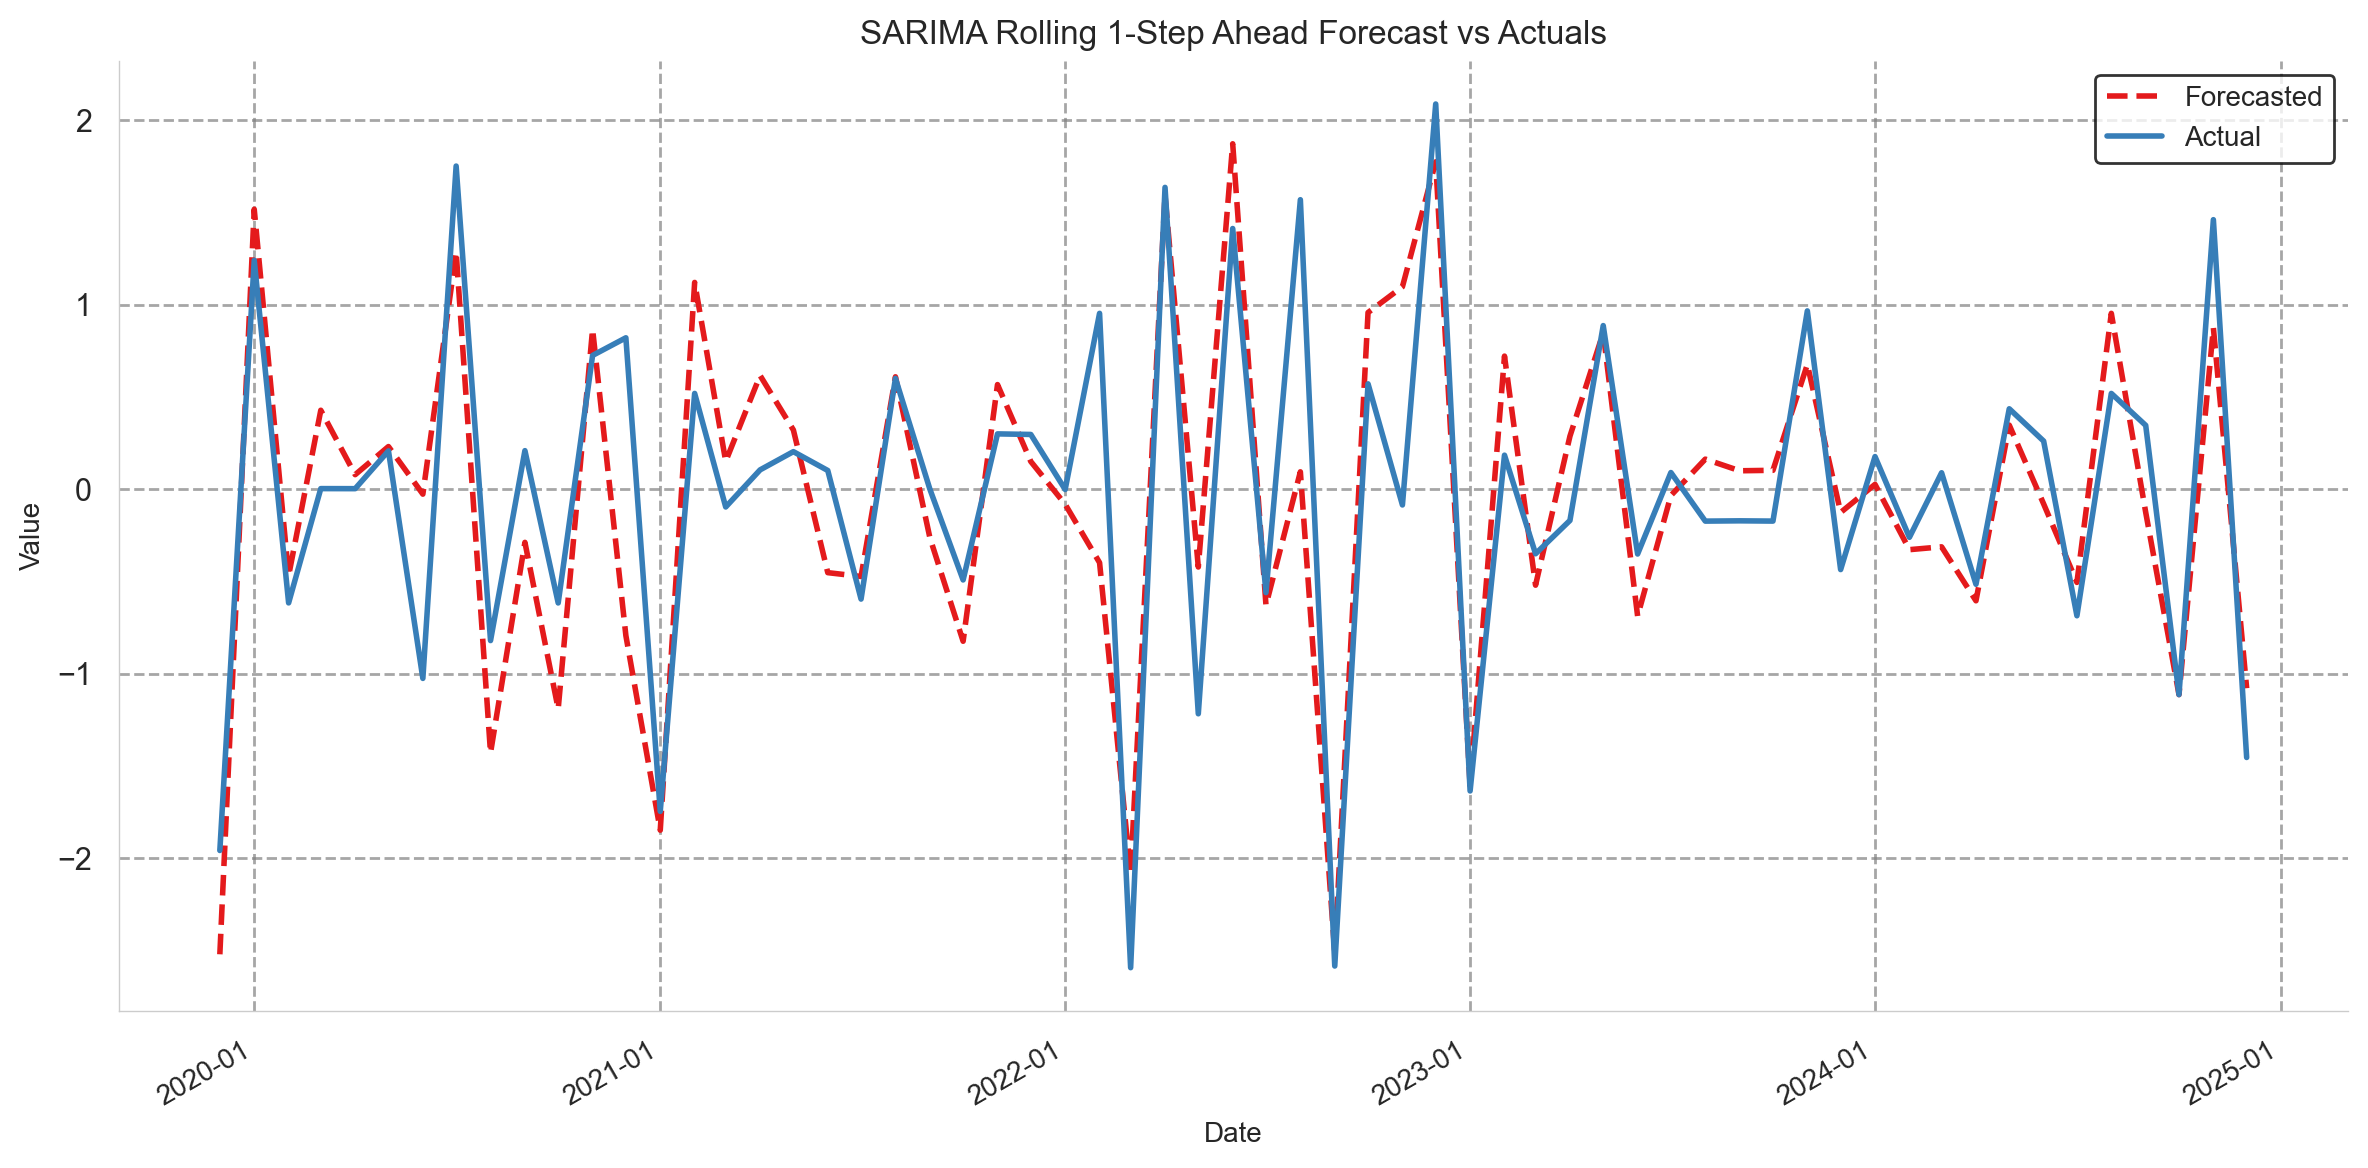

In [83]:

sarima_forecast, sarima_mae, sarima_rmse, sar_forecasts, sar_actuals, sarima_model_fit, sar_observed = sarima_rolling_fixed_horizon_forecast(train_cpi_arima, test_cpi_arima, auto_arima_model_sarima, 1, target)

In [ ]:
plot_forecast(sar_forecasts, sar_actuals, title_name=f'SARIMA Rolling 1-Step Ahead Forecast vs Actuals')
plot_arima_observed_vs_fitted(sarima_model_fit, sar_observed, target_column=target, title='SARIMA Model - Observed vs Fitted (Last Rolling Fit)')
plt.show() # Make sure to show the plot

SARIMA Forecast Horizon (fixed): 6
MAE: 0.96070, RMSE: 1.25110


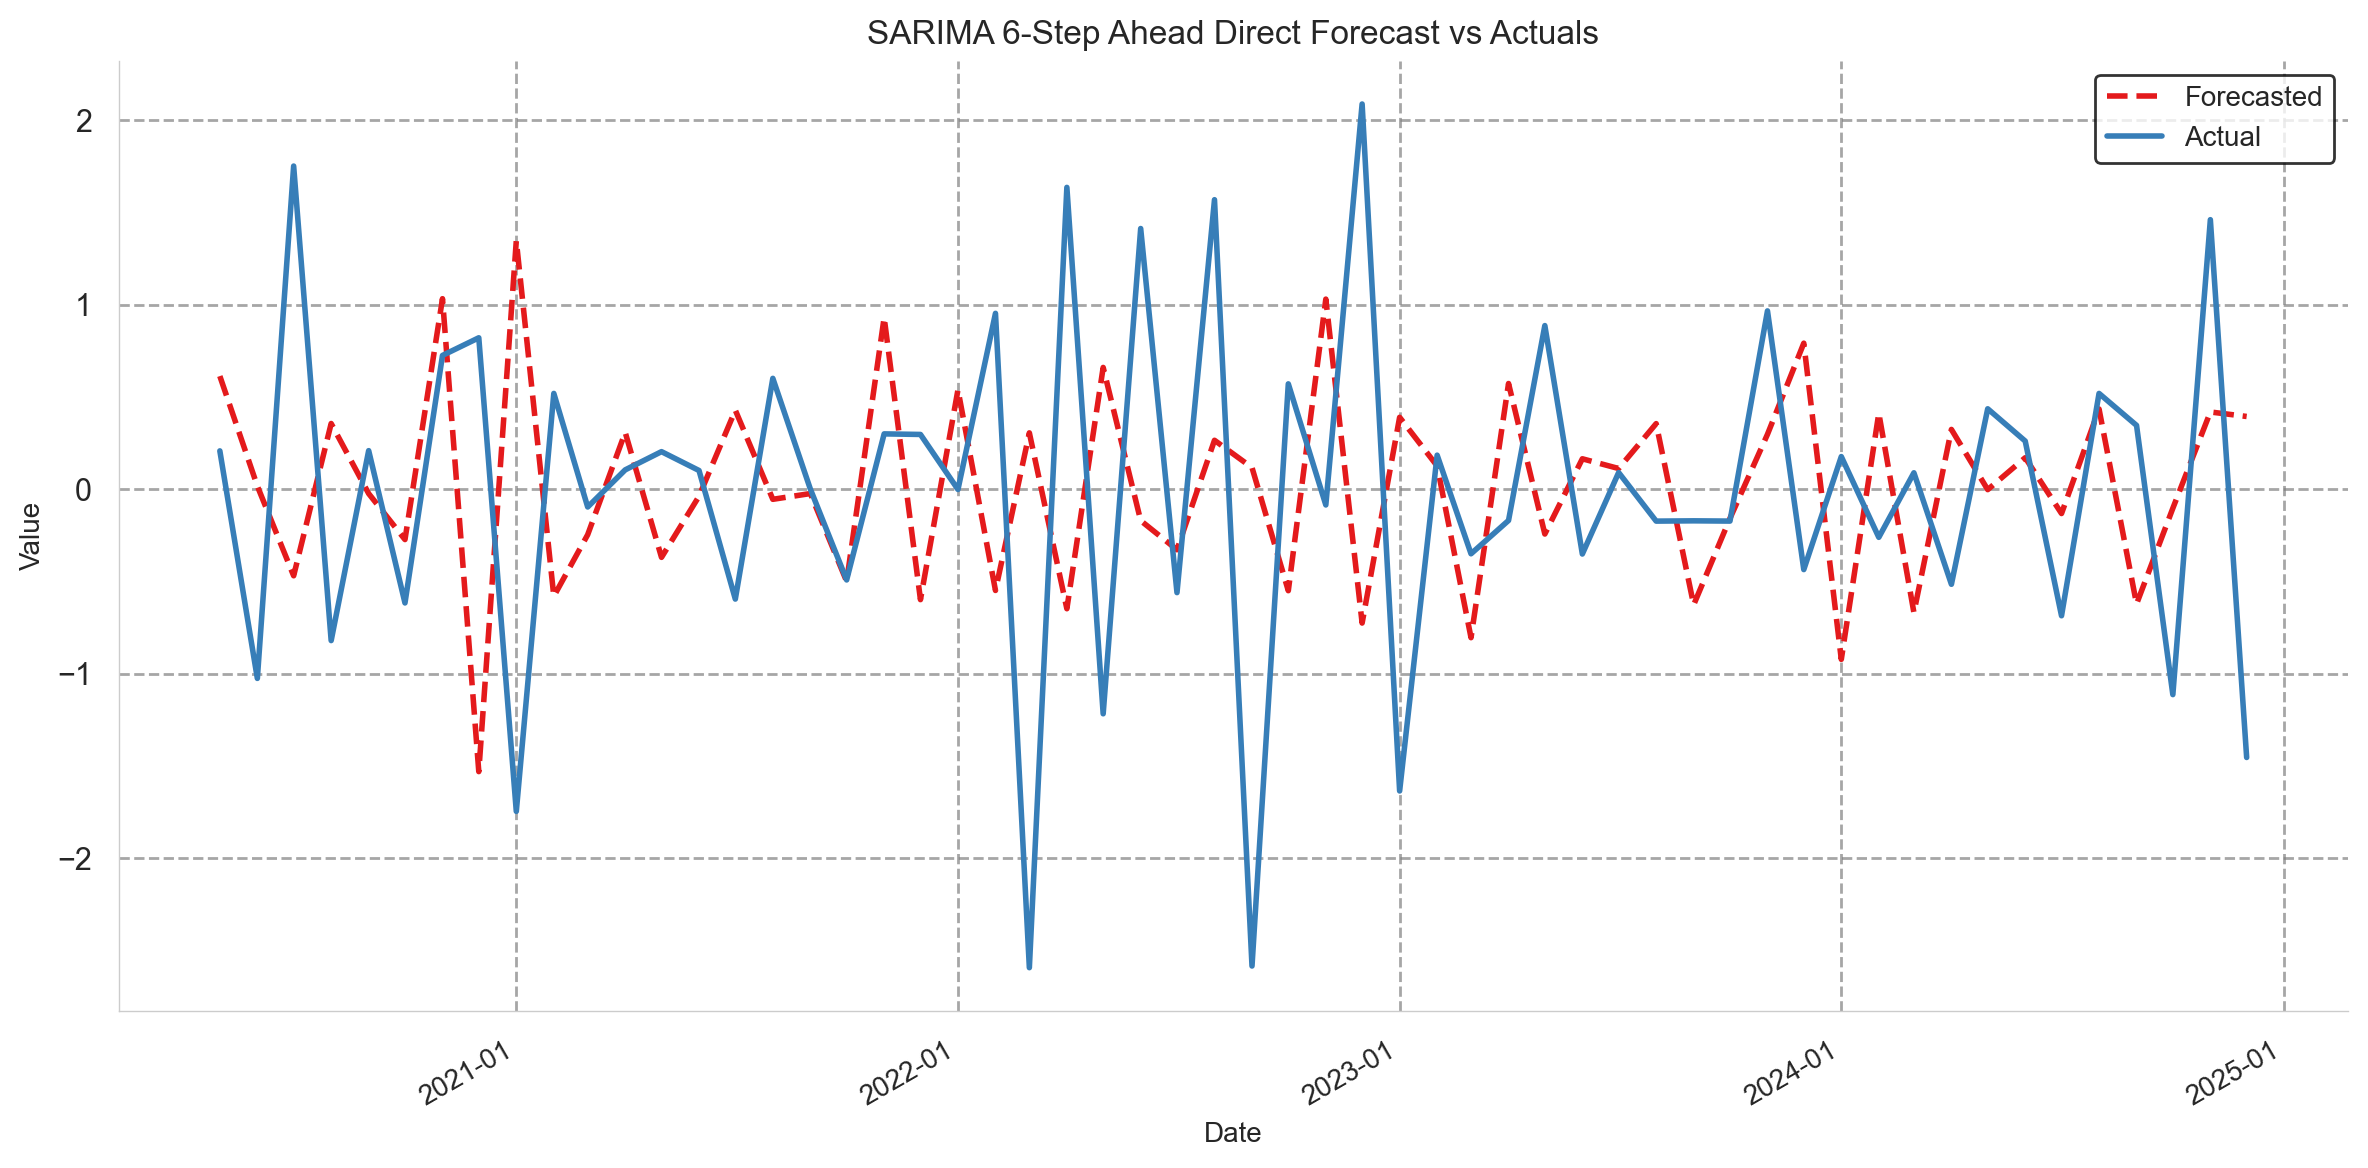

In [78]:
sarima_forecast, sarima_mae, sarima_rmse = sarima_direct_horizon_forecast(train_cpi_arima, test_cpi_arima, auto_arima_model_sarima, 6, target)

# ***CNN-LSTM Training & Testing***

In [8]:

def prepare_data_convlstm2D(data, target_column, test_size, timesteps=3, grid_shape=(4, 6)):
    """
    Prepares the data for ConvLSTM2D using temporal sequences and reshapes features into spatial grids.
    """
    feature_names = [col for col in data.columns if col != target_column]
    total_features = len(feature_names)
    rows, cols = grid_shape
    grid_size = rows * cols
    assert grid_size >= total_features, f"Grid shape {grid_size} is too small for number of features {total_features}."

    # Padding mask
    # def pad_features(features):
    #     padded = np.zeros((features.shape[0], grid_size))
    #     padded[:, :features.shape[1]] = features
    #     return padded.reshape(features.shape[0], rows, cols, 1)
    def pad_features_to_grid(features, rows, cols):
        padded_grid = np.zeros((features.shape[0], rows, cols, 1))
        for t in range(features.shape[0]):
            for idx, val in enumerate(features[t]):
                r, c = divmod(idx, cols)
                padded_grid[t, r, c, 0] = val
        return padded_grid

    # Generate sequences
    X, y, indices = [], [], []
    for i in range(len(data) - timesteps):
        seq_x = data.iloc[i:i+timesteps][feature_names].values
        seq_y = data.iloc[i + timesteps - 1][target_column]
        X.append(seq_x)
        y.append(seq_y)
        indices.append(data.index[i + timesteps])

    X = np.array(X)  # shape: (samples, timesteps, features)
    y = np.array(y).reshape(-1, 1)
    indices = np.array(indices)

    # Normalize
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_flat = X.reshape(-1, total_features)
    X_scaled = scaler_X.fit_transform(X_flat).reshape(X.shape)
    y_scaled = scaler_y.fit_transform(y)

    # Reshape for ConvLSTM2D: (samples, timesteps, rows, cols, channels)
    X_reshaped = np.array([
        # pad_features_to_grid(sample) for sample in X_scaled
        pad_features_to_grid(sample, rows, cols) for sample in X_scaled
    ])  # shape: (samples, timesteps, rows, cols, 1)

    # Split train/test
    X_train = X_reshaped[:-test_size]
    y_train = y_scaled[:-test_size]
    X_test = X_reshaped[-test_size:]
    y_test = y_scaled[-test_size:]
    train_index = indices[:-test_size]
    test_index = indices[-test_size:]

    # Input shape for ConvLSTM2D layer
    input_shape = X_reshaped.shape[1:]  # (timesteps, rows, cols, channels)

    return X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names, input_shape

def prepare_data_conv_1D(data, target_column, test_size, timesteps=3):
    """
    Prepares data for Conv1D models with sliding window of specified timesteps.
    Returns scaled and reshaped train/test splits along with metadata.
    """
    data = data.copy()
    feature_names_used = data.drop(columns=target_column).columns.tolist()

    # Extract feature and target arrays
    X_all = data.drop(columns=target_column).values
    y_all = data[target_column].values.reshape(-1, 1)

    # Scale features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_all_scaled = scaler_X.fit_transform(X_all)
    y_all_scaled = scaler_y.fit_transform(y_all)

    # Create sequences
    def create_sequences(X, y, timesteps):
        X_seq, y_seq = [], []
        for i in range(len(X) - timesteps + 1):
            X_seq.append(X[i:i+timesteps])
            y_seq.append(y[i+timesteps-1])  # target at the end of the window
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X_all_scaled, y_all_scaled, timesteps)

    # Adjusted split size due to sequence shortening
    adjusted_test_size = test_size
    adjusted_train_size = len(X_seq) - adjusted_test_size

    X_train = X_seq[:adjusted_train_size]
    y_train = y_seq[:adjusted_train_size]
    X_test = X_seq[-adjusted_test_size:]
    y_test = y_seq[-adjusted_test_size:]

    # Index tracking (optional)
    train_index = data.index[timesteps-1:timesteps-1 + adjusted_train_size]
    test_index = data.index[-adjusted_test_size:]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    return X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape

def add_time_features(data):
    df = data.copy()
    df.index = pd.to_datetime(df.index)

    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    return df.drop(columns=['month', 'quarter', 'year'])  # drop only if you keep cyclical encodings


In [10]:

def build_model_conv1D(input_shape):
    model = Sequential([
        Conv1D(filters=8, kernel_size=2, activation='tanh', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        # Conv1D(filters=8, kernel_size=6, activation='tanh', padding='same', kernel_regularizer=l2(0.01)),
        # Dropout(0.3),
        Flatten(),
        # Dense(32, activation='linear'),
        Dense(1)
    ])
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    return model


def build_model_convlstm2D(input_shape):
    model = Sequential([
        ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', return_sequences=True, input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        # ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', return_sequences=False, padding='same', kernel_regularizer=l2(0.01)),
        # Dropout(0.3),
        Flatten(),
        # Dense(64, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_model_convlstm1D(input_shape):
    model = Sequential([
        Conv1D(filters=8, kernel_size=6, activation='tanh', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        LSTM(8, return_sequences=False),
        # Dropout(0.5),
        # Conv1D(filters=8, kernel_size=6, activation='tanh',padding='same', kernel_regularizer=l2(0.01)),
        # LSTM(8, return_sequences=True),
        Dropout(0.5),
        # LSTM(16),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [11]:
def train_model(model, X_train, y_train, batch_size=16):
    """Trains the model with early stopping."""
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    history = model.fit(train_dataset, epochs=600, callbacks=[early_stopping], verbose=0)
    return history

def evaluate_model(model, X_test, y_test, batch_size=16):
    """Evaluates the model and returns the test loss and predictions."""
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)
    loss = model.evaluate(test_dataset, verbose=0)
    predictions = model.predict(test_dataset, verbose=0)
    return loss, predictions

def inverse_transform(scaler, data):
    """Inverse transforms the scaled data."""
    return scaler.inverse_transform(data.reshape(-1, 1))

def cnn_rolling_forecast(model, X_test, y_test, scaler_y, test_index):
    """
    Performs a rolling one-step forecast using the trained CNN model.
    Uses true lagged values from X_test for each prediction.
    """
    predictions = []
    for i in range(len(X_test)):
        input_step = X_test[i:i+1]  # shape (1, timesteps, features)
        pred_scaled = model.predict(input_step, verbose=0)
        pred = scaler_y.inverse_transform(pred_scaled)[0][0]
        predictions.append(pred)

    y_test_actual = scaler_y.inverse_transform(y_test).flatten()
    predictions = np.array(predictions)

    mae = mean_absolute_error(y_test_actual, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    print(f'CNN Model - Mean Absolute Error (MAE): {mae: .4f}')
    print(f'CNN Model - Root Mean Squared Error (RMSE): {rmse: .4f}')
    # plot_forecast(pd.Series(predictions, index=test_index),
    #               pd.Series(y_test_actual.flatten(), index=test_index),
    #               title_name='CNN Rolling Forecast - CPI')
    return predictions, mae, rmse, y_test_actual


def model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index):
    history = train_model(model, X_train, y_train)
    loss, predictions = evaluate_model(model, X_test, y_test)
    predictions, mae, rmse, y_test_actual = cnn_rolling_forecast(model, X_test, y_test, scaler_y, test_index)
    predictions_train = model.predict(X_train, verbose=0) # Predict on X_train
    predictions_train_actual = inverse_transform(scaler_y, predictions_train) # Inverse transform fitted values
    y_train_actual = inverse_transform(scaler_y, y_train) # Inverse transform y_train
    # --- Plot Observed vs Fitted on Training Data ---
    plot_cnn_forecast = plot_predictions(y_test_actual, predictions, test_index)
    plot_cnn_obs_vs_fitted = plot_observed_vs_fitted(y_train_actual, predictions_train_actual, train_index) # Pass y_train_actual and predictions_train_actual
    print(f'Mean Absolute Error (MAE): {mae:.8f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.8f}')

    return model, X_train, X_test, mae, rmse

In [12]:
def conv1D(data, target, test_size=test_size, lookback=1):
    assert lookback >= 1, "Lookback must be at least 1: To represent values at time t"
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=lookback)
    model = build_model_conv1D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def convlstm2D(data, target, test_size=test_size, lookback=1):
    assert lookback >= 1, "Lookback must be at least 1: To represent values at time t"
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_convlstm2D(data, target, test_size=test_size, timesteps=lookback)
    model = build_model_convlstm2D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

def convlstm1D(data, target, test_size=test_size, lookback=1):
    assert lookback >= 1, "Lookback must be at least 1: To represent values at time t"
    X_train, y_train, X_test, y_test, train_index, test_index, scaler_y, feature_names_used, input_shape = prepare_data_conv_1D(data, target, test_size=test_size, timesteps=lookback)
    model = build_model_convlstm1D(input_shape)
    model, X_train, X_test, mae, rmse = model_handler(model, X_train, y_train, X_test, y_test, scaler_y, test_index, train_index)
    return model, X_train, X_test, mae, rmse, feature_names_used

In [13]:
main_vars_n_target_cols = np.append(main_vars_cols, "CPI_t+1")

In [655]:
print(main_vars_n_target_cols)

['UNERWG' 'ECBIRRO' 'ECBDFR' 'ECBMLFR' 'MMR' 'CPI' 'RETAILMV' 'RETAILXMV'
 'RETAILGSR' 'RETAILGF' 'GOODFBT' 'AGRPROD' 'PPIIP' 'WPI' 'EPI' 'IPI'
 'HICP' 'LTIR' 'UR' 'DAX' 'STOXX50E' 'EW' 'CPI_t+1']


In [678]:
print(target)

CPI_t+1


CNN Model - Mean Absolute Error (MAE):  0.5518
CNN Model - Root Mean Squared Error (RMSE):  0.7236


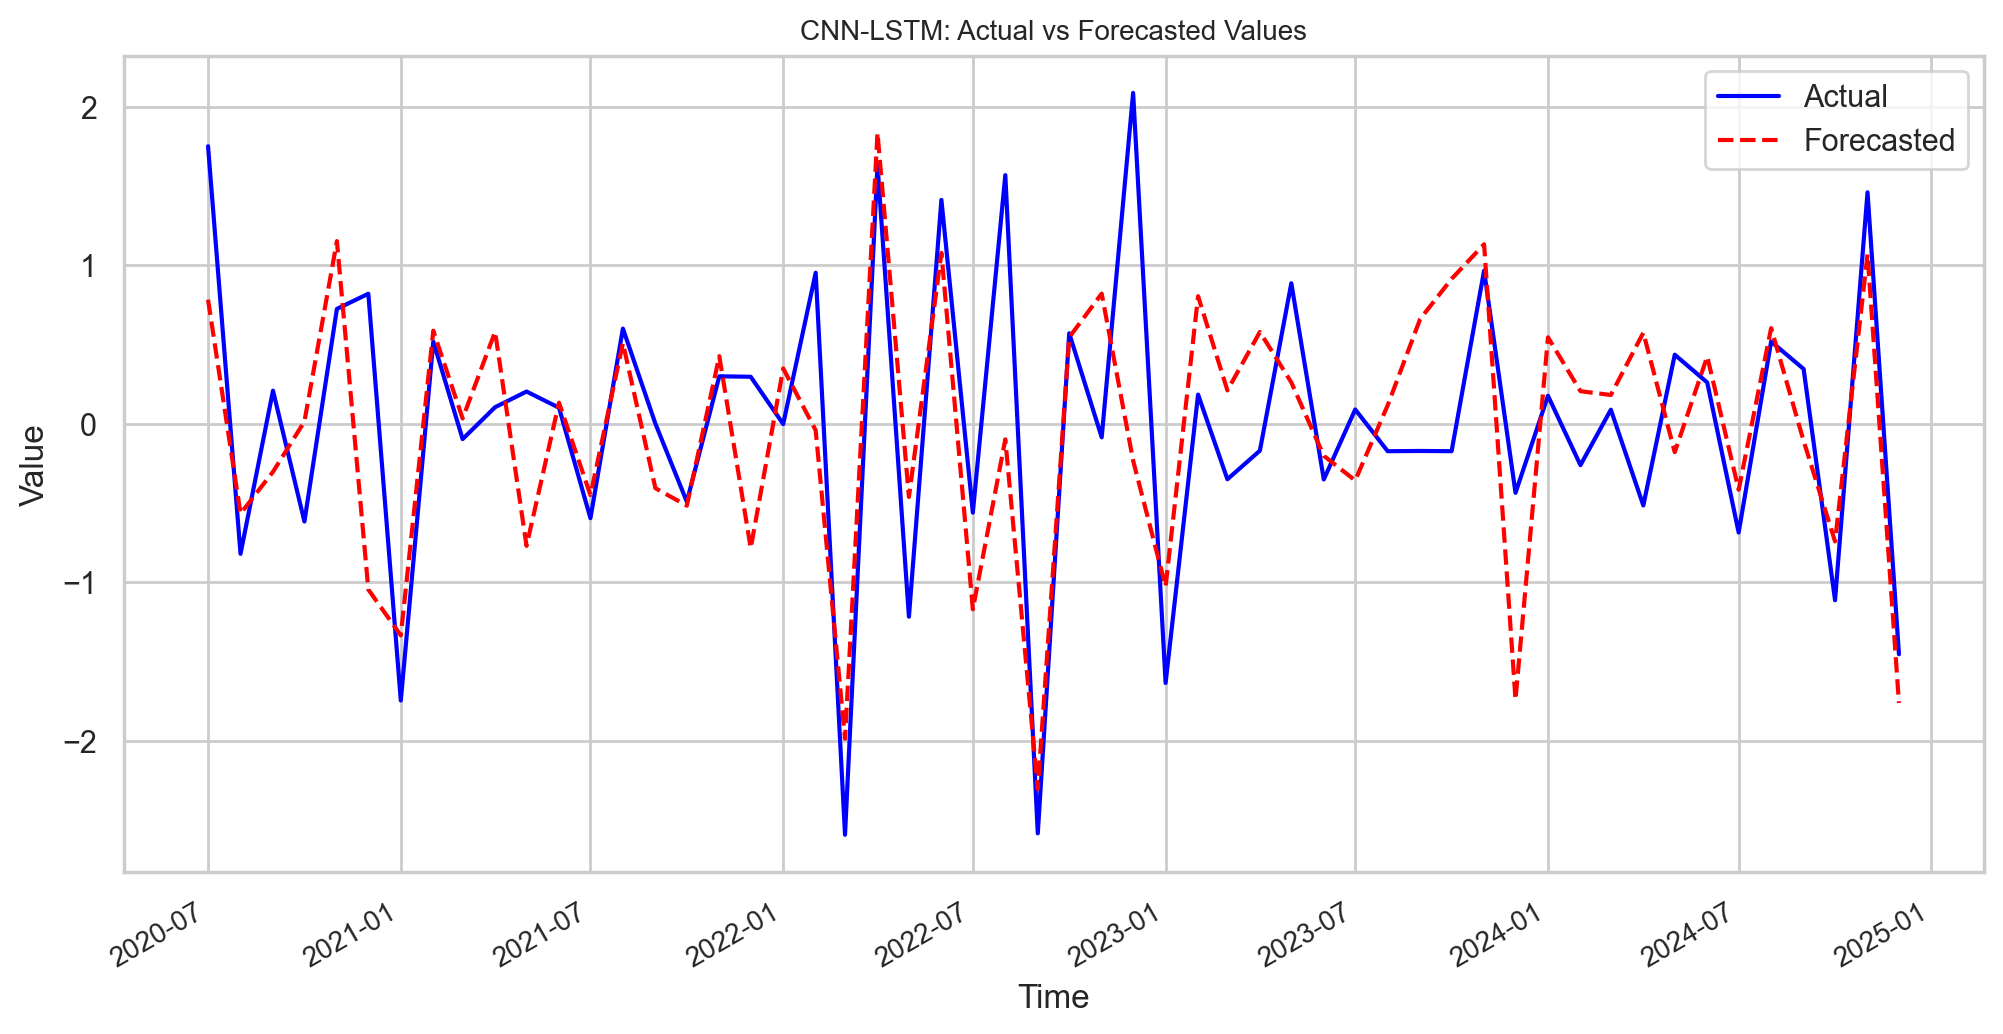

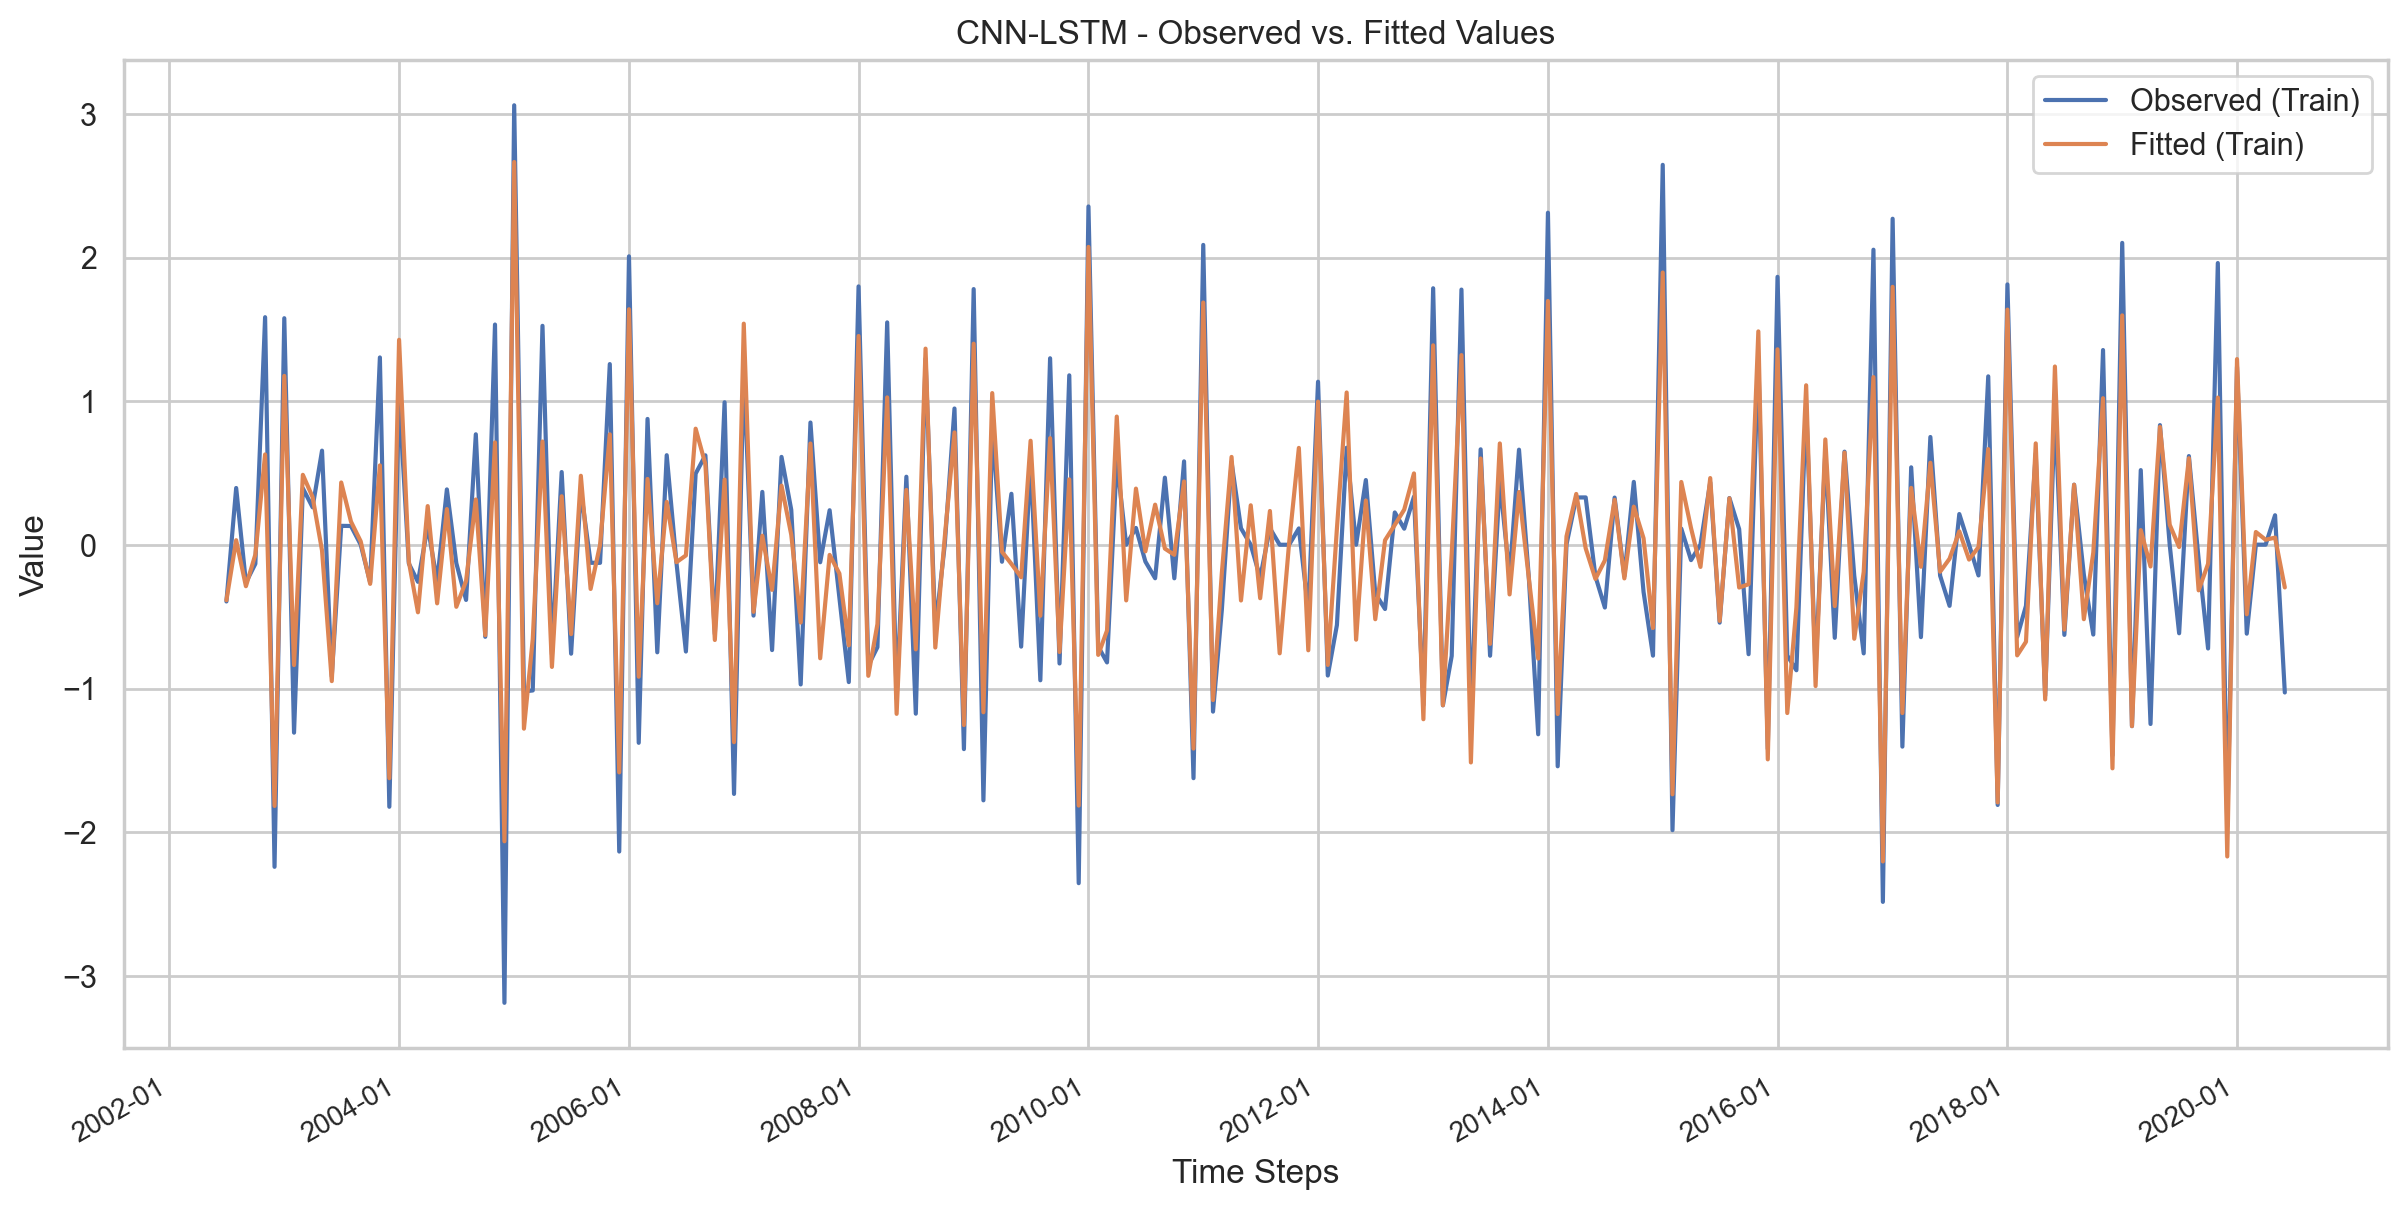

Mean Absolute Error (MAE): 0.55181969
Root Mean Squared Error (RMSE): 0.72364572


In [14]:
df_main_plus_targ1 = df_cpi_target[main_vars_n_target_cols]
model_C1D_nfe, X_train_C1D_nfe, X_test_C1D_nfe, mae_C1D_nfe, rmse_C1D_nfe, fnames_C1D_nfe = conv1D(df_main_plus_targ1,target, test_size, 3)

CNN Model - Mean Absolute Error (MAE):  0.4749
CNN Model - Root Mean Squared Error (RMSE):  0.6884


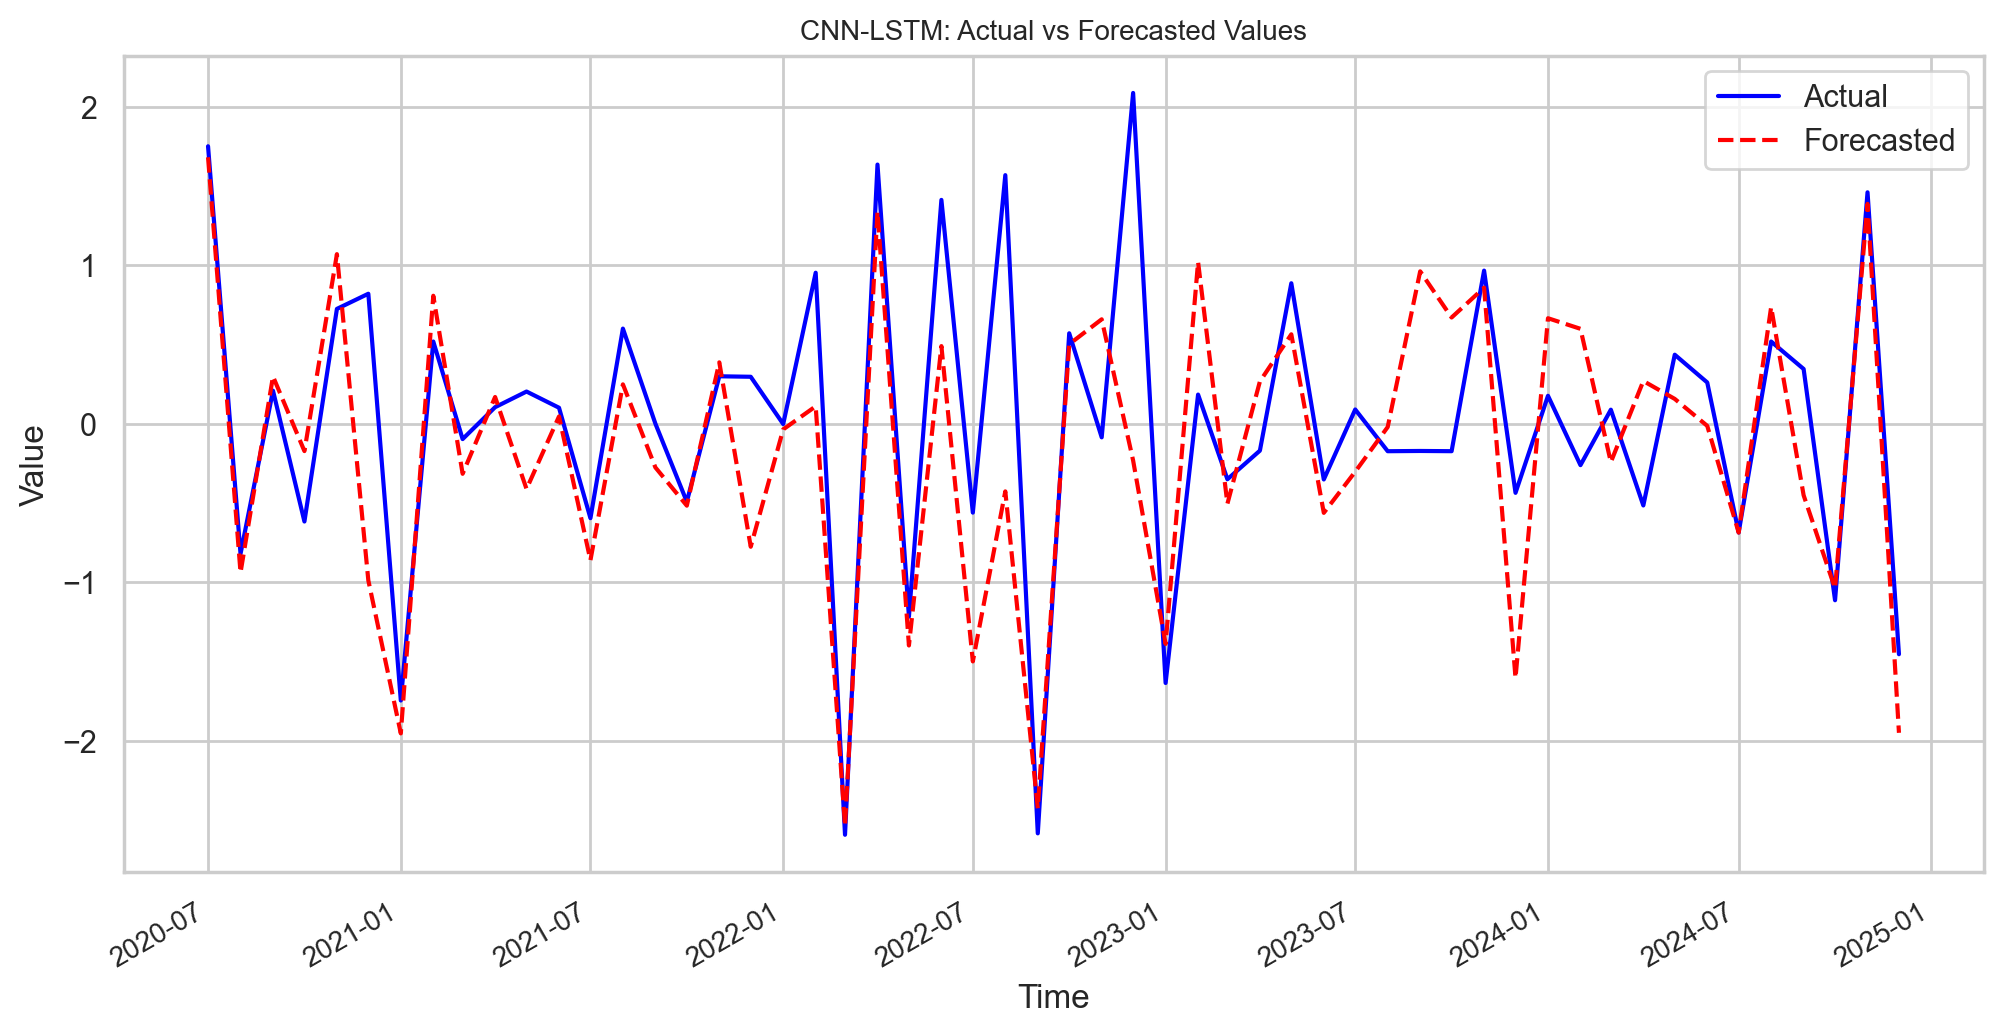

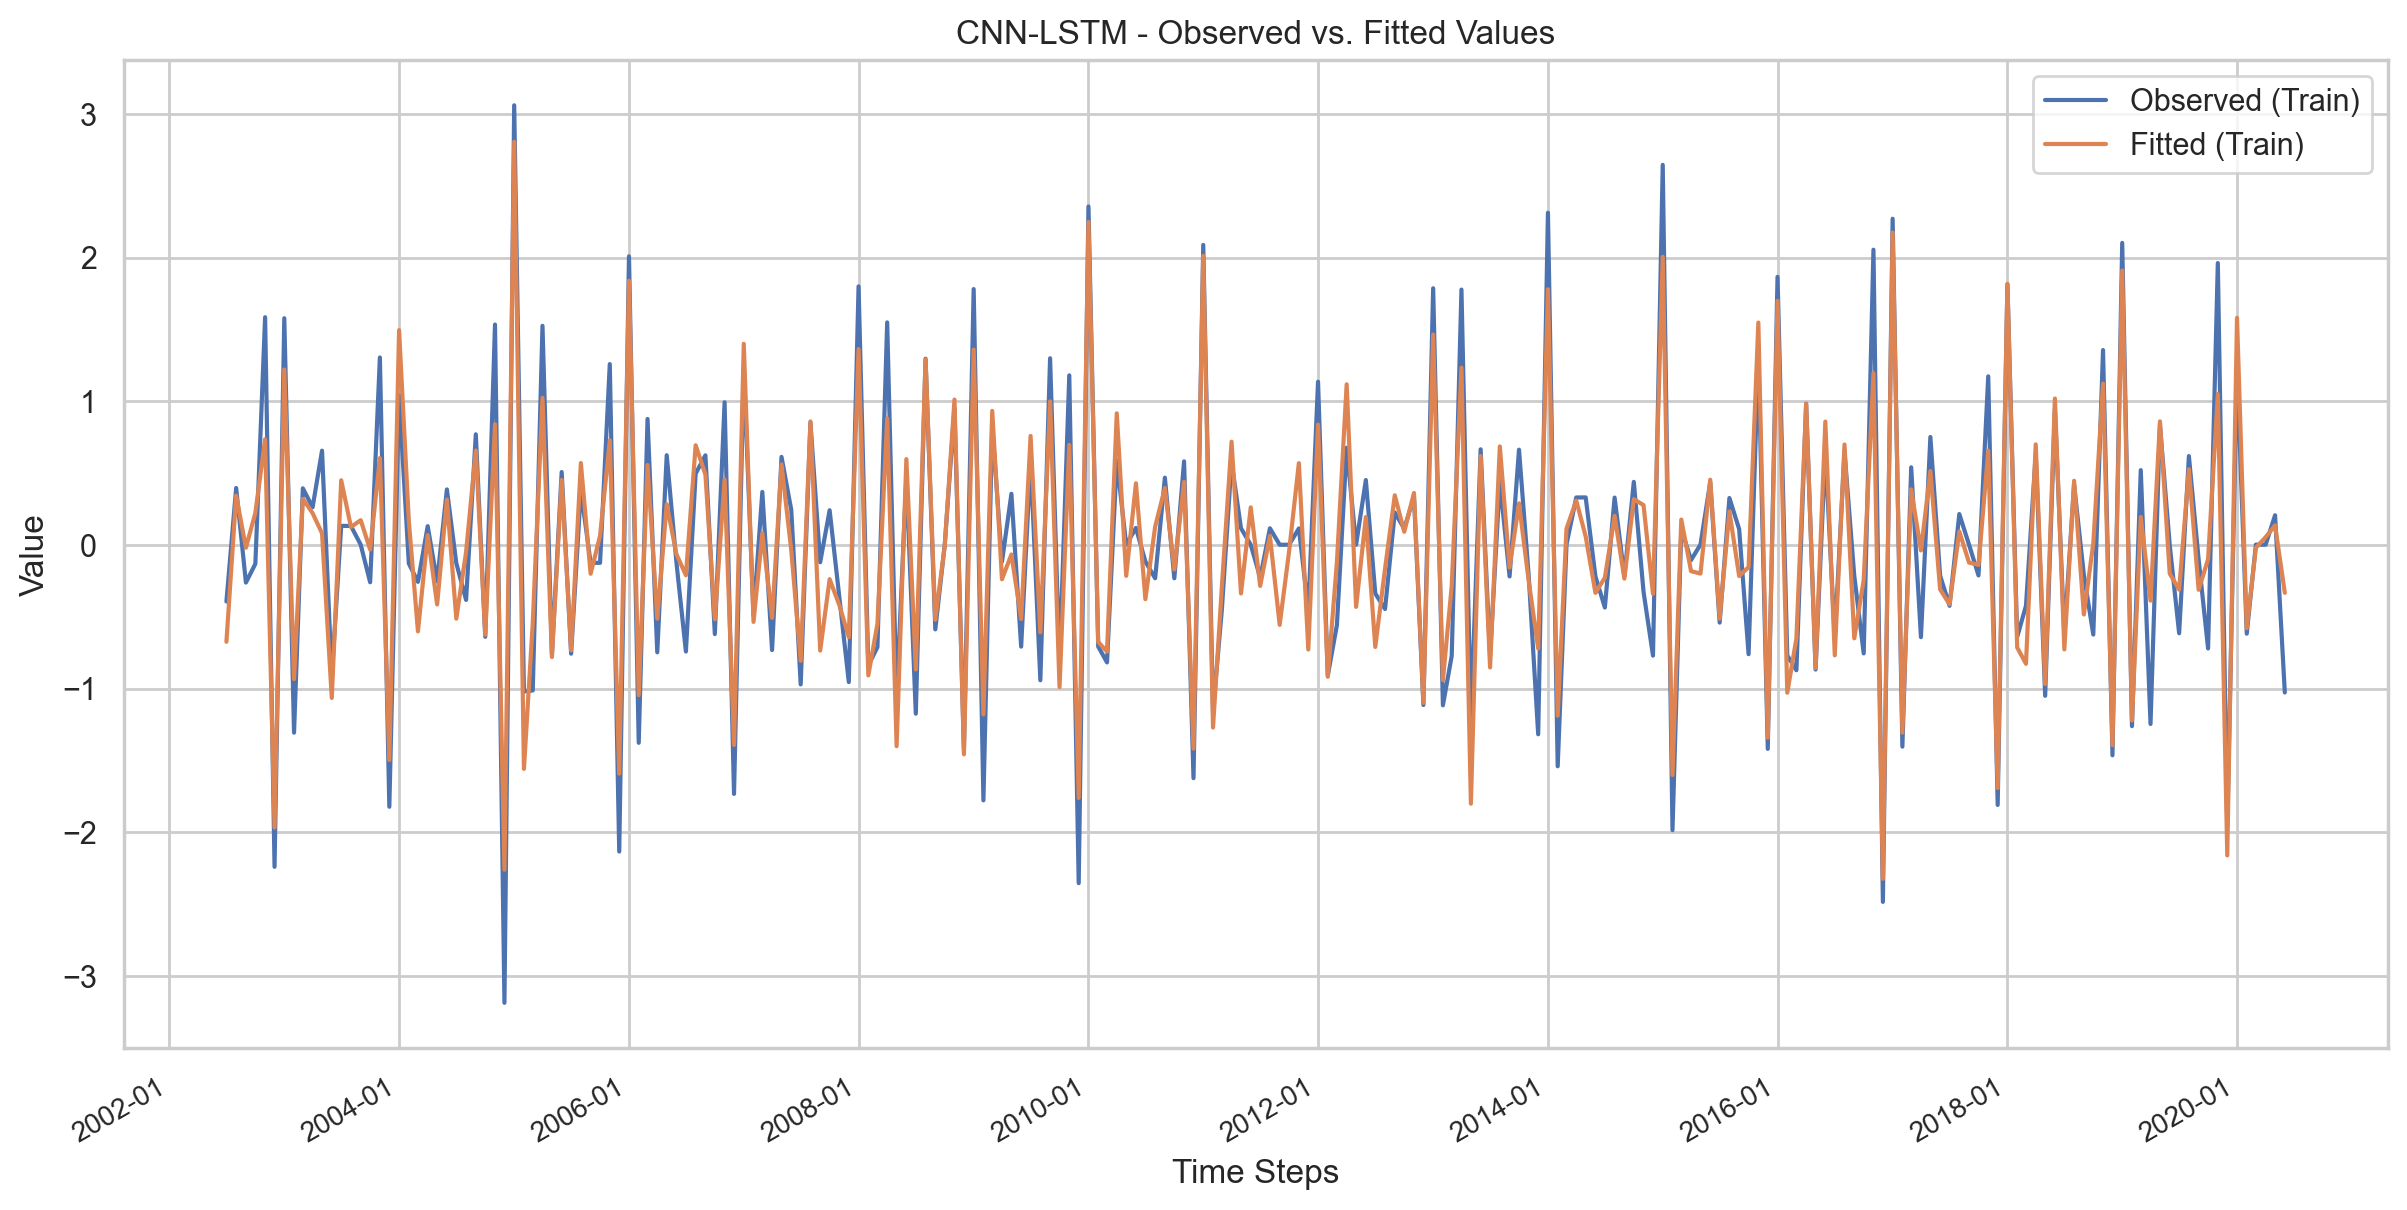

Mean Absolute Error (MAE): 0.47488501
Root Mean Squared Error (RMSE): 0.68839839


In [676]:
df_time_1 = add_time_features(df_main_plus_targ1)
model_C1D_nfe_time, X_train_C1D_nfe_time, X_test_C1D_nfe_time, mae_C1D_nfe_time, rmse_C1D_nfe_time, fnames_C1D_nfe_time = conv1D(df_time_1,target, test_size, 3)

In [668]:
acf_pacf_feature_cols = np.append(cpi_acf_pacf_lag_cols, main_vars_n_target_cols)
print(acf_pacf_feature_cols)

['CPI_L1' 'CPI_L2' 'CPI_L3' 'CPI_L4' 'CPI_L5' 'CPI_L6' 'CPI_L7' 'CPI_L8'
 'CPI_L9' 'CPI_L10' 'CPI_L11' 'CPI_L12' 'CPI_L23' 'CPI_L24' 'CPI_L25'
 'CPI_L35' 'CPI_L36' 'CPI_L37' 'UNERWG' 'ECBIRRO' 'ECBDFR' 'ECBMLFR' 'MMR'
 'CPI' 'RETAILMV' 'RETAILXMV' 'RETAILGSR' 'RETAILGF' 'GOODFBT' 'AGRPROD'
 'PPIIP' 'WPI' 'EPI' 'IPI' 'HICP' 'LTIR' 'UR' 'DAX' 'STOXX50E' 'EW'
 'CPI_t+1']


CNN Model - Mean Absolute Error (MAE):  0.4326
CNN Model - Root Mean Squared Error (RMSE):  0.6007


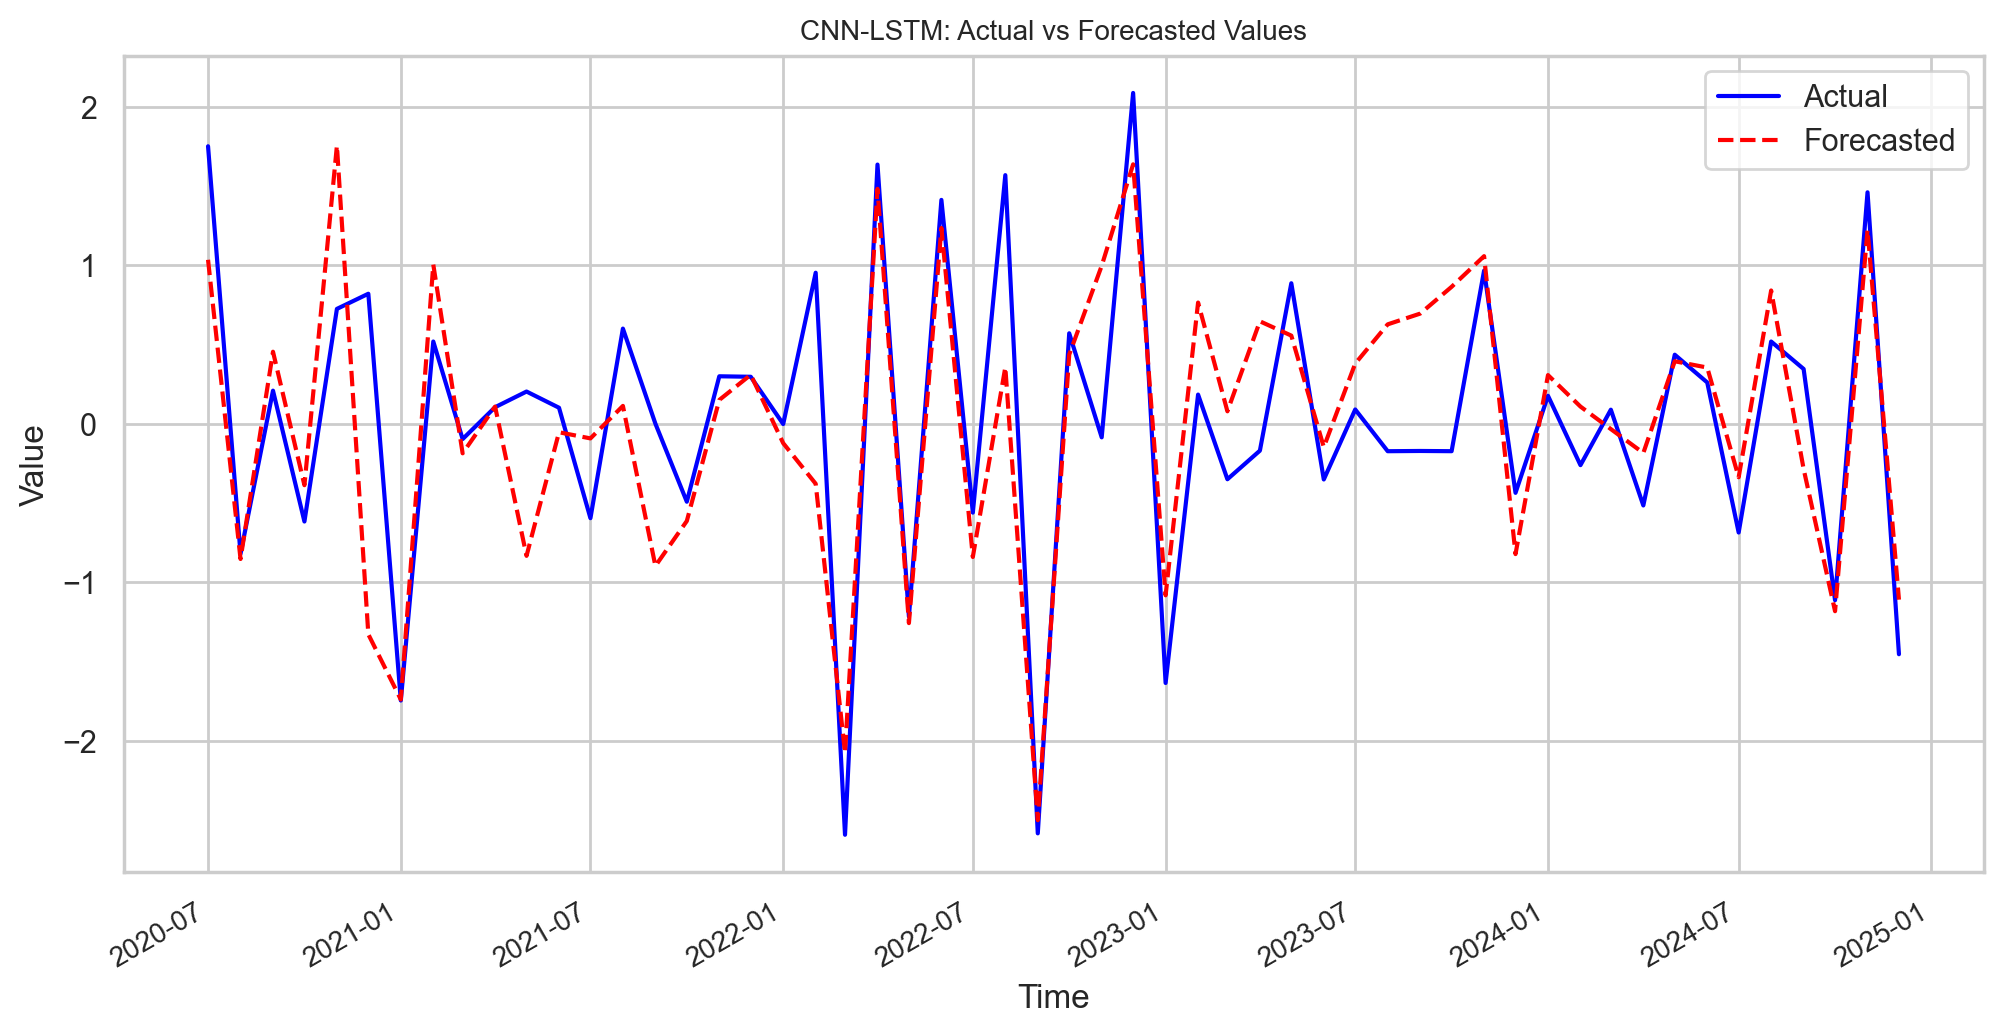

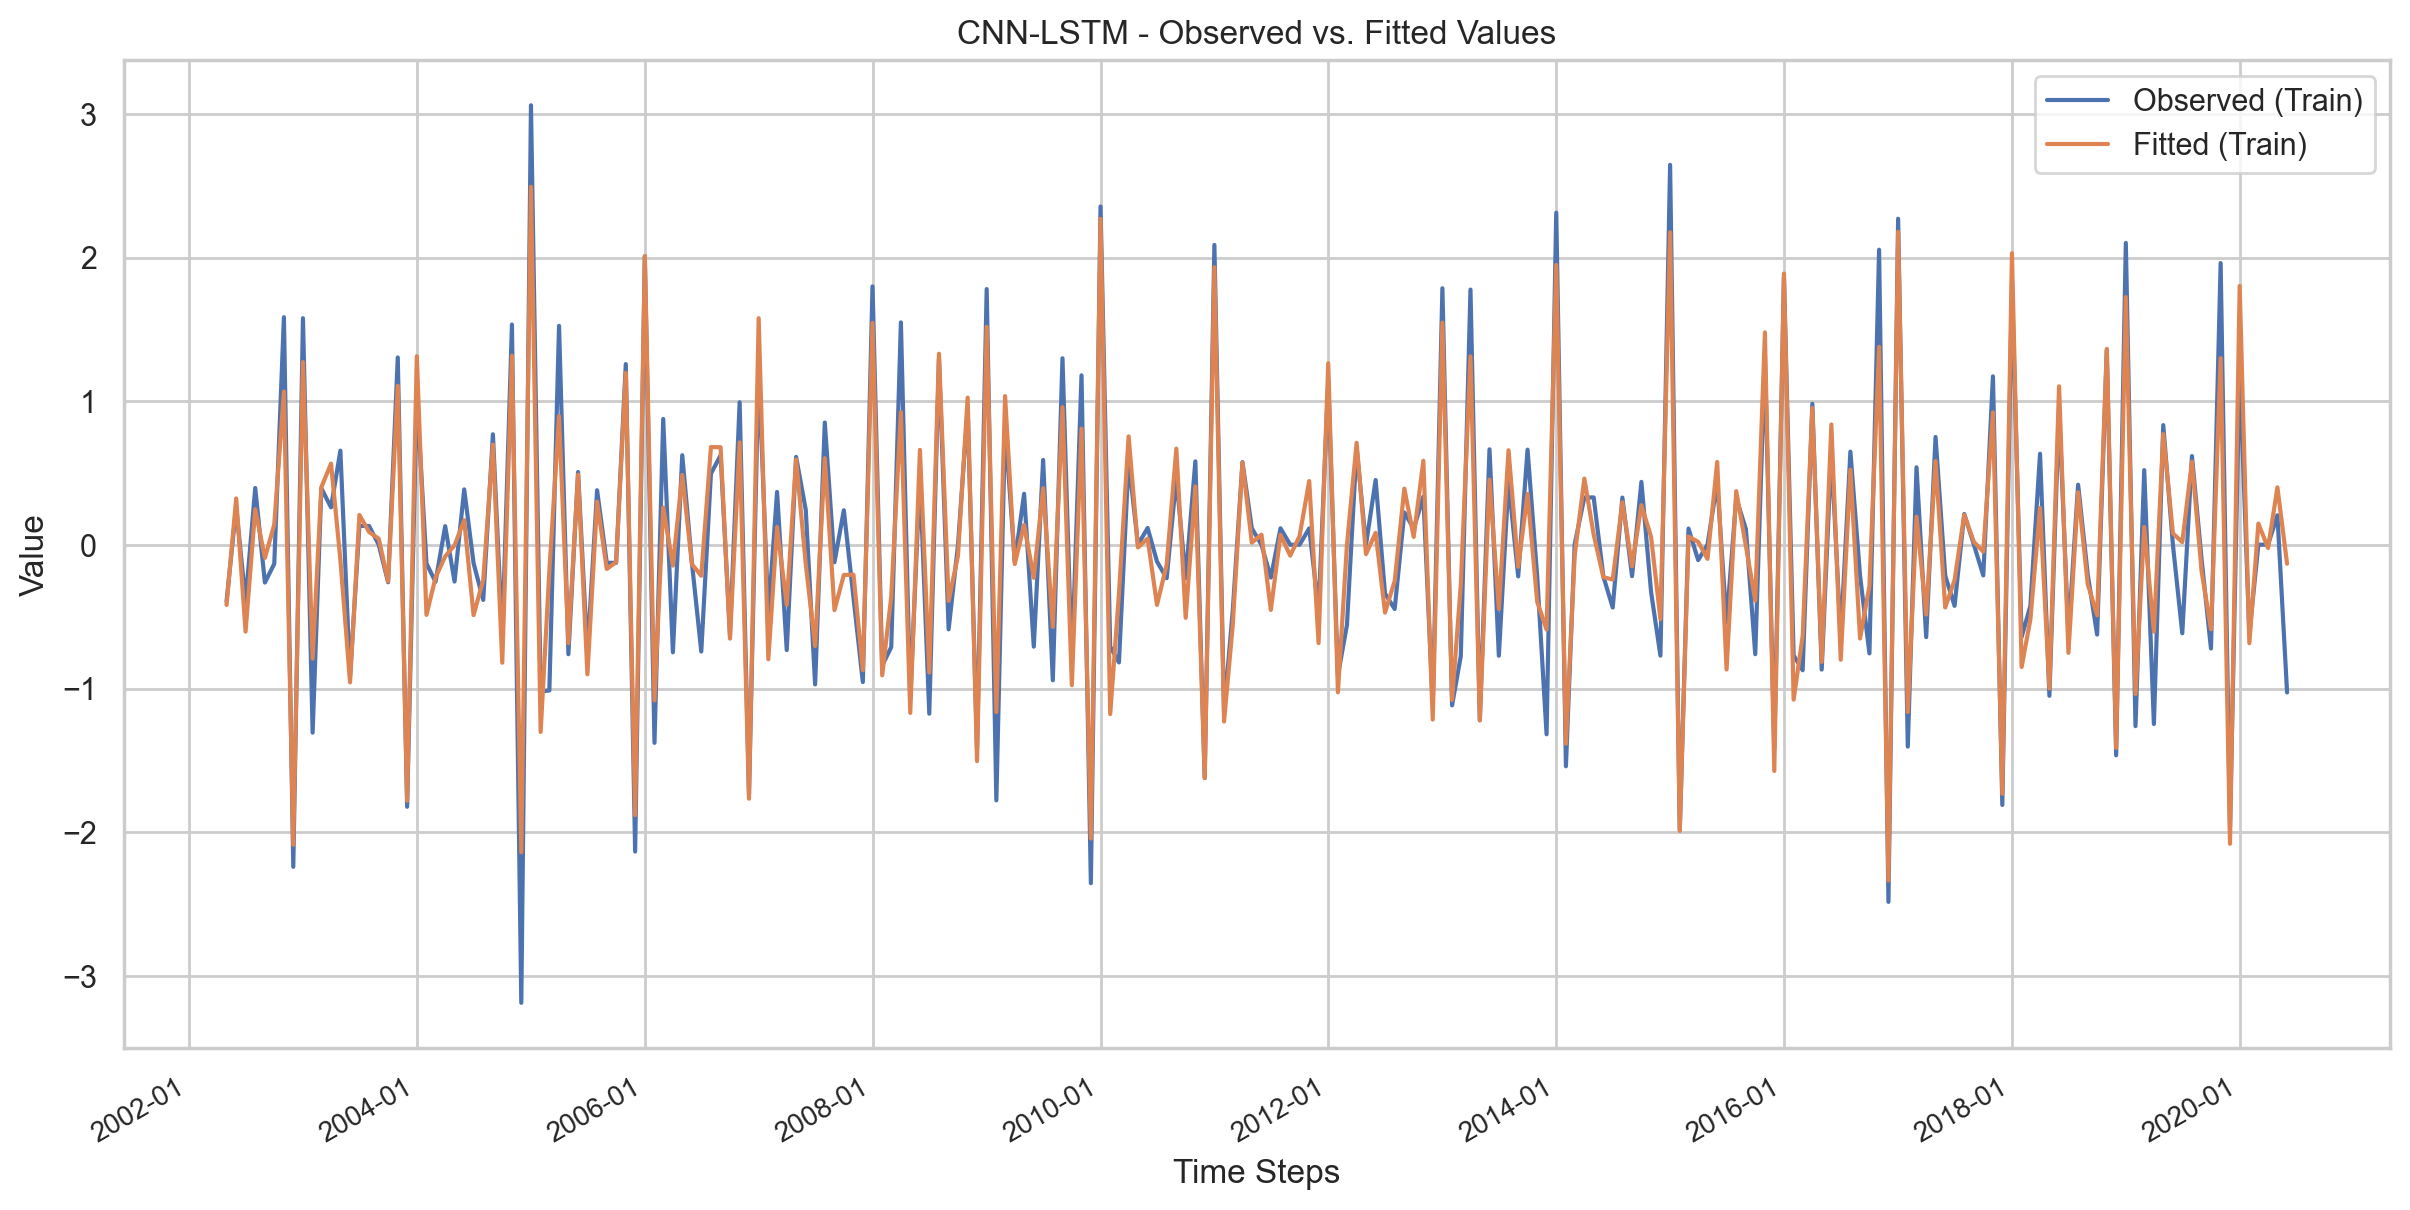

Mean Absolute Error (MAE): 0.43260662
Root Mean Squared Error (RMSE): 0.60073466


In [669]:
df_acf_pacf = df_cpi_target[acf_pacf_feature_cols]
model_C1D_acf, X_train_C1D_acf, X_test_C1D_acf, mae_C1D_acf, rmse_C1D_acf, fnames_C1D_acf = conv1D(df_acf_pacf, target, test_size, 1)

CNN Model - Mean Absolute Error (MAE):  0.4263
CNN Model - Root Mean Squared Error (RMSE):  0.5793


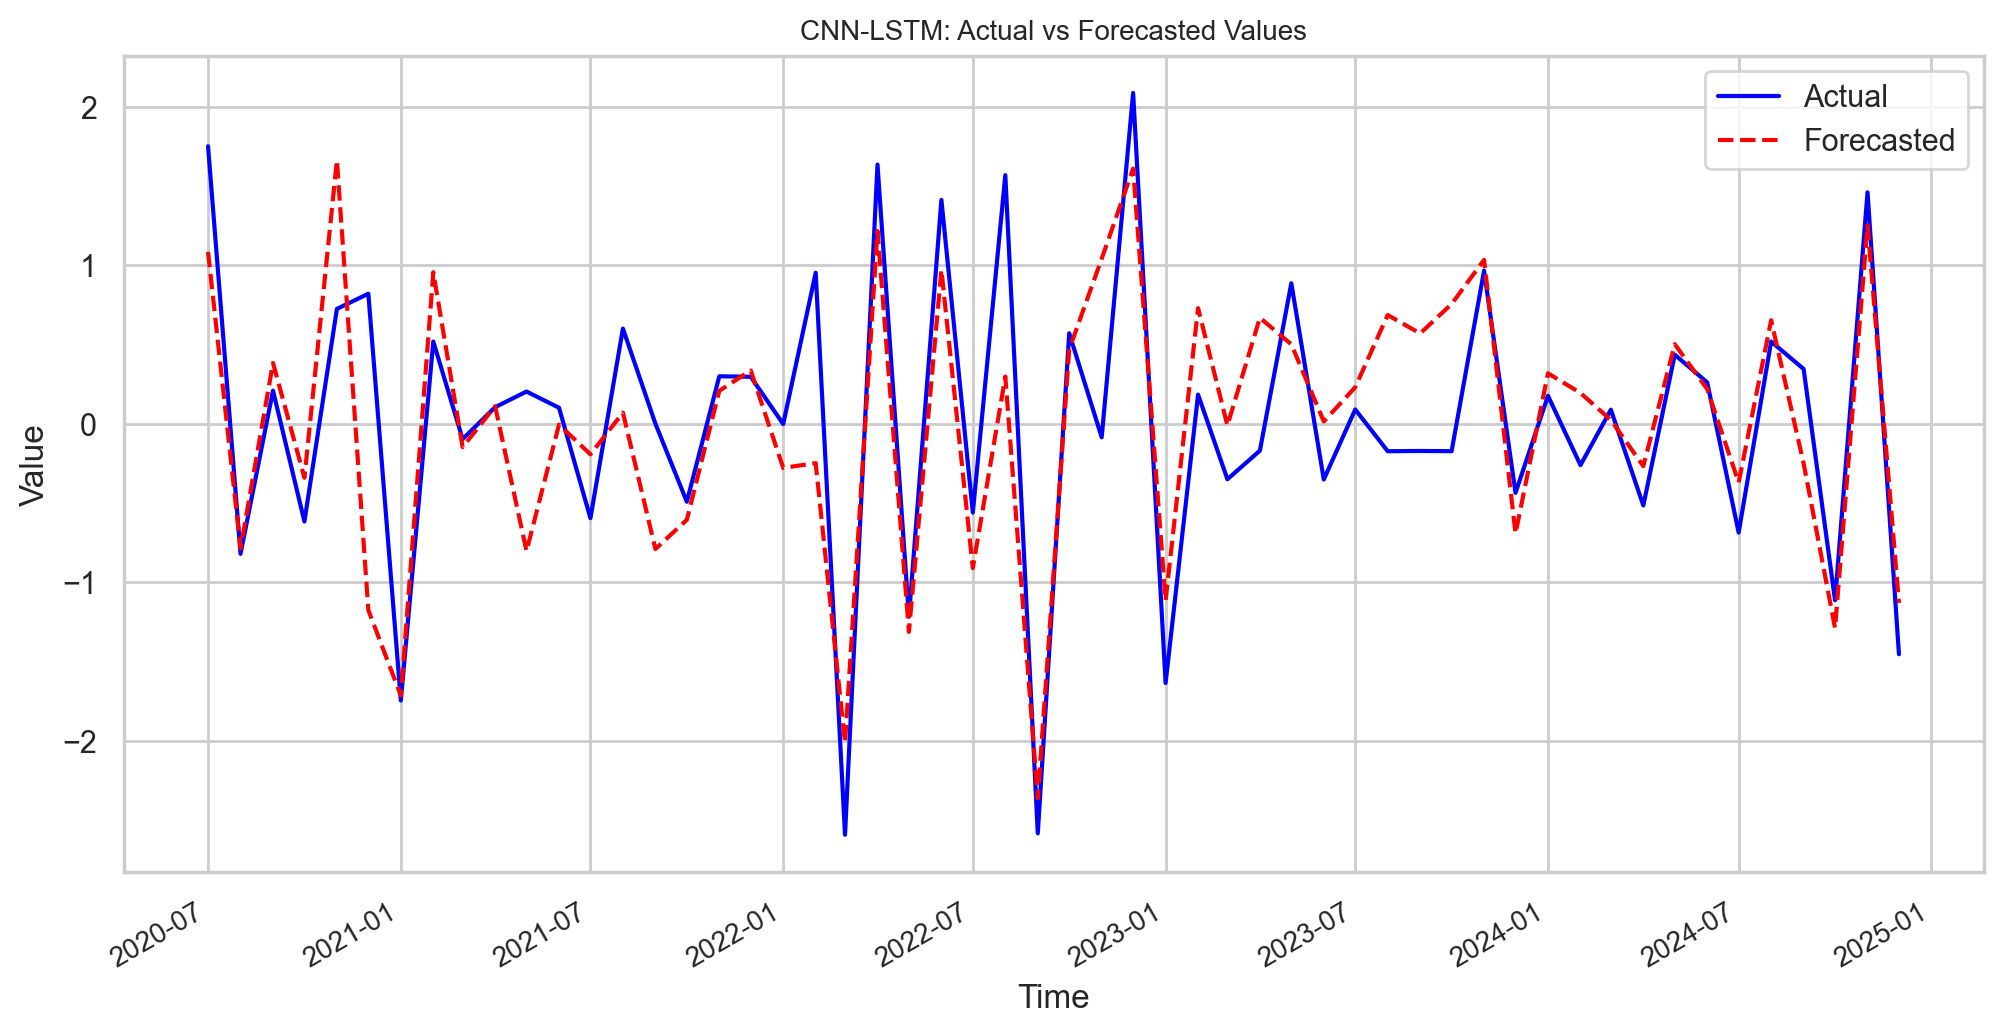

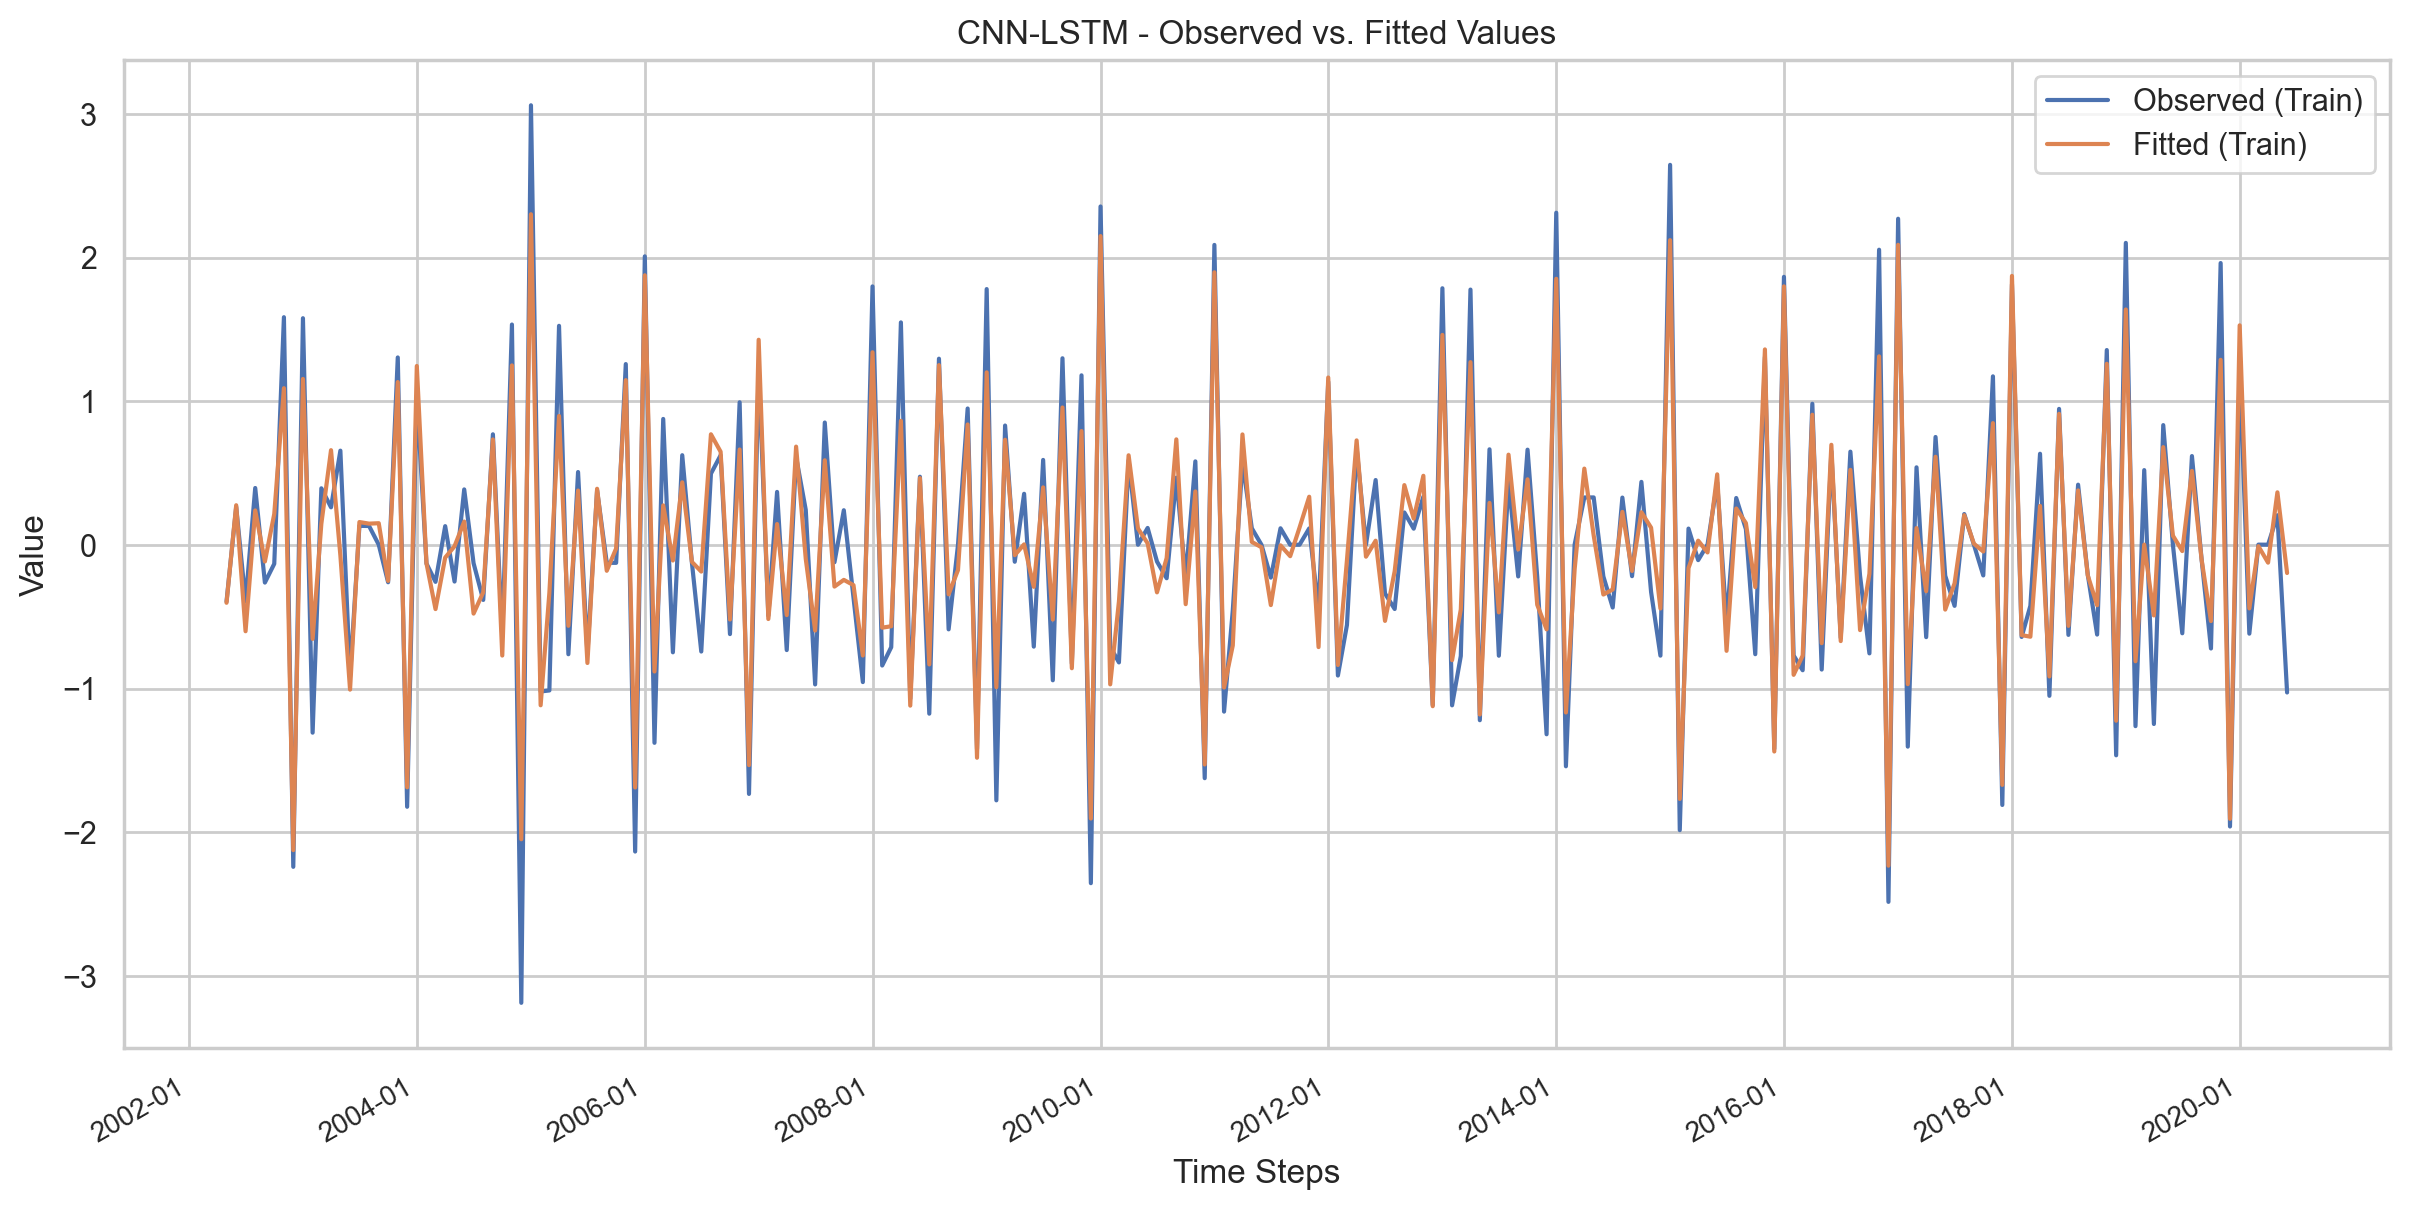

Mean Absolute Error (MAE): 0.42629377
Root Mean Squared Error (RMSE): 0.57931332


In [677]:
df_time = add_time_features(df_acf_pacf)
model_C1D_acf, X_train_C1D_acf, X_test_C1D_acf, mae_C1D_acf, rmse_C1D_acf, fnames_C1D_acf = conv1D(df_time, target, test_size, 1)

CNN Model - Mean Absolute Error (MAE):  0.7150
CNN Model - Root Mean Squared Error (RMSE):  0.9383


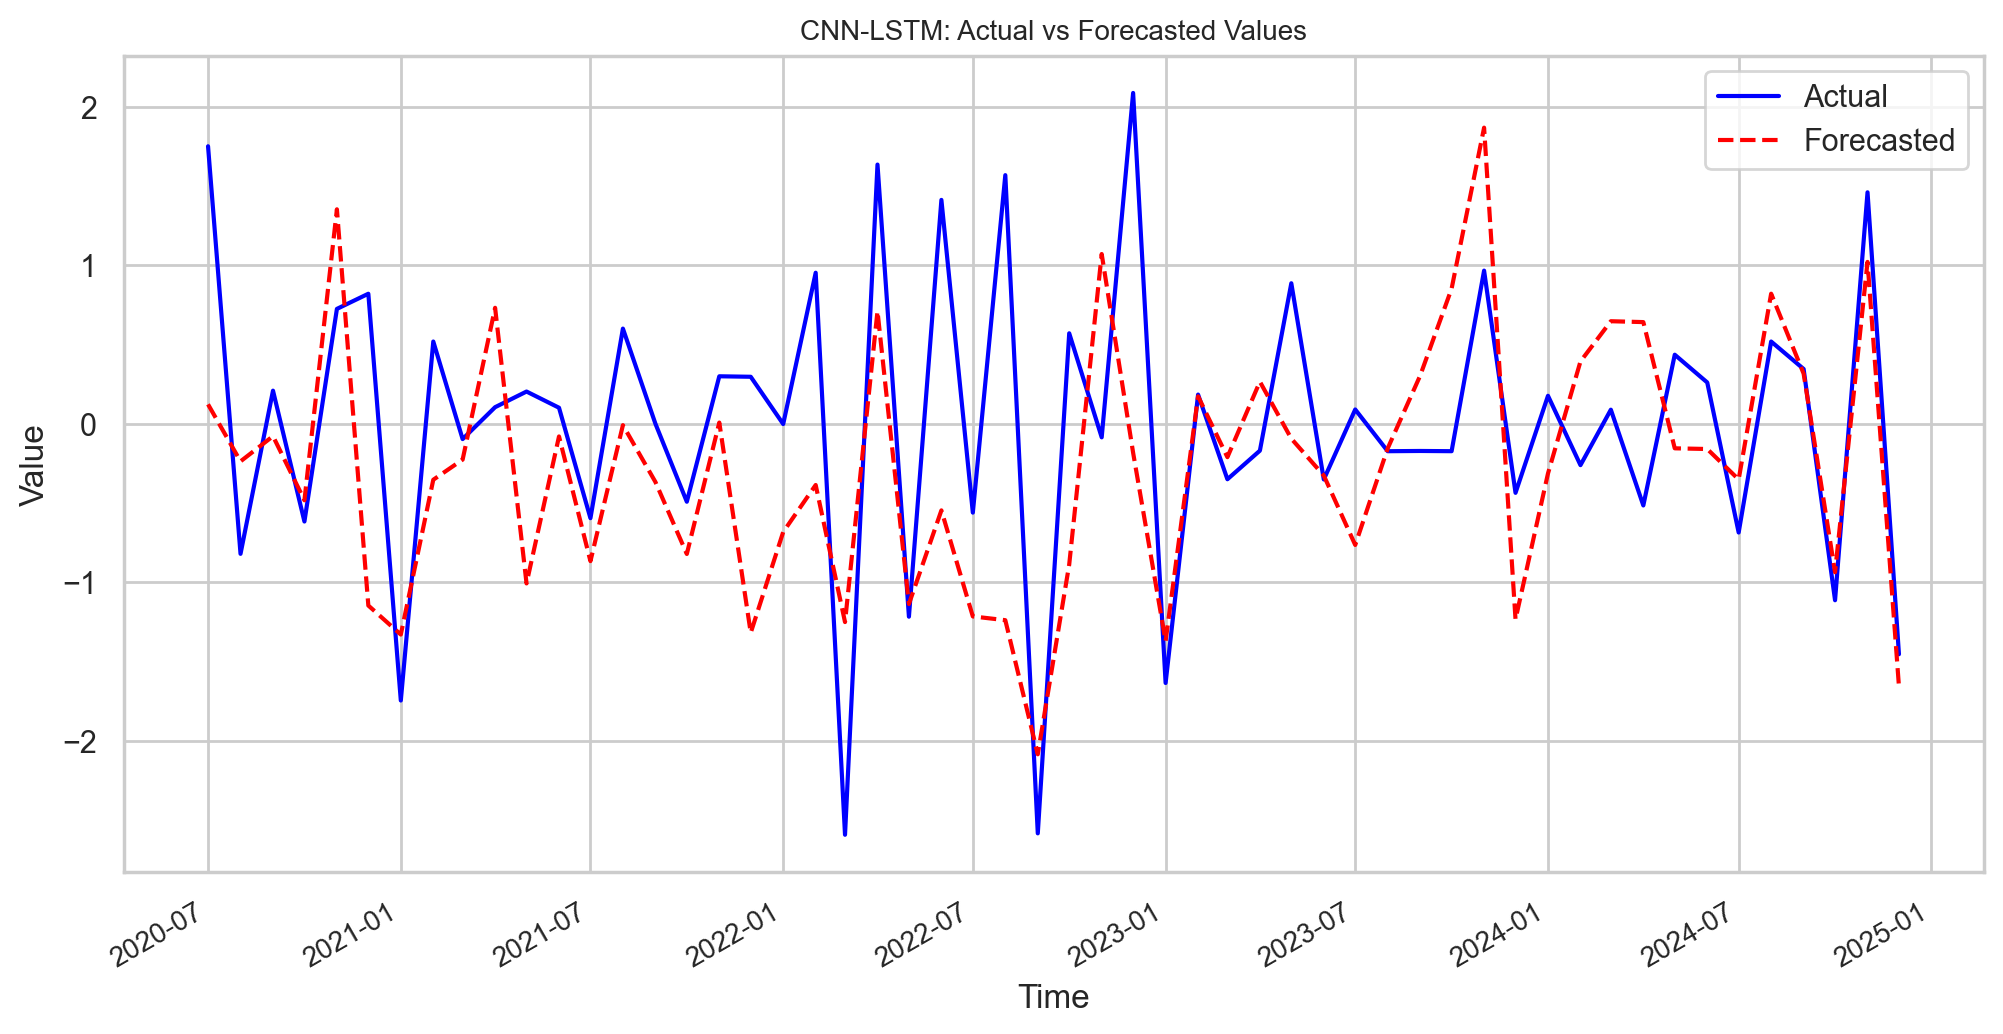

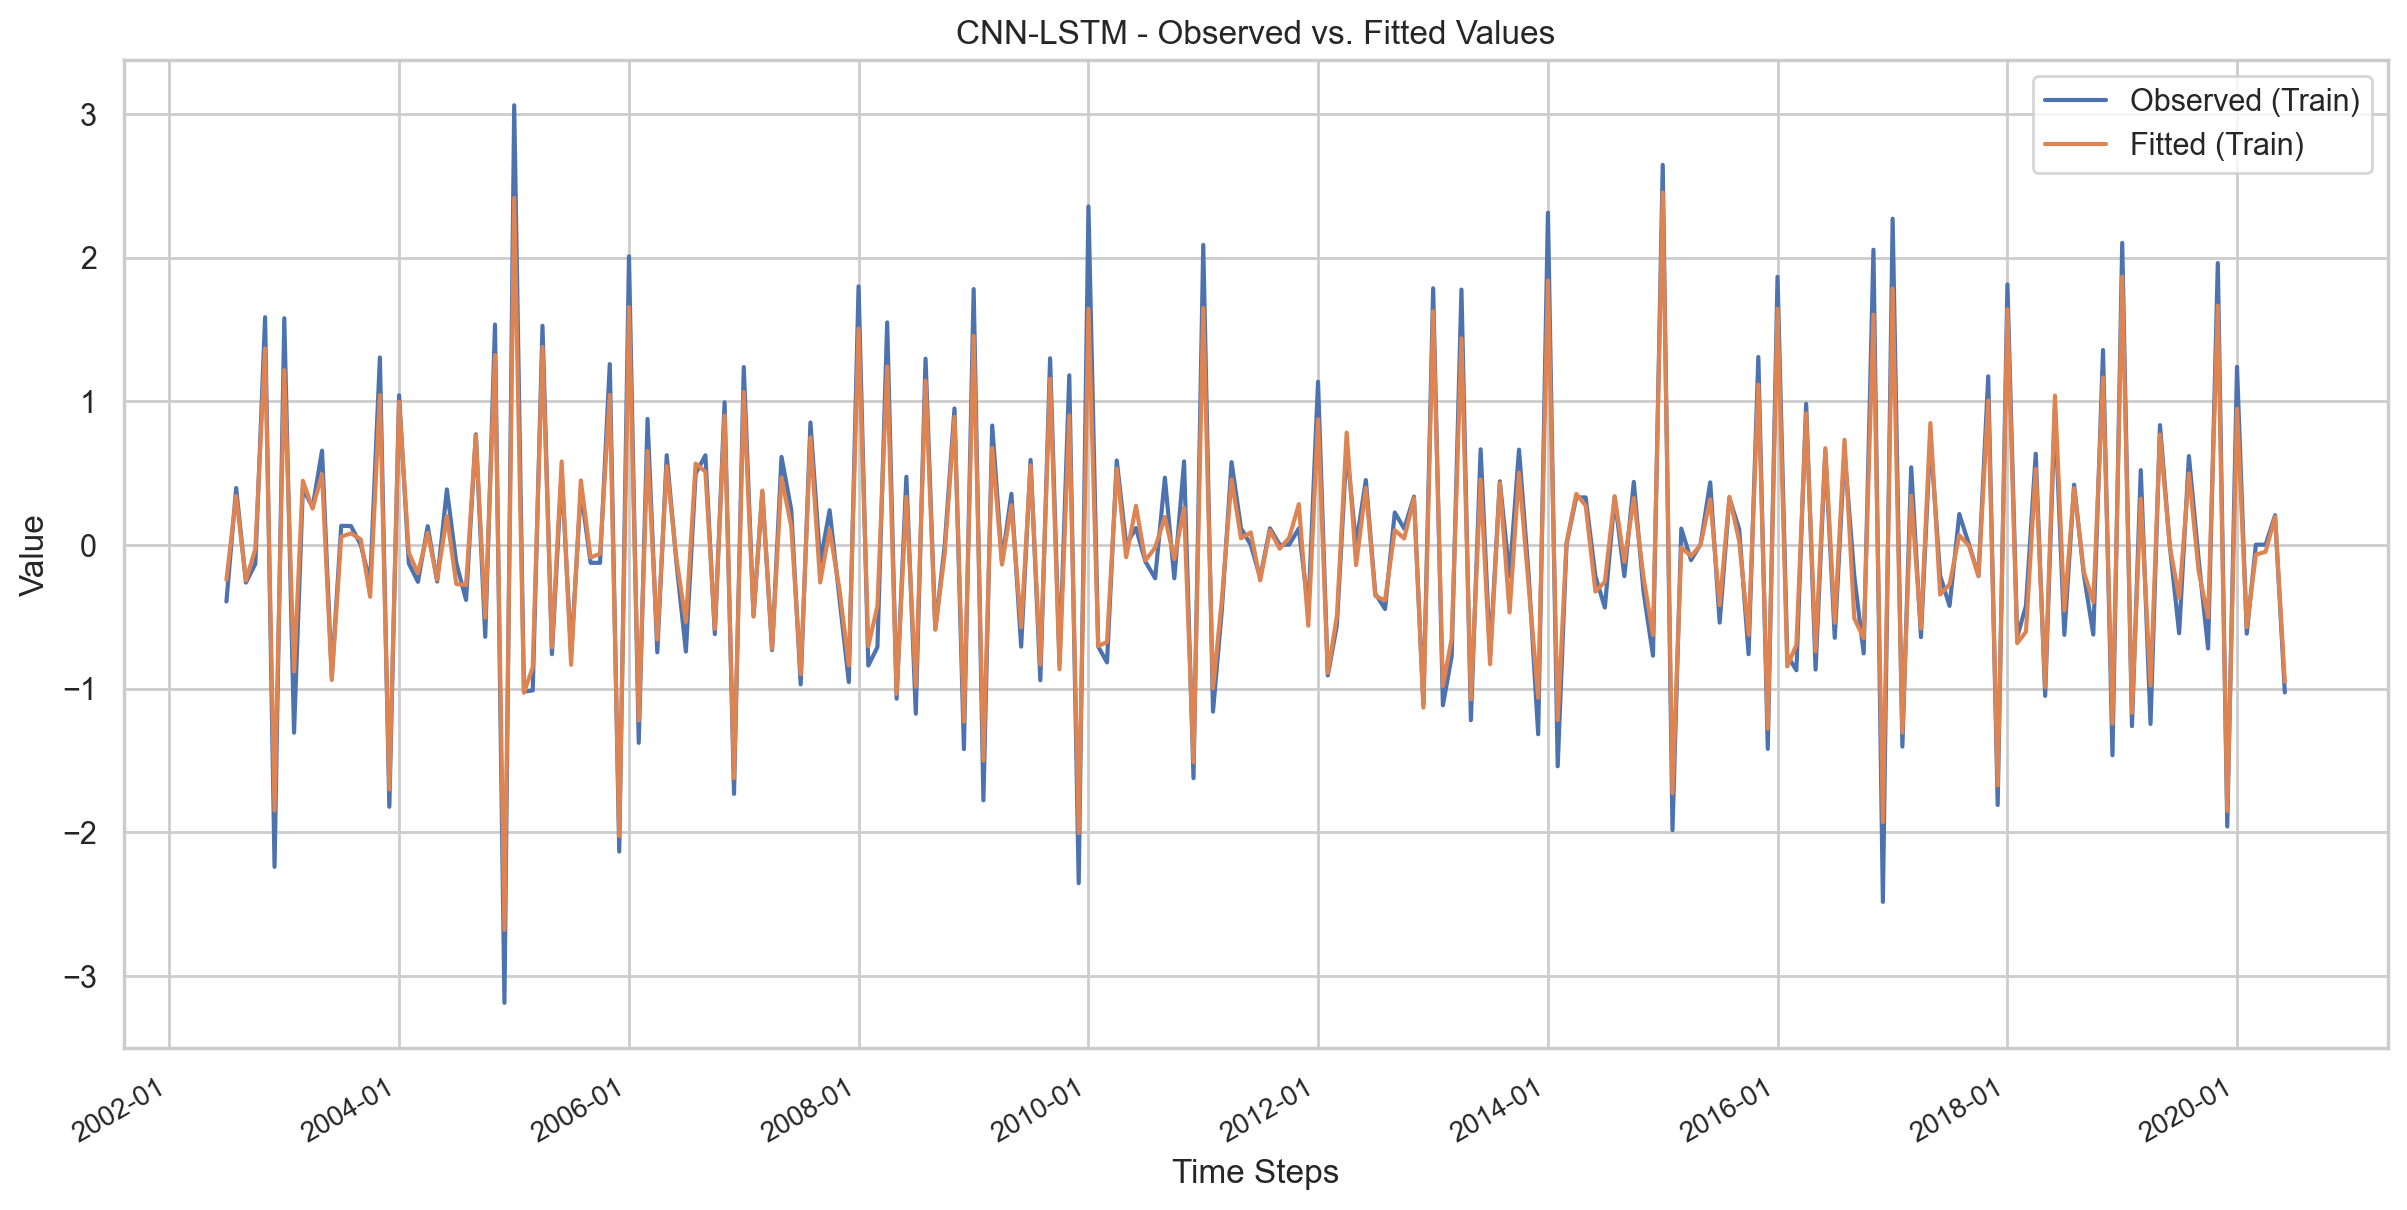

Mean Absolute Error (MAE): 0.71502106
Root Mean Squared Error (RMSE): 0.93832697


In [679]:
model_CL1D_nfe, X_train_CL1D_nfe, X_test_CL1D_nfe, mae_CL1D_nfe, rmse_CL1D_nfe, fnames_CL1D_nfe = convlstm1D(df_main_plus_targ1, target, test_size, 3)

CNN Model - Mean Absolute Error (MAE):  0.5451
CNN Model - Root Mean Squared Error (RMSE):  0.7083


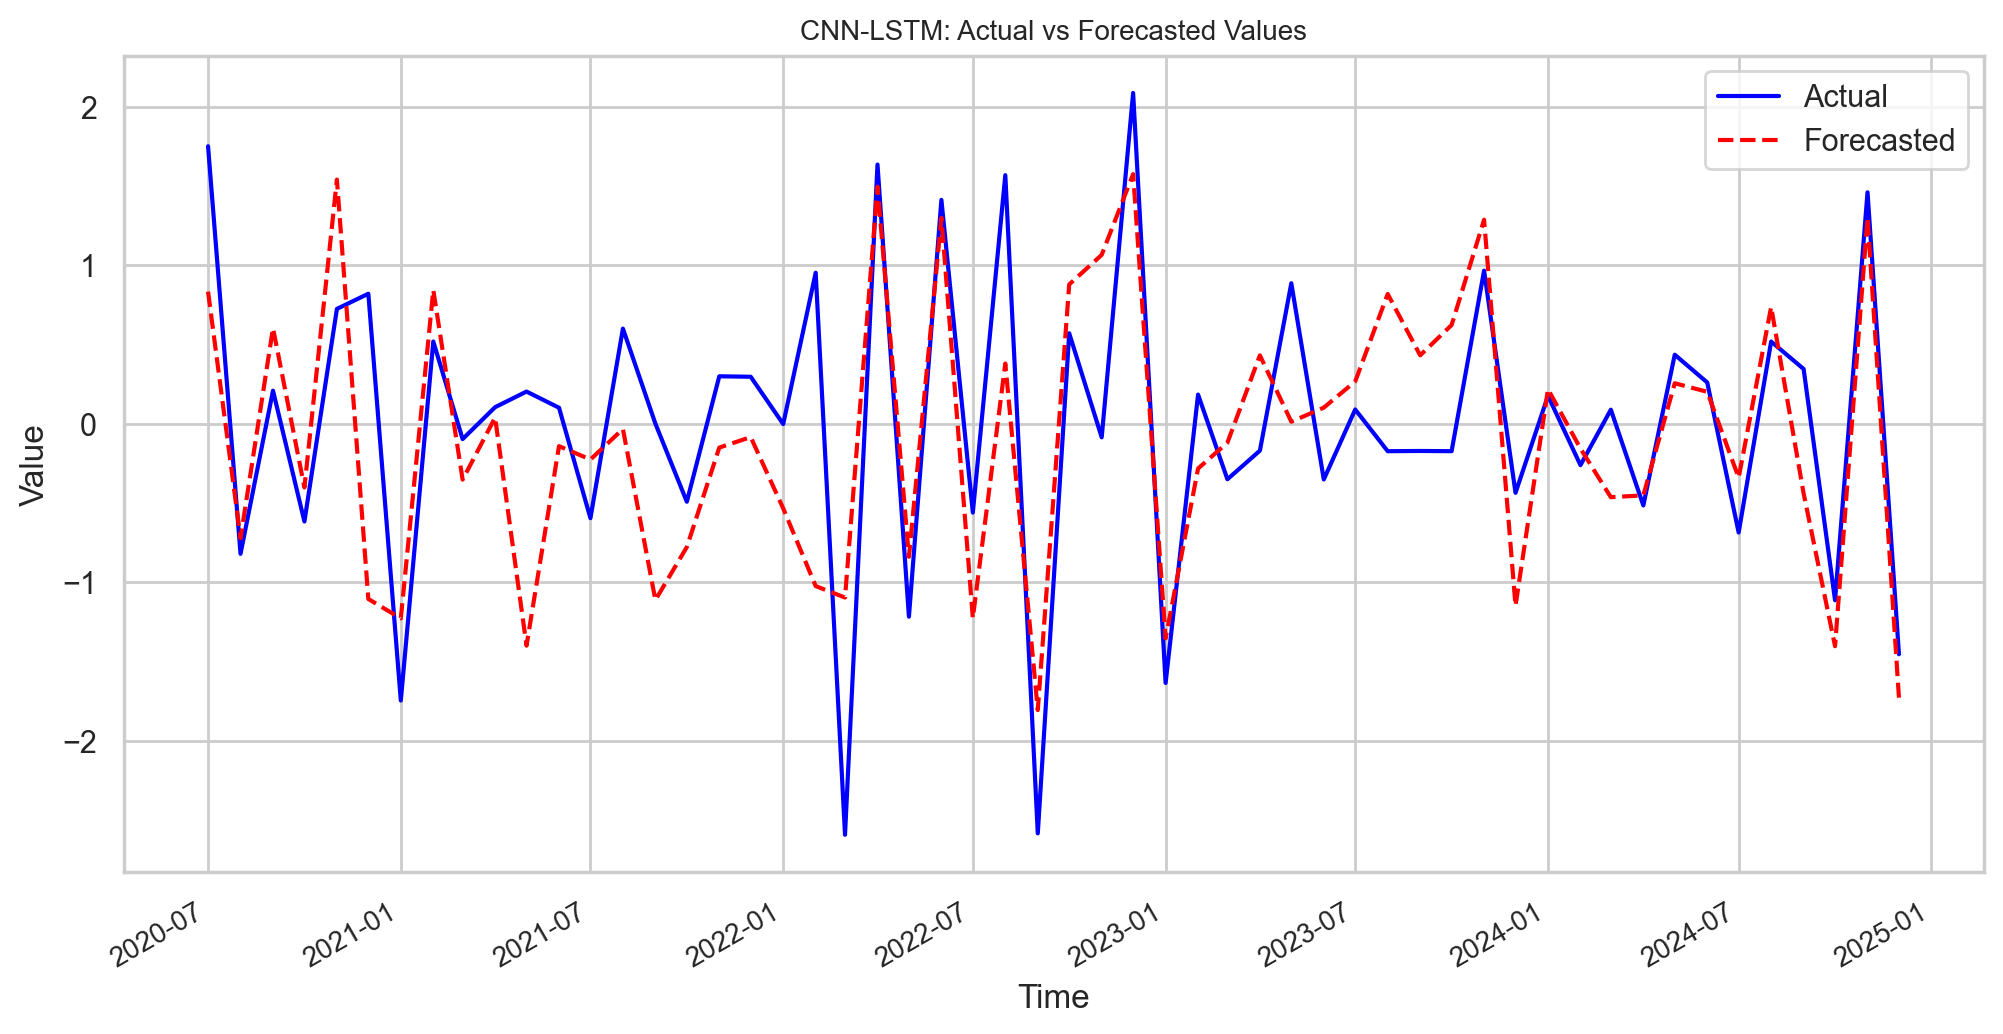

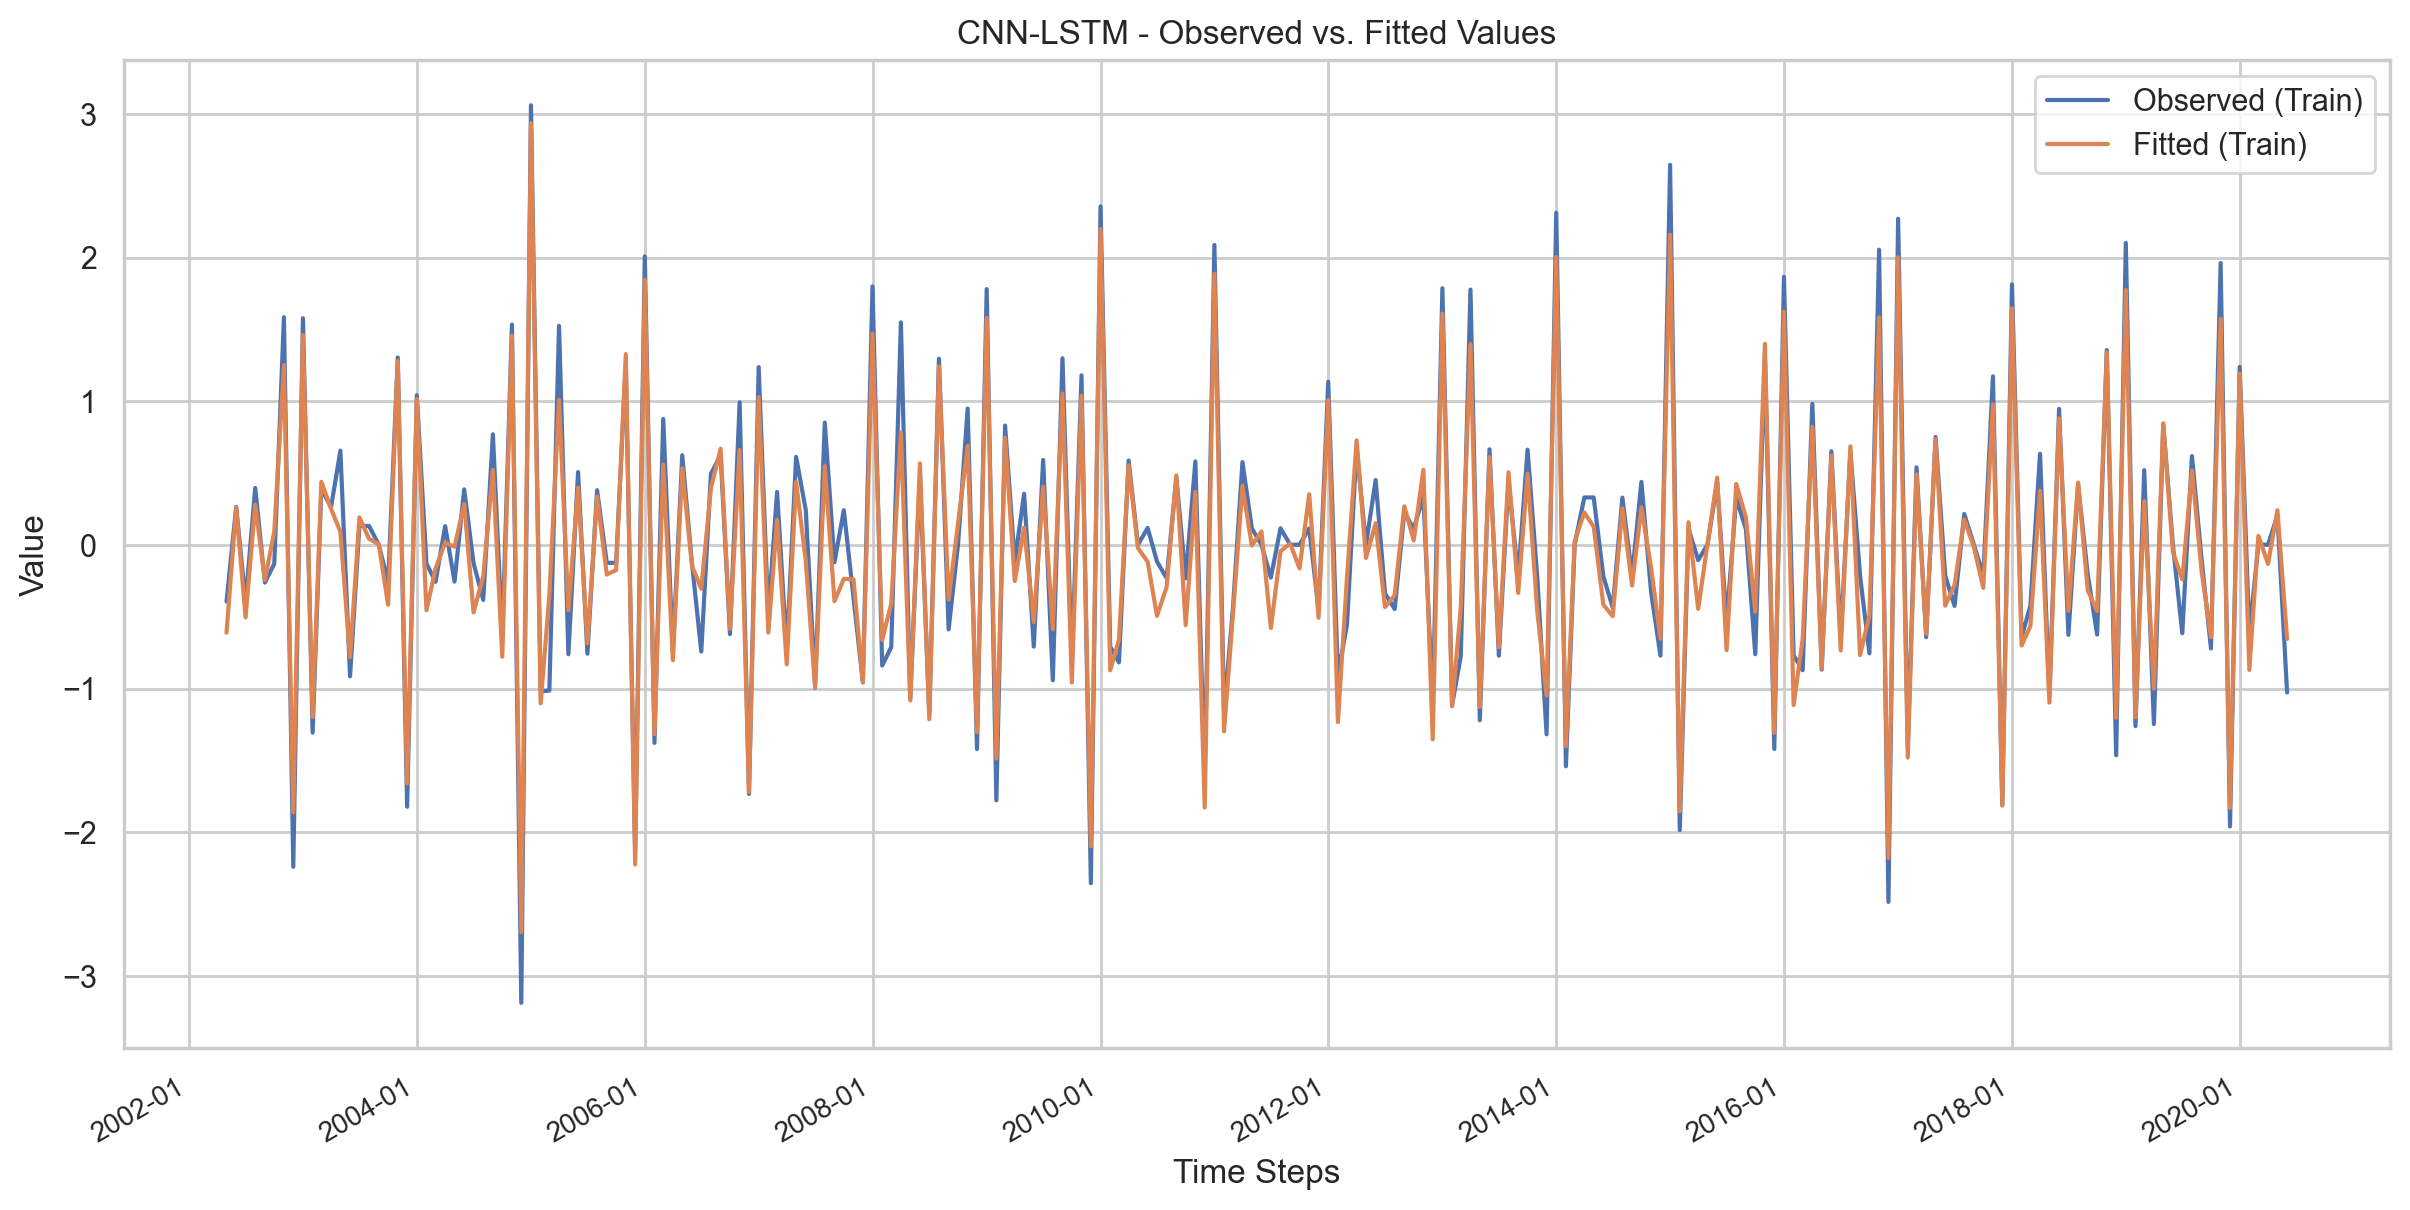

Mean Absolute Error (MAE): 0.54512608
Root Mean Squared Error (RMSE): 0.70833741


In [680]:
model_CL1D_acf, X_train_CL1D_acf, X_test_CL1D_acf, mae_CL1D_acf, rmse_CL1D_acf, fnames_CL1D_acf = convlstm1D(df_acf_pacf, target, test_size, 1)

CNN Model - Mean Absolute Error (MAE):  0.6350
CNN Model - Root Mean Squared Error (RMSE):  0.7872


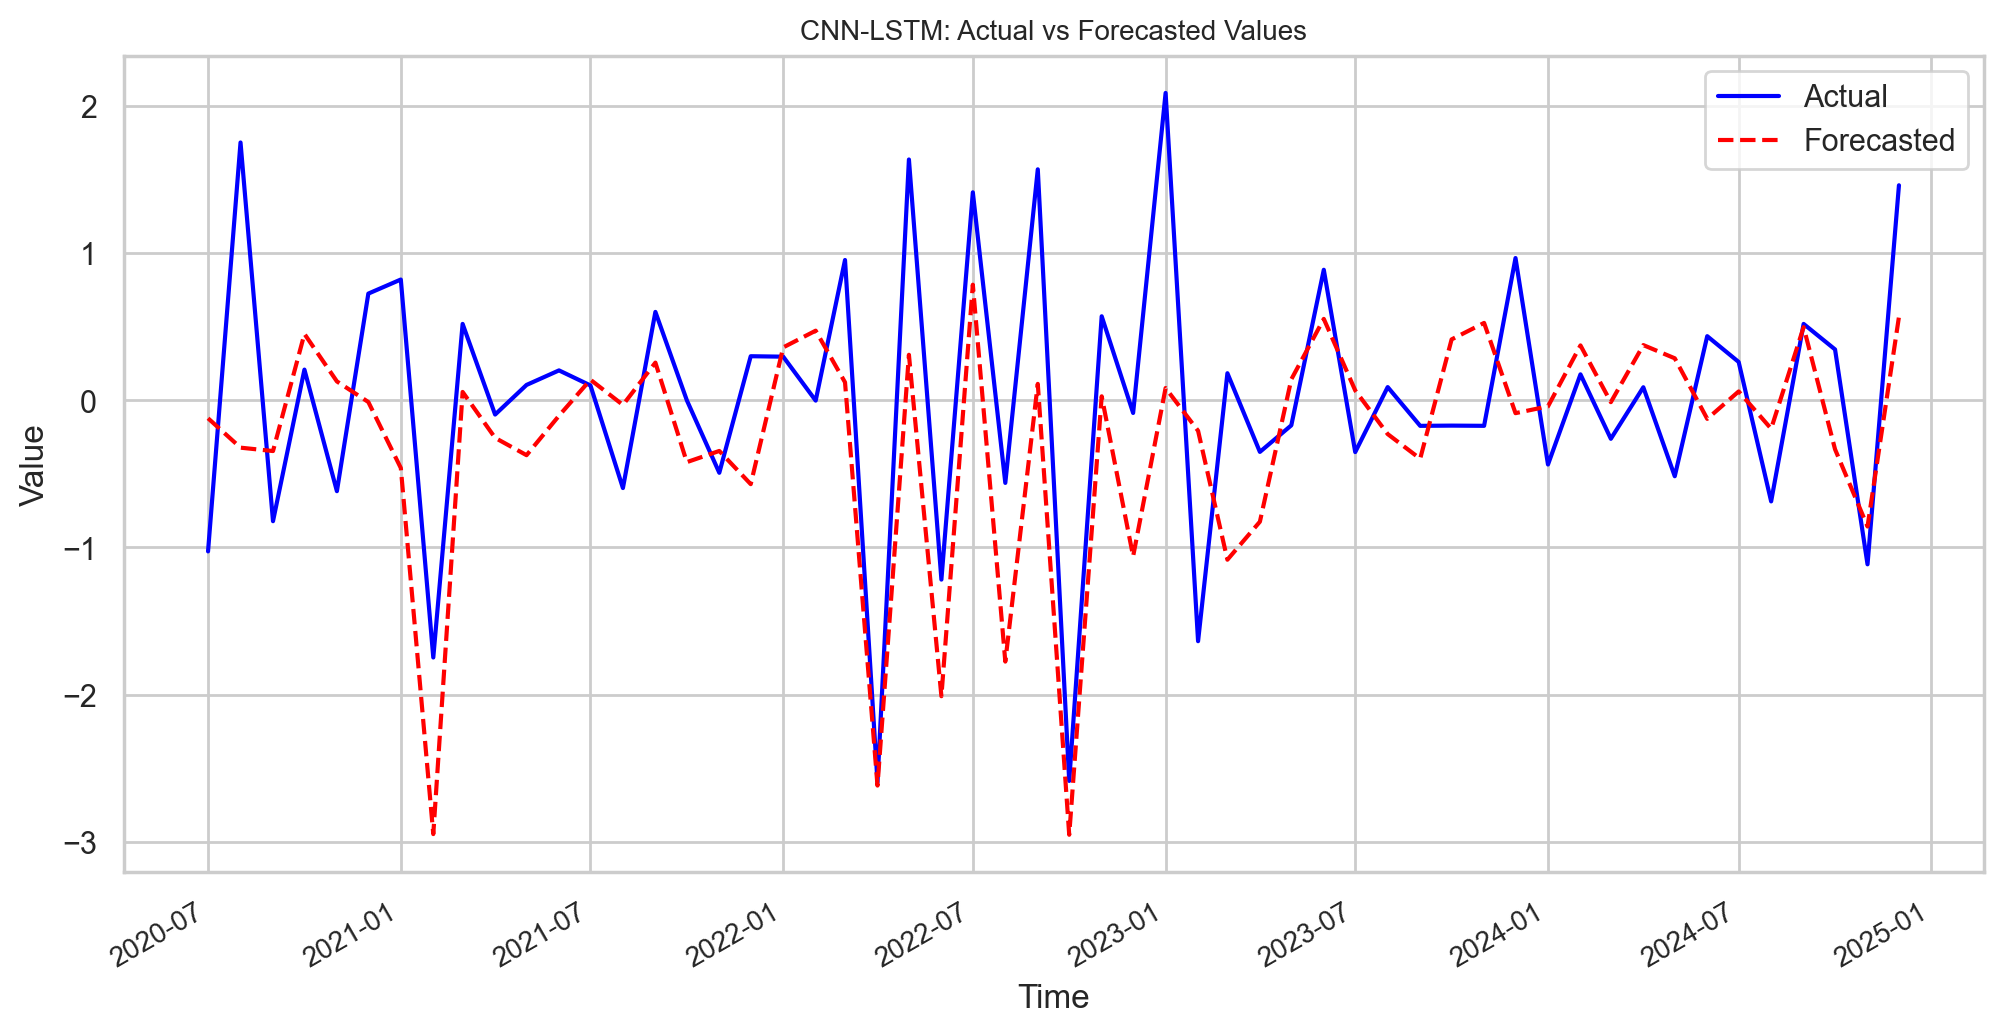

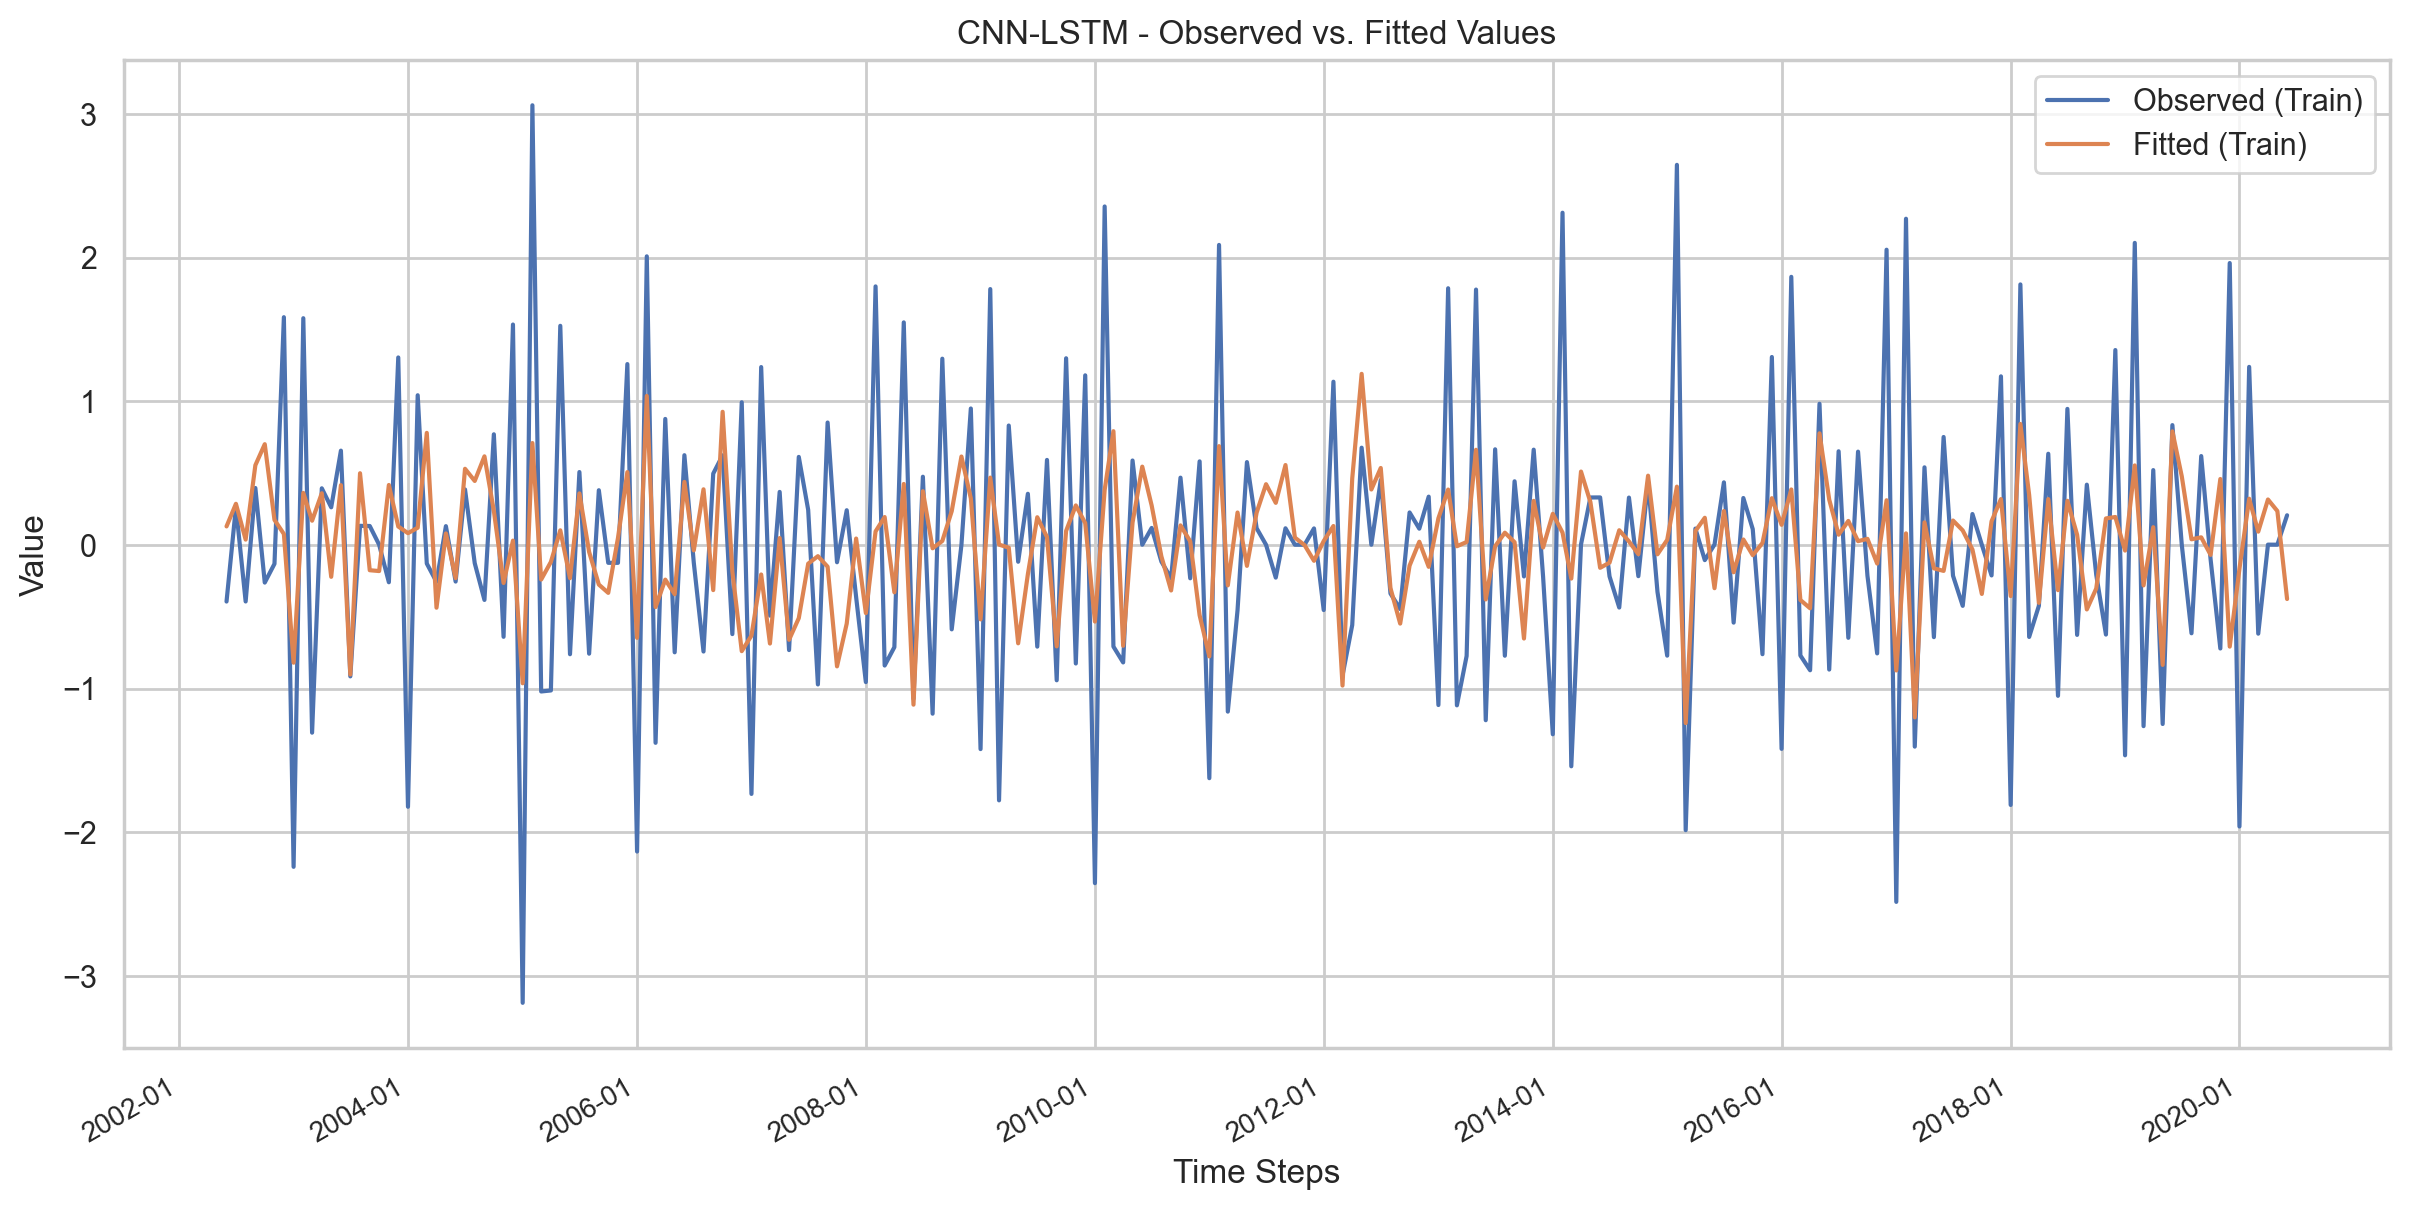

Mean Absolute Error (MAE): 0.63496415
Root Mean Squared Error (RMSE): 0.78722543


In [684]:
df_cpi_vae = df_cpi_target[vae_cpi_cols]
# print(df_cpi_vae.columns)
model_CL2D_vae, X_train_CL2D_vae, X_test_CL2D_vae, mae_CL2D_vae, rmse_CL2D_vae, fnames_CL2D_vae = convlstm2D(df_cpi_vae, target, test_size, 1)

CNN Model - Mean Absolute Error (MAE):  0.7498
CNN Model - Root Mean Squared Error (RMSE):  0.9434


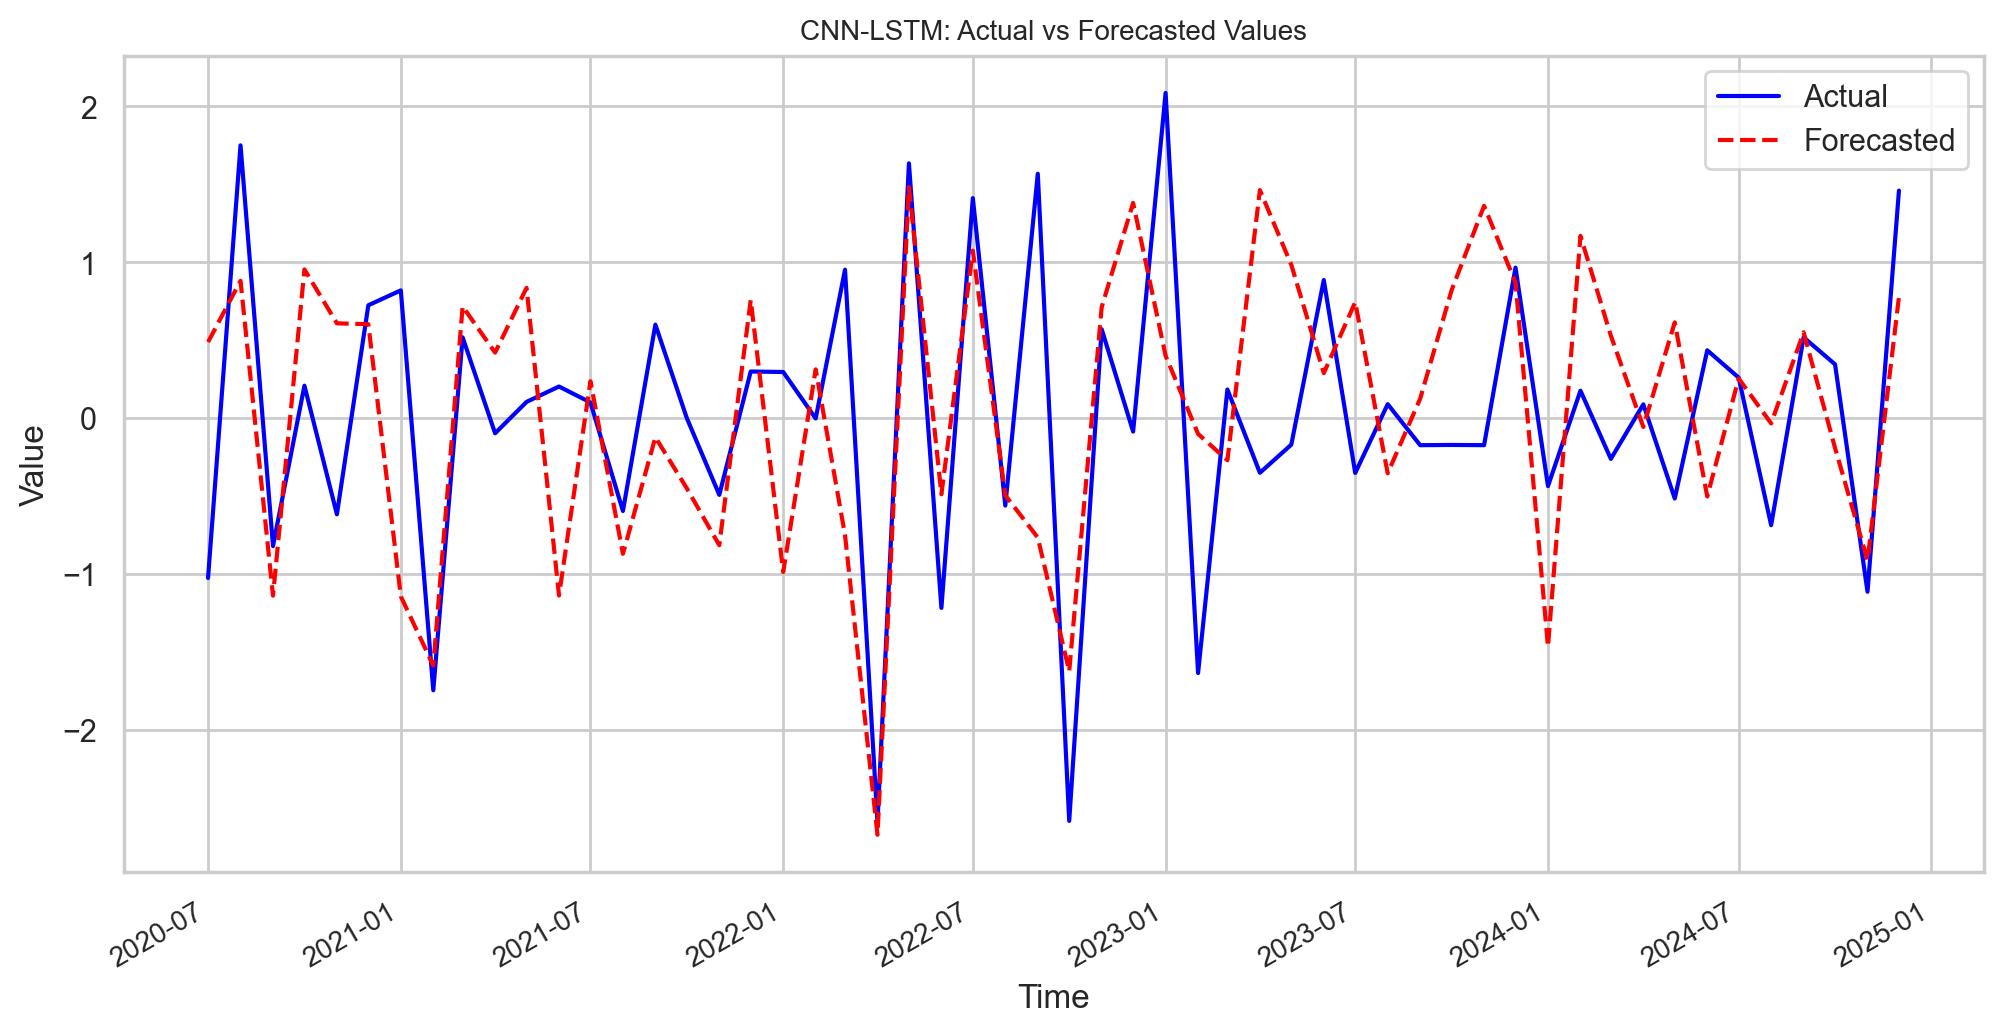

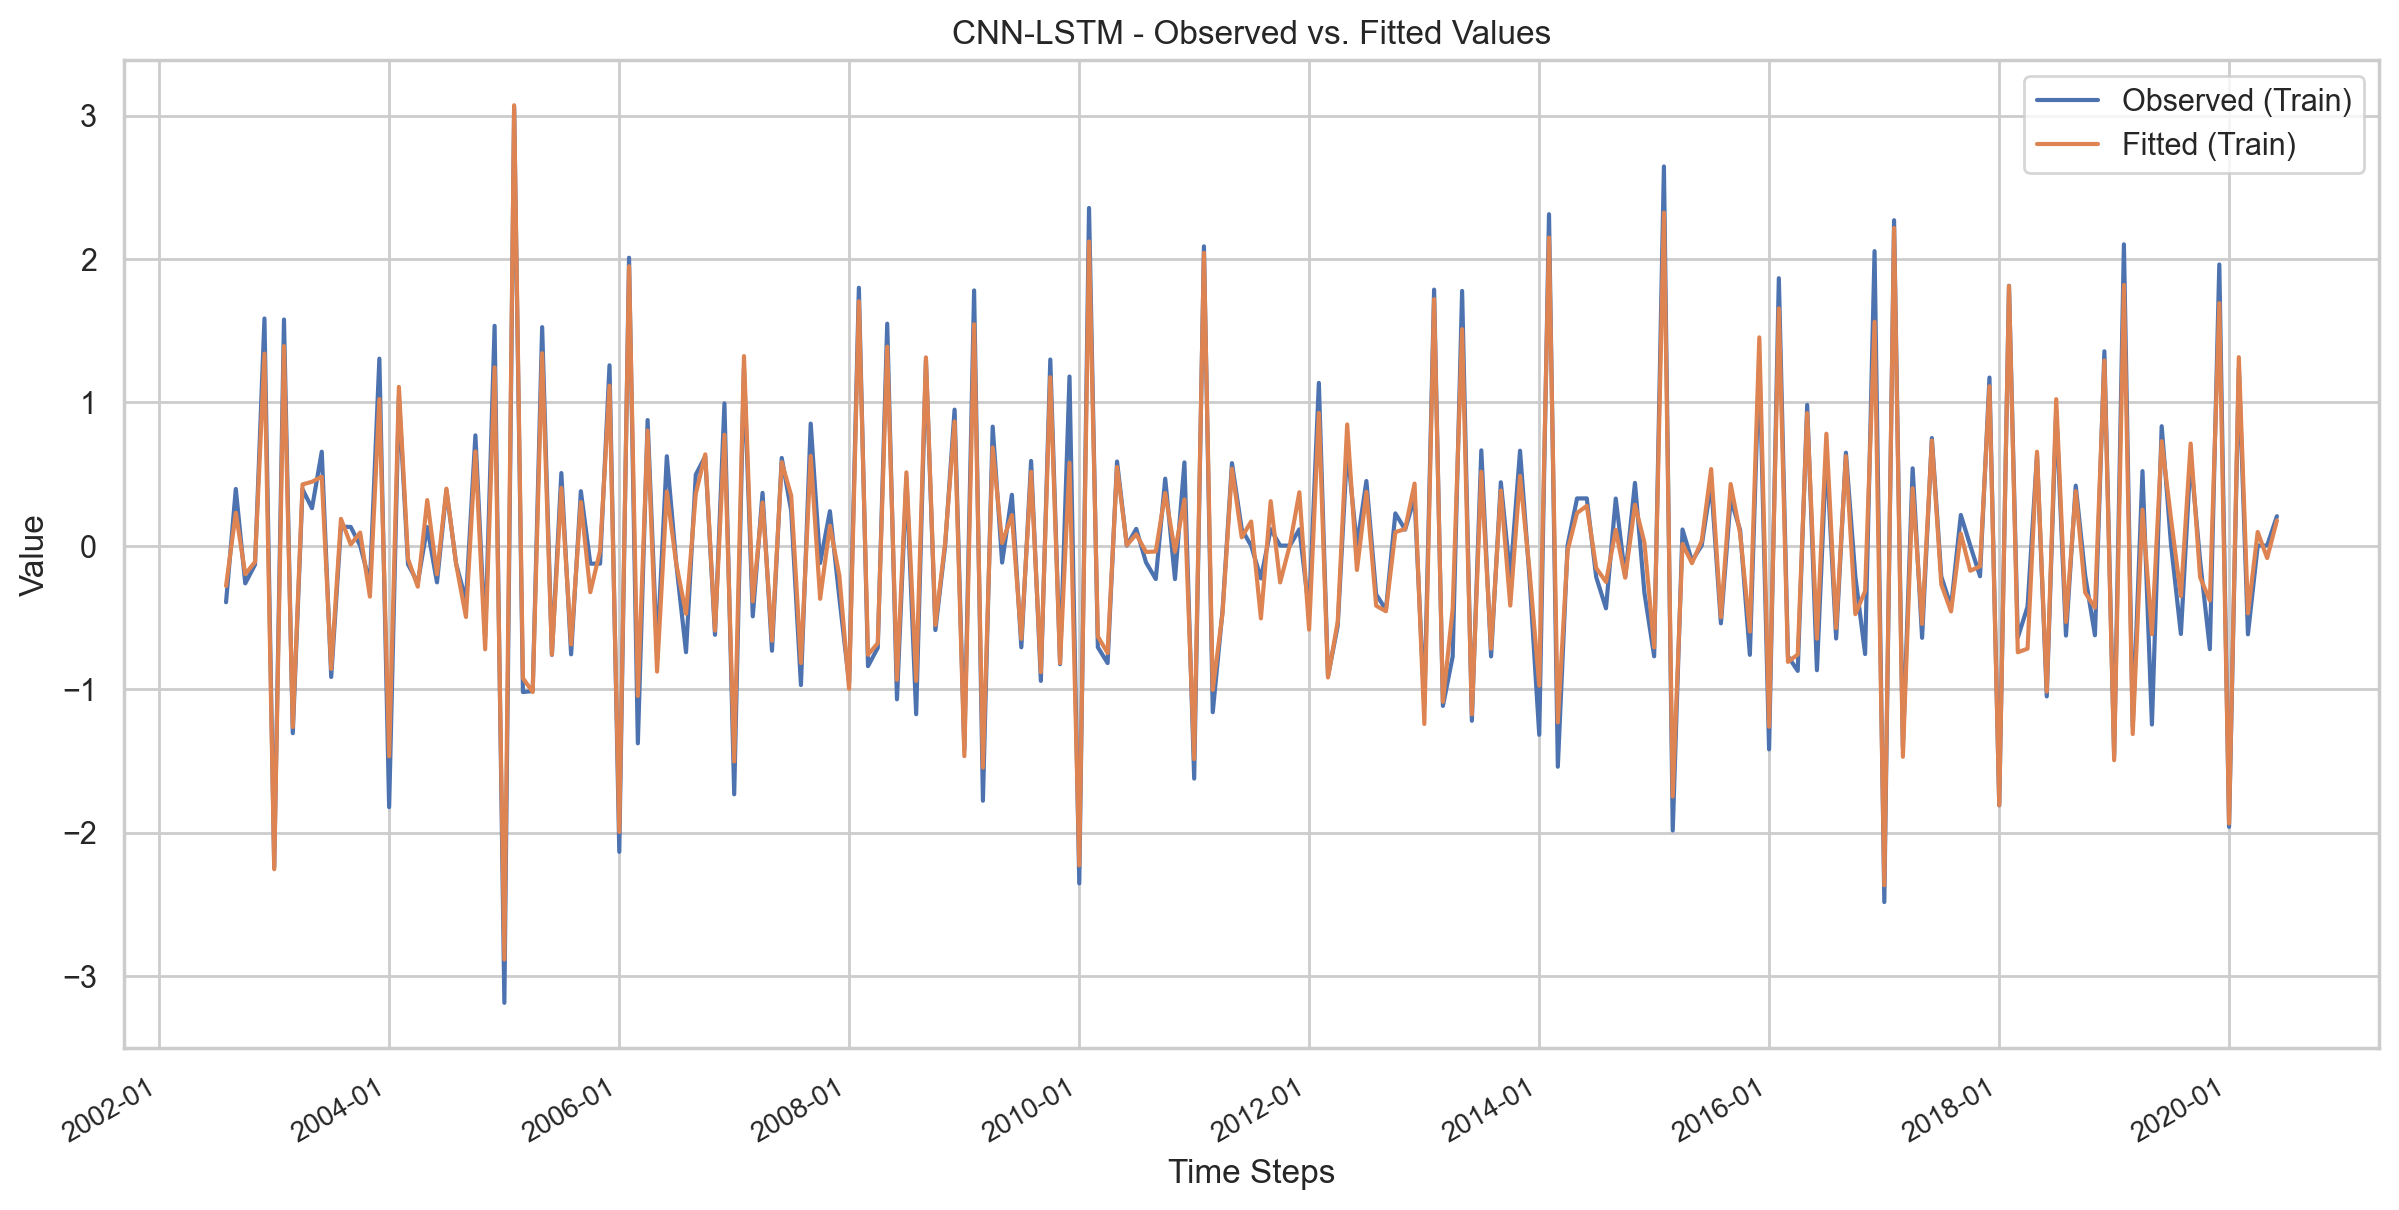

Mean Absolute Error (MAE): 0.74980056
Root Mean Squared Error (RMSE): 0.94338761


In [687]:
model_CL2D_nfe, X_train_CL2D_nfe, X_test_CL2D_nfe, mae_CL2D_nfe, rmse_CL2D_nfe, fnames_CL2D_nfe = convlstm2D(df_main_plus_targ1, target, test_size, 3)

# All Results for one sample run

In [690]:
print(f'CNN-LSTM (MAE): {mae_C1D_acf}')
print(f'VAR (MAE): {var_mae}')
print(f'ARIMA (MAE): {arima_mae}')
print(f'SARIMA (MAE): {sarima_mae}')

print(f'CONV 1D NFE (MAE): {mae_C1D_nfe}')
print(f'CONVLSTM 2D NFE (MAE): {mae_CL2D_nfe}')
print(f'CONVLSTM 1D + NFE (MAE): {mae_CL1D_nfe}')

print(f'CONV 1D + ACF/PACF (MAE): {mae_C1D_acf}')
print(f'CONVLSTM 1D + ACF/PACF (MAE): {mae_CL1D_acf}')

# print(f'CONVLSTM 1D + VAE (MAE): {mae_CL1D_vae}')
print(f'CONVLSTM 2D + VAE (MAE): {mae_CL2D_vae}')




CNN-LSTM (MAE): 0.42629377423434983
VAR (MAE): 0.5760321329444057
ARIMA (MAE): 0.40631126432702086
SARIMA (MAE): 0.366834323670619
CONV 1D NFE (MAE): 0.5392681222498419
CONVLSTM 2D NFE (MAE): 0.7498005611980344
CONVLSTM 1D + NFE (MAE): 0.7150210642336569
CONV 1D + ACF/PACF (MAE): 0.42629377423434983
CONVLSTM 1D + ACF/PACF (MAE): 0.5451260816193217
CONVLSTM 2D + VAE (MAE): 0.6349641500886034
VAR (MAE): 0.5760321329444057
ARIMA (MAE): 0.40631126432702086
SARIMA (MAE): 0.366834323670619


# NEW CNN-LSTM VAE Model

In [383]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model

# This VAE class is the modern way to implement custom models and losses
class VAE(keras.Model):
    def __init__(self, original_dim, intermediate_dim, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim

        # Define Encoder
        encoder_inputs = Input(shape=(original_dim,))
        h = Dense(intermediate_dim, activation="relu")(encoder_inputs)
        z_mean = Dense(latent_dim, name="z_mean")(h)
        z_log_var = Dense(latent_dim, name="z_log_var")(h)

        def sampling(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        z = Lambda(sampling, name='z')([z_mean, z_log_var])
        self.encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

        # Define Decoder
        latent_inputs = Input(shape=(latent_dim,))
        h_decoded = Dense(intermediate_dim, activation="relu")(latent_inputs)
        outputs = Dense(original_dim, activation="linear")(h_decoded)
        self.decoder = Model(latent_inputs, outputs, name="decoder")

        # Define trackers for our custom losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # Lists the metrics to be tracked
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        # This method defines the logic for one training step
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # 1. Get latent vectors from the encoder
            z_mean, z_log_var, z = self.encoder(data)
            # 2. Reconstruct the input from the latent vector
            reconstruction = self.decoder(z)

            # 3. Calculate the losses
            squared_difference = tf.square(data - reconstruction)
            # The rest of the logic remains the same.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(squared_difference, axis=-1)
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        # 4. Calculate gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # 5. Update the loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

def prepare_vae_data(data, target_column, latent_dim=5, intermediate_dim=32, epochs=100, batch_size=32, verbose=0):
    # Separate features and target
    df = data.copy()
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Normalize
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    original_dim = X_scaled.shape[1]

    # 1. Instantiate the custom VAE model
    vae = VAE(original_dim=original_dim, intermediate_dim=intermediate_dim, latent_dim=latent_dim)

    # 2. Compile the model with only an optimizer. Loss is handled inside.
    # vae.compile(optimizer=keras.optimizers.Adam())
    vae.compile(optimizer=keras.optimizers.Adam(), loss='mse')

    # 3. Train the model
    # vae.fit(X_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=verbose)
    # vae.fit(X_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_scaled,), verbose=verbose)
    vae.fit(X_scaled, X_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_scaled, X_scaled), verbose=verbose)

    # 4. Use the trained encoder to get the latent representations
    _, _, z_encoded = vae.encoder.predict(X_scaled)

    # 5. Create the final DataFrame
    z_encoded_df = pd.DataFrame(z_encoded, columns=[f"z{i + 1}" for i in range(latent_dim)], index=data.index)
    z_encoded_df[target_column] = y.values

    return z_encoded_df

In [ ]:
data_comp = prepare_vae_data(df_main_plus_targ1, target)

In [563]:
model_CL2D_vae, X_train_CL2D_vae, X_test_CL2D_vae, mae_CL2D_vae, rmse_CL2D_vae, fnames_CL2D_vae = convlstm2D(data_comp, target, test_size, 1)


KeyboardInterrupt: 

# SHAP Value Estimation for CNN-LSTM Model

In [15]:
def get_model_input_shape(model):
    """Return the input shape of the first layer (excluding batch size)."""
    return model.input_shape[1:]

def create_model_predict_fn(model, input_shape):
    """Wrapper to adapt SHAP 2D input back to model's expected input shape."""
    def model_predict(X_flat):
        # Reshape 2D SHAP input to original model input shape
        X = X_flat.reshape((X_flat.shape[0], *input_shape))
        return model.predict(X, verbose=0).flatten()
    return model_predict

def shappy(model, X_test, feature_names):
    """SHAP with feature importance aggregated over timesteps (one row per feature)."""
    input_shape = get_model_input_shape(model)  # (timesteps, features)
    num_samples = min(50, X_test.shape[0])
    timesteps = input_shape[0]

    # Sample input
    X_sample = X_test[:num_samples]  # shape: (samples, timesteps, features)
    X_flat = X_sample.reshape((num_samples, -1))  # (samples, timesteps * features)

    # Create repeated column names: [CPI, CPI, CPI, WPI, WPI, WPI, ...]
    repeated_feature_names = feature_names * timesteps
    X_df = pd.DataFrame(X_flat, columns=repeated_feature_names)

    # Model wrapper
    model_predict = create_model_predict_fn(model, input_shape)

    # SHAP explainer
    explainer = shap.KernelExplainer(model_predict, X_df)
    shap_values = explainer.shap_values(X_df)

    # Convert SHAP values to DataFrame and aggregate by feature name
    shap_df = pd.DataFrame(shap_values, columns=repeated_feature_names)
    mean_abs_importance = shap_df.abs().groupby(level=0, axis=1).mean().mean().sort_values(ascending=False)

    return shap_values, mean_abs_importance.index.tolist(), shap_df

In [16]:
# model_C1D_nfe, X_train_C1D_nfe, X_test_C1D_nfe, mae_C1D_nfe, rmse_C1D_nfe, fnames_C1D_nfe = conv1D(df_main_plus_targ1,target, test_size, 3)

shap_values_C1D_nfe, feature_names_C1D_nfe, shap_df_C1D_nfe = shappy(model_C1D_nfe, X_test_C1D_nfe, fnames_C1D_nfe)

Model predicting...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3, 8)           │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,157 (4.52 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 772 (3.02 KB)

None
Shape
(54, 3, 22)
Feature name
['UNERWG', 'ECBIRRO', 'ECBDFR', 'ECBMLFR', 'MMR', 'CPI', 'RETAILMV', 'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT', 'AGRPROD', 'PPIIP', 'WPI', 'EPI', 'IPI', 'HICP', 'LTIR', 'UR', 'DAX', 'STOXX50E', 'EW']


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_32666/2936781673.py:42: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mean_abs_importance = shap_df.abs().groupby(level=0, axis=1).mean().mean().sort_values(ascending=False)


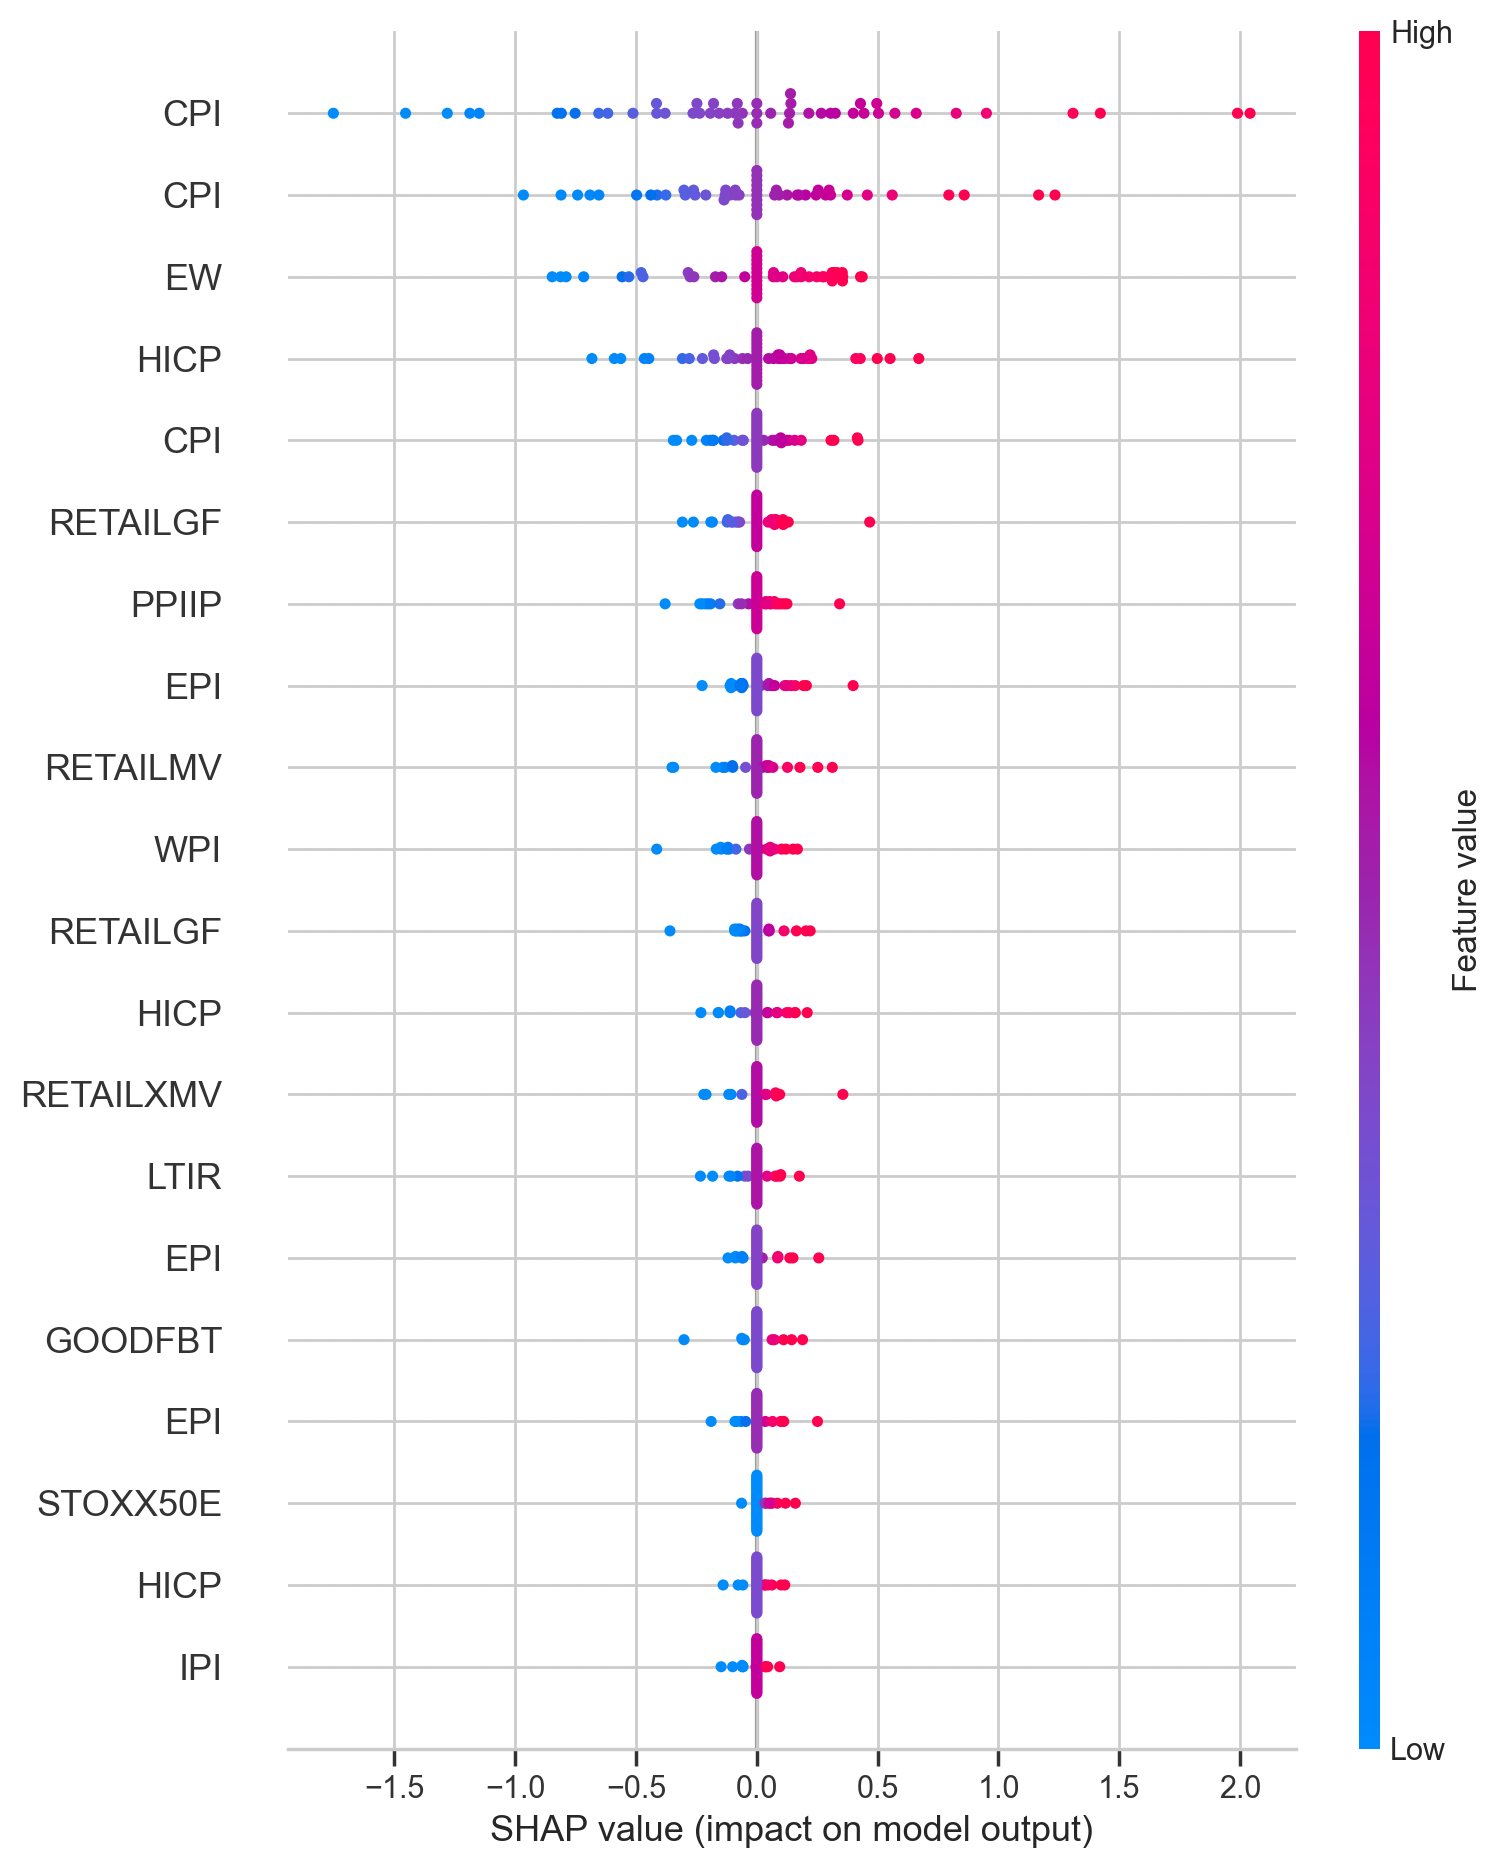

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values_C1D_nfe, shap_df_C1D_nfe, show=False)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
plt.show()

# ***Top Influential Variables***

In [524]:

# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values_3l).mean(axis=0)

# Create a dictionary mapping feature names to their importance
shap_importance_dict = dict(zip(feature_names_3l, shap_importance))

# Sort features by importance (descending order)
sorted_features = sorted(shap_importance_dict, key=shap_importance_dict.get, reverse=True)



In [525]:
# Convert the dictionary to a list of (feature, importance) tuples
shap_importance_list = list(shap_importance_dict.items())

# Sort the list in descending order based on the importance value (second element of the tuple)
shap_importance_list.sort(key=lambda item: item[1], reverse=True)

# Print the sorted feature names and their importance values
print("SHAP Feature Importance (Descending Order):")
for feature, importance in shap_importance_list:
    print(f"{feature}: {importance:.8f}") # You can adjust the formatting of the importance value

SHAP Feature Importance (Descending Order):
PPIIP: 0.06813659
IPI: 0.04865445
STOXX50E: 0.03348136
RETAILXMV: 0.02935559
ECBMLFR: 0.02769460
UR: 0.02550882
GOODFBT: 0.01320778
AGRPROD: 0.01312238
ECBIRRO: 0.00908622
RETAILMV: 0.00444533
RETAILGSR: 0.00312340
WPI: 0.00175803
ECBDFR: 0.00111367
HICP: 0.00071384
CPI_L1: 0.00000000
EPI: 0.00000000
RETAILGF: 0.00000000
LTIR: 0.00000000
UNERWG: 0.00000000
DAX: 0.00000000
MMR: 0.00000000


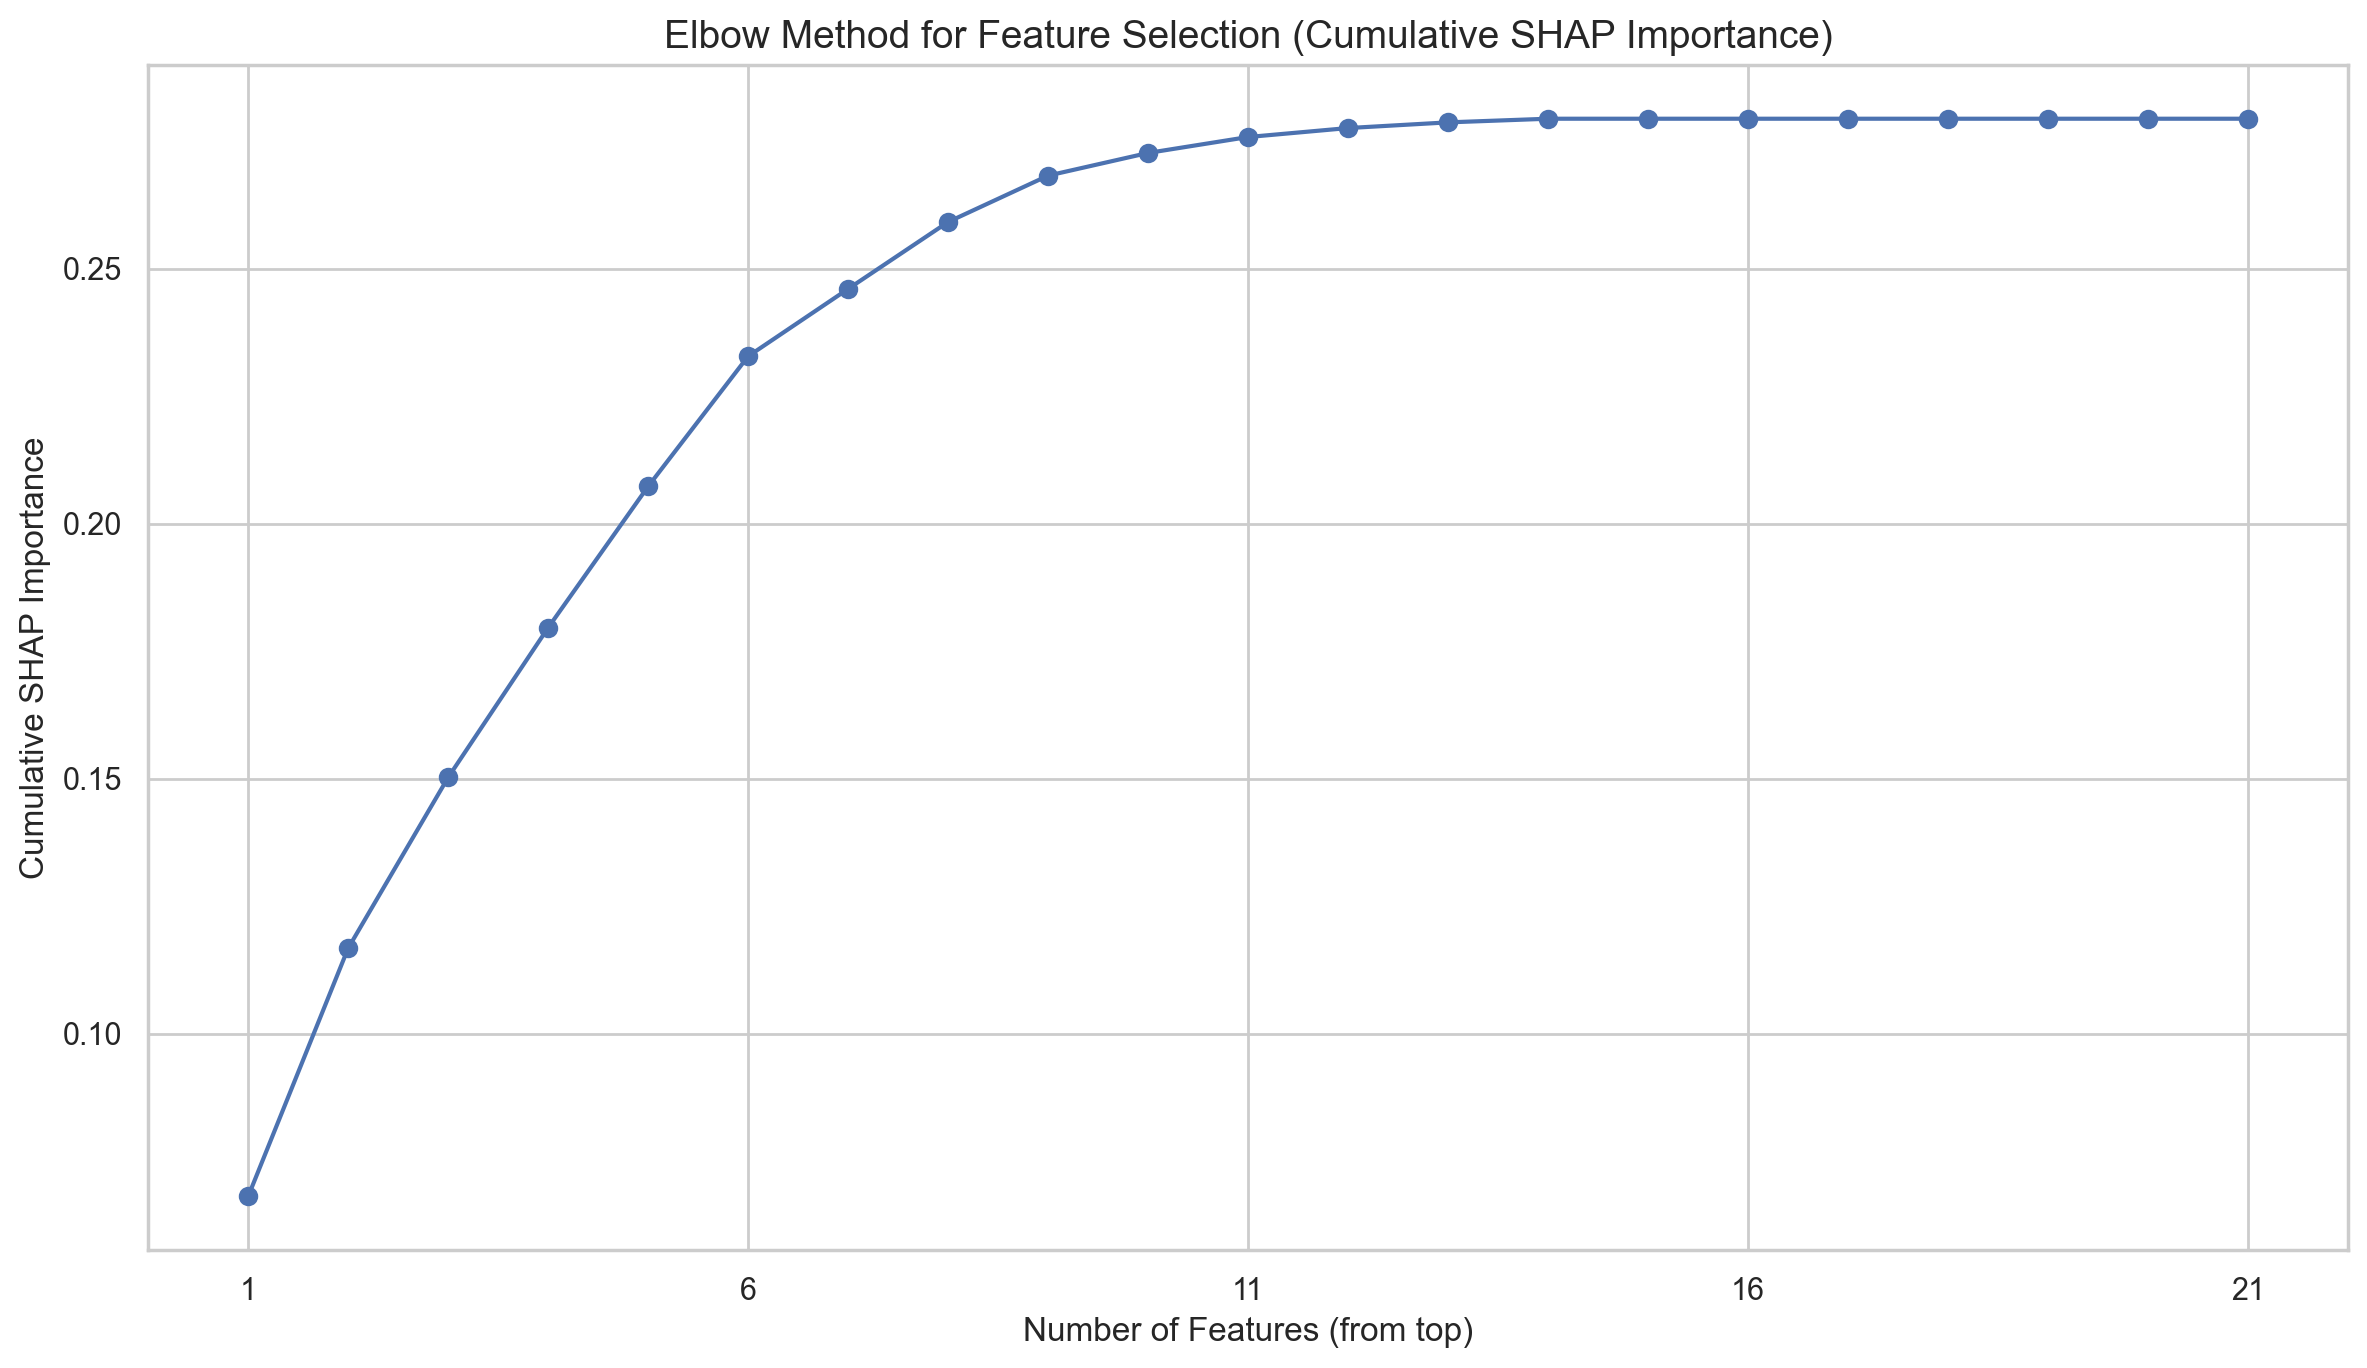

In [527]:
# Extract importance values
importance_values = [item[1] for item in shap_importance_list]

# Calculate cumulative importance
cumulative_importance = [sum(importance_values[:i+1]) for i in range(len(importance_values))]

# Plotting with adjustments
plt.figure(figsize=(12, 7))  # Increase figure size
plt.plot(range(1, len(importance_values) + 1), cumulative_importance, marker='o', linestyle='-')
plt.xlabel("Number of Features (from top)", fontsize=12)
plt.ylabel("Cumulative SHAP Importance", fontsize=12)
plt.title("Elbow Method for Feature Selection (Cumulative SHAP Importance)", fontsize=14)
plt.grid(True)

# Adjust x-axis ticks to be less dense (show every 5 features)
plt.xticks(range(1, len(importance_values) + 1, 5))

plt.tight_layout()
plt.show()

In [550]:
# Since no elbow we settle for the top 30 variables as this captures over 80% of the total importance
# one_third = len(sorted_features) // 3
top_influential_variables = np.array(sorted_features)[:14]

# Print the top influential variables
print("*** Top 31 influential variables based on elbow ***")
print(top_influential_variables)
print("*** All variables sorted in order of influence ***")
print(sorted_features)

*** Top 31 influential variables based on elbow ***
['PPIIP' 'IPI' 'STOXX50E' 'RETAILXMV' 'ECBMLFR' 'UR' 'GOODFBT' 'AGRPROD'
 'ECBIRRO' 'RETAILMV' 'RETAILGSR' 'WPI' 'ECBDFR' 'HICP']
*** All variables sorted in order of influence ***
['PPIIP', 'IPI', 'STOXX50E', 'RETAILXMV', 'ECBMLFR', 'UR', 'GOODFBT', 'AGRPROD', 'ECBIRRO', 'RETAILMV', 'RETAILGSR', 'WPI', 'ECBDFR', 'HICP', 'CPI_L1', 'EPI', 'RETAILGF', 'LTIR', 'UNERWG', 'DAX', 'MMR']


In [551]:
top_influential_variables = np.append(top_influential_variables, target).copy()

print(top_influential_variables)

['PPIIP' 'IPI' 'STOXX50E' 'RETAILXMV' 'ECBMLFR' 'UR' 'GOODFBT' 'AGRPROD'
 'ECBIRRO' 'RETAILMV' 'RETAILGSR' 'WPI' 'ECBDFR' 'HICP' 'CPI']


# ***CNN-LSTM + Variable Selection***

CNN Model - Mean Absolute Error (MAE):  0.7522
CNN Model - Root Mean Squared Error (RMSE):  0.9319


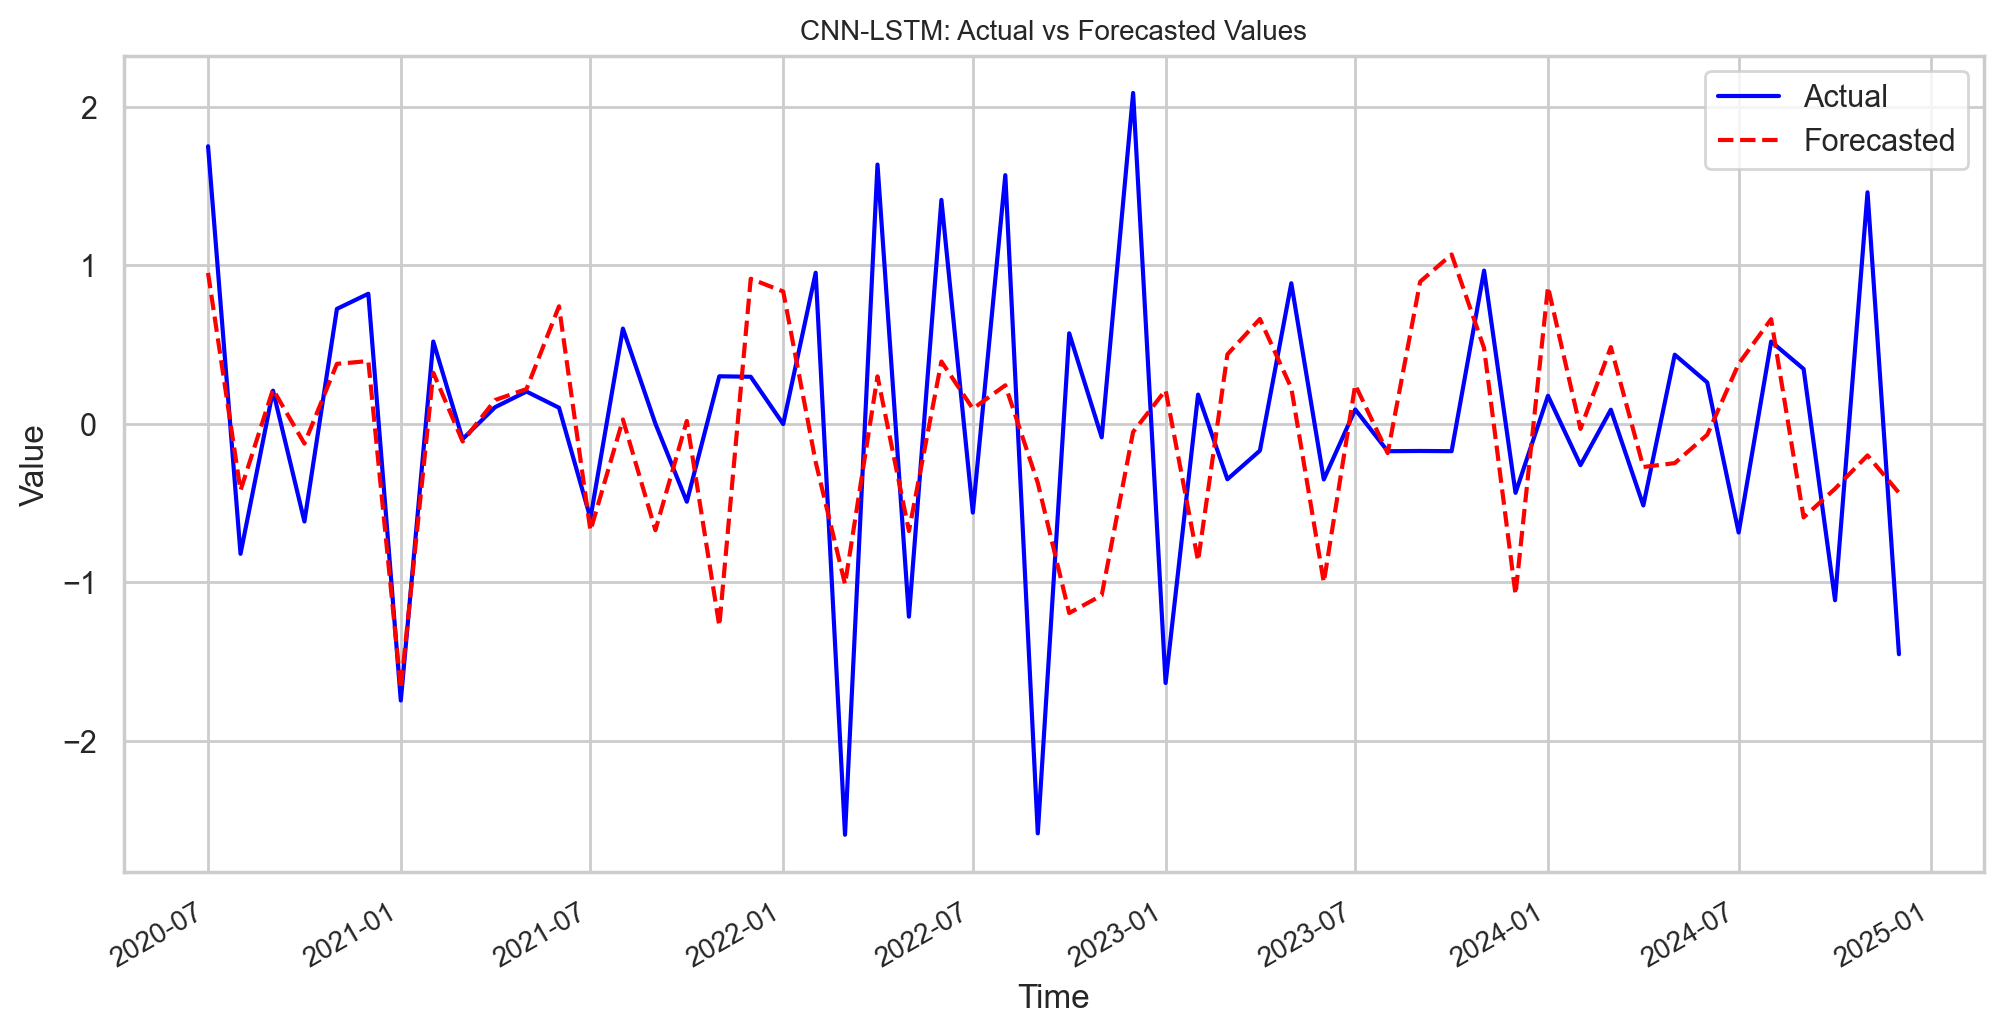

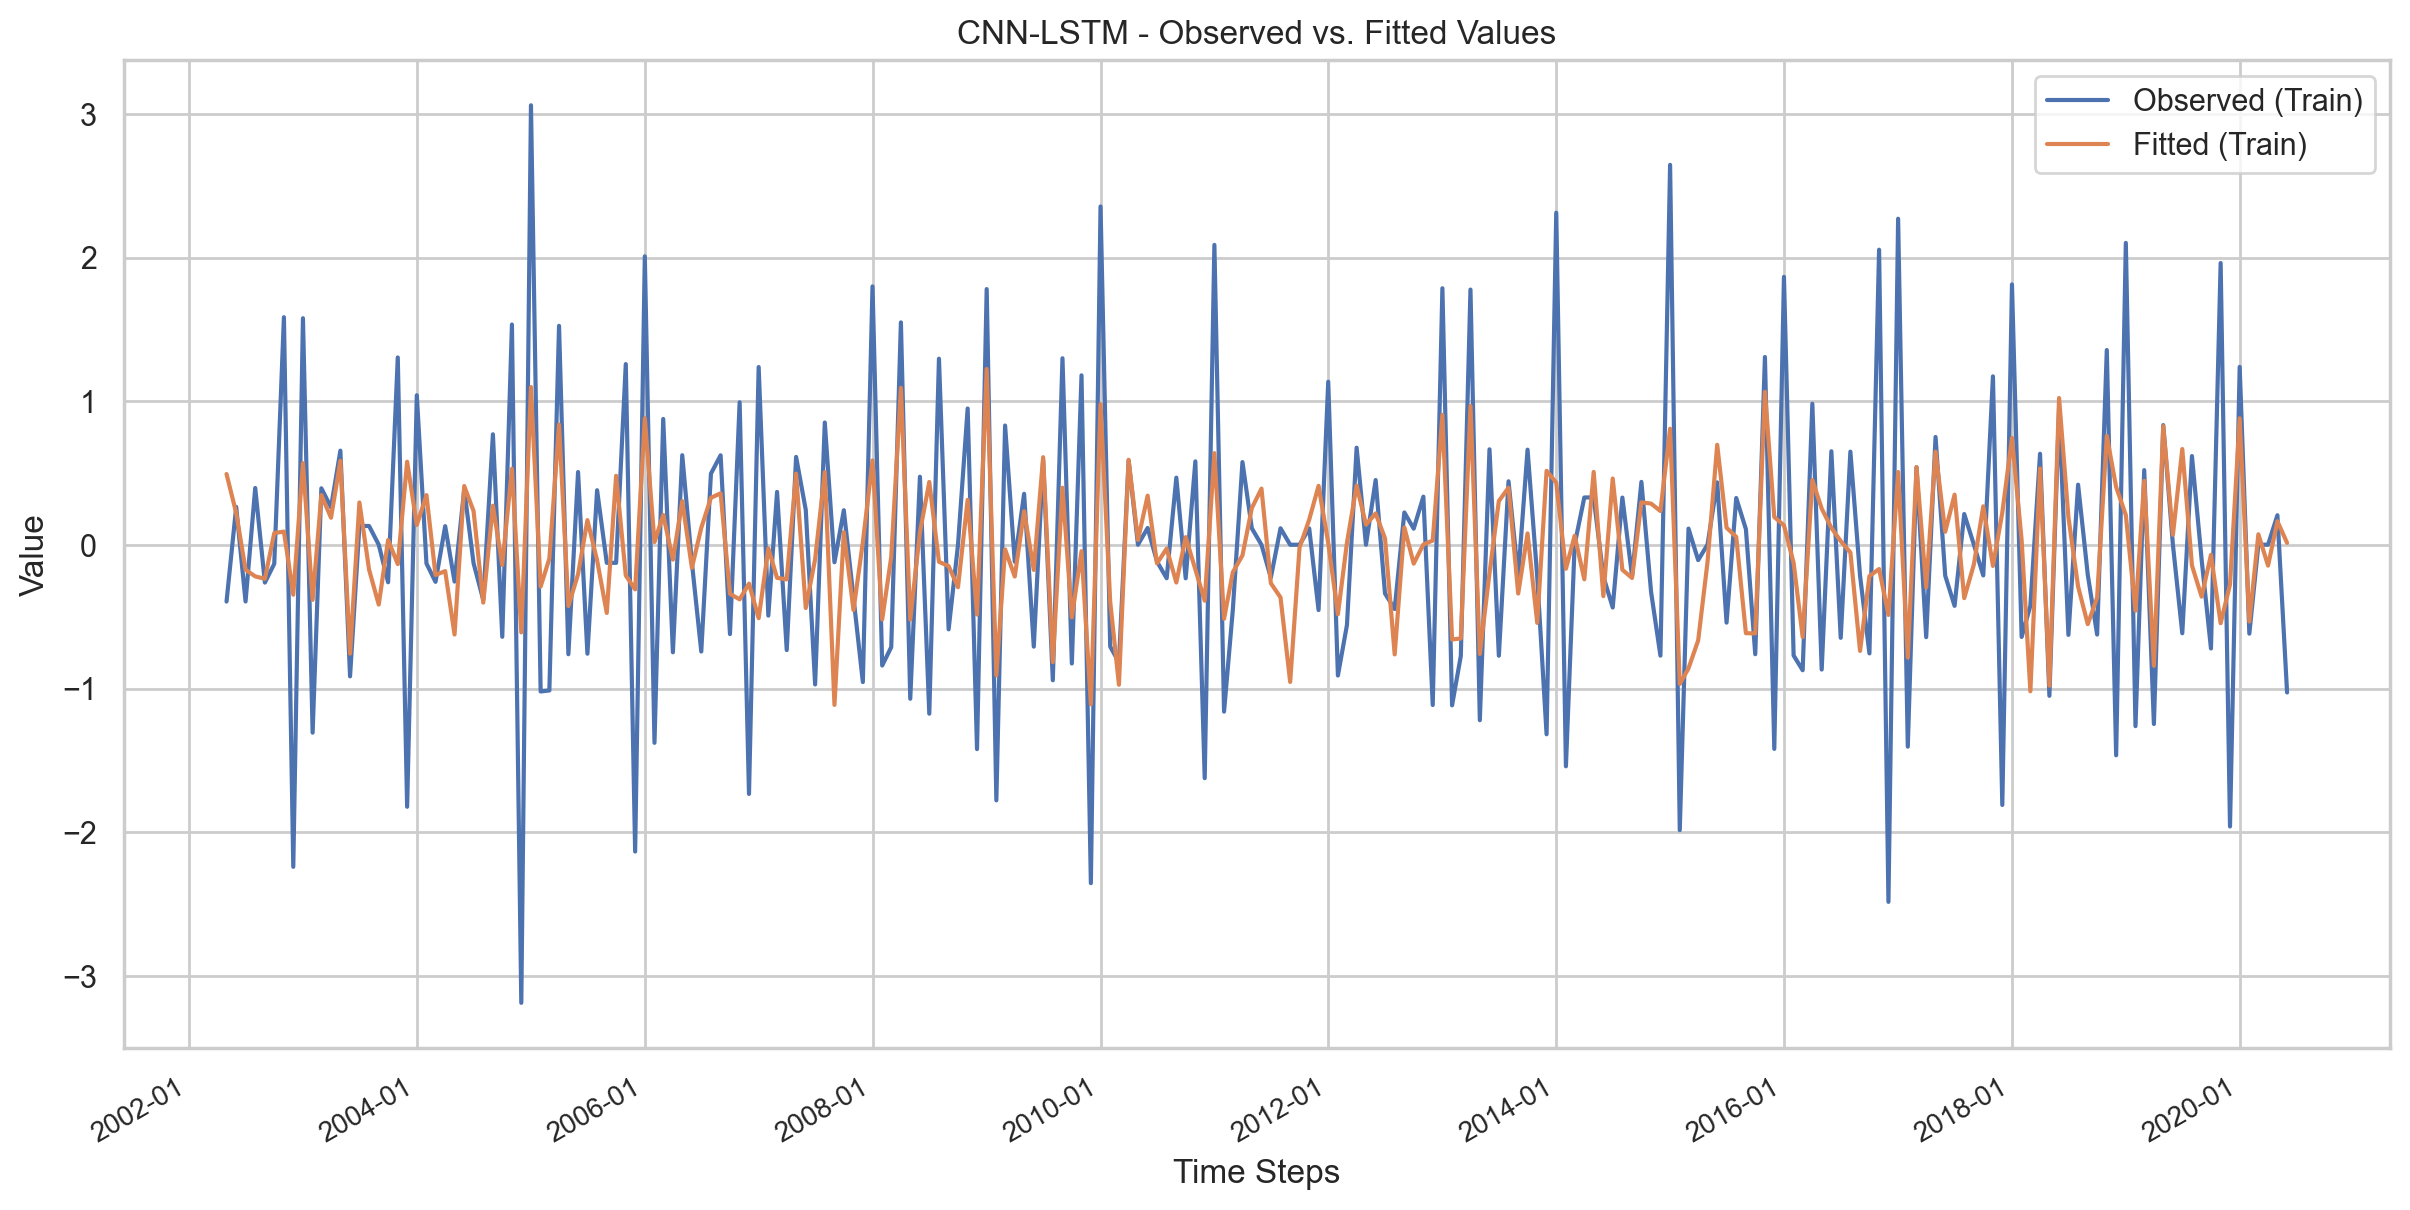

Mean Absolute Error (MAE): 0.75219480
Root Mean Squared Error (RMSE): 0.93194258


In [564]:

# Add the target variable to the list of influential variables
data_shap = df_main_plus_targ1[top_influential_variables]
model_C1D_shap, X_train_C1D_shap, X_test_C1D_shap, mae_C1D_shap, rmse_C1D_shap, fnames_C1D_shap = conv1D(data_shap, target, test_size, 1)


# ***Robust Test***

# ***ARIMA***

# ***VAR***

# ***SARIMA***

 # ***CNN-LSTM***

# ***SUMMARY STATISTICS***

Significance Test

# CODE OF AGES